In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from utils.utils import Fill_NC_With_Station_Values, aggregate_per_timestep_xr, calculate_metrics
from era5.era5_cropper import Era5ForStationCropper
from train_station_twin.prepare_training_executor_era5 import TrainingPreparation
import torch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from utils.station_utils import apply_aggregation, statistics, calculate_uv, plot_variable_over_time, plot_hist, plot_event_comparison 



In [2]:
def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, title1="Ground Truth", title2="Predicted"):
    """
    Improved plot for two xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot.
    ds2 (xr.DataArray): Second DataArray to plot.
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2 = xr.align(ds1, ds2)

    # Create a larger figure
    plt.figure(figsize=(14, 8))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.where(~ds1.isnull()), label=title1, marker='x', linestyle='-', color='blue')
    plt.plot(ds2.time, ds2.where(~ds2.isnull()), label=title2, marker='x', linestyle='-', color='orange', alpha=0.5)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    #plt.ylim(950, 1050)  # Note: reversed y-axis

    plt.ylabel('Precipitaion in mm')
    plt.title('Comparison of Ground Truth vs Predicted Pressure Vienna')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [3]:
def improved_plot_datasets_3(ds1: xr.DataArray, ds2: xr.DataArray, ds3: xr.DataArray,
                           title1="Ground Truth/Measurement", title2="Predicted", title3="ERA5 Nearest Grid Point",
                           start_date: str = None, end_date: str = None, 
                           df: pd.DataFrame = None, df_label: str = "Station Data"):
    """
    Improved plot for three xarray DataArrays over time, with enhancements and an option to include a pandas DataFrame.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot (e.g., Ground Truth).
    ds2 (xr.DataArray): Second DataArray to plot (e.g., Predicted).
    ds3 (xr.DataArray): Third DataArray to plot (e.g., ERA5 Nearest Grid Point).
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    title3 (str): Label for the third dataset.
    start_date (str, optional): Start date for filtering (e.g., "2024-03-01").
    end_date (str, optional): End date for filtering (e.g., "2024-03-31").
    df (pd.DataFrame, optional): A pandas DataFrame with a datetime column/index and values to plot.
    df_label (str): Label for the pandas DataFrame in the legend.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2, ds3 = xr.align(ds1, ds2, ds3)

    # Filter xarray datasets by the specified time range if provided
    if start_date or end_date:
        time_slice = slice(start_date, end_date)
        ds1 = ds1.sel(time=time_slice)
        ds2 = ds2.sel(time=time_slice)
        ds3 = ds3.sel(time=time_slice)

    # Filter pandas DataFrame by the specified time range if provided
    if df is not None:
        if start_date:
            df = df[df.index >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df.index <= pd.to_datetime(end_date)]

    # Create a larger figure
    plt.figure(figsize=(16, 10))

    # Plot each xarray dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1, label=title1, marker='x', linestyle='-', color='blue', alpha=0.9)
    plt.plot(ds2.time, ds2, label=title2, marker='x', linestyle='-', color='orange', alpha=0.9)
    plt.plot(ds3.time, ds3, label=title3, marker='x', linestyle='-', color='green', alpha=0.9)

    # Plot pandas DataFrame if provided
    if df is not None:
        plt.plot(df.index, df.values, label=df_label, marker='o', linestyle='--', color='red', alpha=0.1)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Precipitation in mm')
    plt.title('Comparison of Ground Truth, Predicted, ERA5, and Station Data')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [4]:
def plot_era5_precipitation(
    dataset_path,
    variable='tp',
    point_coords=(-59.54316, 13.16443),
    time_range=("2021-01-07 00:00", "2021-01-07 23:00"),
    title_base='Total Precipitation Barbados Event 1',
    cmap='viridis',
):
    """
    Plots ERA5 precipitation data for a specific time range and location.
    
    Parameters:
    - dataset_path (str): Path to the ERA5 dataset (netCDF file).
    - variable (str): Name of the variable to plot (default: 'tp').
    - point_coords (tuple): Longitude and latitude of the specific point (default: (-59.54316, 13.16443)).
    - time_range (tuple): Start and end times for the data to plot (default: ("2021-01-07 00:00", "2021-01-07 23:00")).
    - title_base (str): Base title for the plots (default: 'Total Precipitation Barbados Event 1').
    - cmap (str): Colormap for the plots (default: 'viridis').
    """
    # Open the dataset
    era5_data = xr.open_dataset(dataset_path)

    # Extract coordinates and data
    lat = era5_data.lat.values
    lon = era5_data.lon.values
    point_lon, point_lat = point_coords

    # Select the time range
    selected_data = era5_data.sel(time=slice(*time_range))

    # Create a meshgrid for pcolormesh
    Lon, Lat = np.meshgrid(lon, lat)

    # Define plot parameters
    vmin = selected_data[variable].min().item()
    vmax = selected_data[variable].max().item()

    for t in selected_data.time:
        # Create a new figure with Cartopy's PlateCarree projection
        fig, ax = plt.subplots(
            figsize=(10, 8),
            subplot_kw={'projection': ccrs.PlateCarree()}
        )

        # Extract data for the current time step
        data = selected_data[variable].sel(time=t).values

        # Handle missing or invalid data
        data = np.ma.masked_invalid(data)

        # Plot the data using pcolormesh
        pcm = ax.pcolormesh(
            Lon, Lat, data, 
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            transform=ccrs.PlateCarree()
        )

        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)

        # Plot the specific point
        ax.plot(
            point_lon, point_lat,
            marker='x', color='red', markersize=12,
            transform=ccrs.PlateCarree(),
            label='Specific Point'
        )

        # Add a colorbar
        cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
        cbar.set_label('Precipitation (mm)', fontsize=12)

        # Set title with time information
        time_str = pd.to_datetime(t.values).strftime('%Y-%m-%d %H:%M')
        plt.title(f'{title_base} at {time_str}', fontsize=16, pad=20)

        # Add legend for the point marker
        ax.legend(loc='lower left', fontsize=12)

        # Adjust layout for better spacing
        plt.tight_layout()

        # Show the plot
        plt.show()

        # Close the figure to free memory
        plt.close(fig)



In [5]:
# Load ERA5 Data
# this covers the period 2020-2023 and is in 9x9 grid
era5_vienna = xr.open_dataset('era5_data/er5_newhook/vienna_allvar_2017-2024_renamed.nc') 
era5_vienna

# era5_data/er5_newhook/vienna_allvar_2017-2024_renamed.nc

<xarray.Dataset>
Dimensions:  (time: 66456, lon: 17, lat: 17)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2024-07-31T23:00:00
  * lon      (lon) float64 14.36 14.61 14.86 15.11 ... 17.61 17.86 18.11 18.36
  * lat      (lat) float64 50.23 49.98 49.73 49.48 ... 46.98 46.73 46.48 46.23
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    dt2m     (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [6]:
# load hourly station data
vienna_hourly_df = pd.read_csv("station_data_processed/vienna_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)
vienna_hourly_df.head()
# vienna_hourly_df["tipping"].dropna()
vienna_hourly_df

# station_data_processed/vienna_hourly_aggregated_data.csv

bmp280_temp  bmp280_pres  bmp280_slp  htu_temp  htu_hum  \
datetime                                                                       
2017-04-24 07:00:00          NaN          NaN         NaN       NaN      NaN   
2017-04-24 08:00:00          NaN          NaN         NaN       NaN      NaN   
2017-04-24 09:00:00          NaN          NaN         NaN       NaN      NaN   
2017-04-24 10:00:00          NaN          NaN         NaN       NaN      NaN   
2017-04-24 11:00:00          NaN          NaN         NaN       NaN      NaN   
...                          ...          ...         ...       ...      ...   
2022-05-24 12:00:00        23.13      989.470     1007.76      22.4    63.25   
2022-05-24 13:00:00          NaN          NaN         NaN       NaN      NaN   
2022-05-24 14:00:00        22.81      989.420     1007.73      22.0    63.20   
2022-05-24 15:00:00        22.42      989.405     1007.73      21.6    62.95   
2022-05-24 16:00:00        22.24      989.700     1008.04      21.4    62.30   

                     mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                               
2017-04-24 07:00:00      NaN      0.0        NaN       NaN       NaN   
2017-04-24 08:00:00      NaN      0.0        NaN       NaN       NaN   
2017-04-24 09:00:00      NaN      0.0        NaN       NaN       NaN   
2017-04-24 10:00:00      NaN      0.2        NaN       NaN       NaN   
2017-04-24 11:00:00      NaN      NaN        NaN       NaN       NaN   
...                      ...      ...        ...       ...       ...   
2022-05-24 12:00:00     21.9      0.0      569.0    3174.0     167.0   
2022-05-24 13:00:00      NaN      NaN        NaN       NaN       NaN   
2022-05-24 14:00:00     21.8      0.0      486.0    2275.0     123.0   
2022-05-24 15:00:00     21.4      0.0      385.5    1481.0      69.0   
2022-05-24 16:00:00     21.2      0.0      308.0     703.0      27.0   

                       wind_dir  wind_speed  u_wind  v_wind  
datetime                                                     
2017-04-24 07:00:00   23.349669         NaN     NaN     NaN  
2017-04-24 08:00:00   20.898067         NaN     NaN     NaN  
2017-04-24 09:00:00   19.371252         NaN     NaN     NaN  
2017-04-24 10:00:00   44.898214    0.398644     0.0     0.0  
2017-04-24 11:00:00         NaN         NaN     NaN     NaN  
...                         ...         ...     ...     ...  
2022-05-24 12:00:00  205.080658         NaN     NaN     NaN  
2022-05-24 13:00:00         NaN         NaN     NaN     NaN  
2022-05-24 14:00:00  180.022444         NaN     NaN     NaN  
2022-05-24 15:00:00  176.727625         NaN     NaN     NaN  
2022-05-24 16:00:00  182.053674         NaN     NaN     NaN  

[44554 rows x 14 columns]

In [7]:
# load minutels station data
vienna_df = pd.read_csv("station_data_processed/vienna_hourly_processed_data.csv", index_col=0,  parse_dates=True)
vienna_df.head()
# barbados_hourly_df["tipping"].dropna()
vienna_df


bmp180_temp  bmp180_pres  bmp180_slp  bmp180_alt  \
datetime                                                                
2017-04-24 07:14:00          NaN          NaN         NaN         NaN   
2017-04-24 07:15:00          NaN          NaN         NaN         NaN   
2017-04-24 07:16:00          NaN          NaN         NaN         NaN   
2017-04-24 07:17:00          NaN          NaN         NaN         NaN   
2017-04-24 07:18:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2022-05-24 16:36:00          NaN          NaN         NaN         NaN   
2022-05-24 16:37:00          NaN          NaN         NaN         NaN   
2022-05-24 16:38:00          NaN          NaN         NaN         NaN   
2022-05-24 16:39:00          NaN          NaN         NaN         NaN   
2022-05-24 16:40:00          NaN          NaN         NaN         NaN   

                     bmp280_temp  bmp280_pres  bmp280_slp  bmp280_alt  \
datetime                                                                
2017-04-24 07:14:00          NaN          NaN         NaN         NaN   
2017-04-24 07:15:00          NaN          NaN         NaN         NaN   
2017-04-24 07:16:00          NaN          NaN         NaN         NaN   
2017-04-24 07:17:00          NaN          NaN         NaN         NaN   
2017-04-24 07:18:00          NaN          NaN         NaN         NaN   
...                          ...          ...         ...         ...   
2022-05-24 16:36:00        22.18       990.02     1008.37       159.0   
2022-05-24 16:37:00        22.19       990.03     1008.38       159.0   
2022-05-24 16:38:00        22.15       990.11     1008.46       159.0   
2022-05-24 16:39:00        22.15       990.11     1008.46       159.0   
2022-05-24 16:40:00        22.15       990.13     1008.48       159.0   

                     bme_temp  bme_pres  ...  bme_hum  htu_temp  htu_hum  \
datetime                                 ...                               
2017-04-24 07:14:00       NaN       NaN  ...      NaN       NaN      NaN   
2017-04-24 07:15:00       NaN       NaN  ...      NaN       NaN      NaN   
2017-04-24 07:16:00       NaN       NaN  ...      NaN       NaN      NaN   
2017-04-24 07:17:00       NaN       NaN  ...      NaN       NaN      NaN   
2017-04-24 07:18:00       NaN       NaN  ...      NaN       NaN      NaN   
...                       ...       ...  ...      ...       ...      ...   
2022-05-24 16:36:00       NaN       NaN  ...      NaN      21.4     61.9   
2022-05-24 16:37:00       NaN       NaN  ...      NaN      21.4     62.5   
2022-05-24 16:38:00       NaN       NaN  ...      NaN      21.3     61.4   
2022-05-24 16:39:00       NaN       NaN  ...      NaN      21.3     61.3   
2022-05-24 16:40:00       NaN       NaN  ...      NaN      21.3     61.4   

                     mcp9808  tipping  vis_light  ir_light  uv_light  \
datetime                                                               
2017-04-24 07:14:00      NaN      0.0        NaN       NaN       NaN   
2017-04-24 07:15:00      NaN      0.0        NaN       NaN       NaN   
2017-04-24 07:16:00      NaN      0.0        NaN       NaN       NaN   
2017-04-24 07:17:00      NaN      0.0        NaN       NaN       NaN   
2017-04-24 07:18:00      NaN      0.0        NaN       NaN       NaN   
...                      ...      ...        ...       ...       ...   
2022-05-24 16:36:00     21.2      0.0      284.0     474.0      15.0   
2022-05-24 16:37:00     21.2      0.0      283.0     460.0      14.0   
2022-05-24 16:38:00     21.2      0.0      281.0     444.0      13.0   
2022-05-24 16:39:00     21.2      0.0      279.0     428.0      12.0   
2022-05-24 16:40:00     21.1      NaN      281.0     415.0      13.0   

                     wind_dir  wind_speed  
datetime                                   
2017-04-24 07:14:00       NaN         0.0  
2017-04-24 07:15:00      70.1         0.0  
2017-04-24 07:16:00

In [58]:
output_output = xr.open_dataset("executed_trainings/Vienna_tp_nonzero_new_20241129-15/model/output_output.nc")
output_gt = xr.open_dataset("executed_trainings/Vienna_tp_nonzero_new_20241129-15/model/output_gt.nc")

In [63]:
output_output = xr.open_dataset("executed_trainings/Vienna_tp_withzero_new_20241129-12/model/output_output.nc")
output_gt = xr.open_dataset("executed_trainings/Vienna_tp_withzero_new_20241129-12/model/output_gt.nc")

In [59]:
output_output.tp.mean()

<xarray.DataArray 'tp' ()>
array(0.9054254, dtype=float32)

In [28]:
output_gt.tp.values[x:x+10]

array([[[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]],

       [[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]],

       [[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.

In [64]:

# Example usage
aggregated_output_output = aggregate_per_timestep_xr(output_output, methods=["mean", "std", "var", "max"], variables=["tp"])
aggregated_output_gt = aggregate_per_timestep_xr(output_gt,  methods=["mean", "std", "var", "max"], variables=["tp"])
#aggregated_input_gt = aggregate_per_timestep_xr(input_gt,  methods=["mean", "std", "var", "max"], variables=["10v"])

aggregated_output_output.mean_tp.mean()

<xarray.DataArray 'mean_tp' ()>
array(0.00035182, dtype=float32)

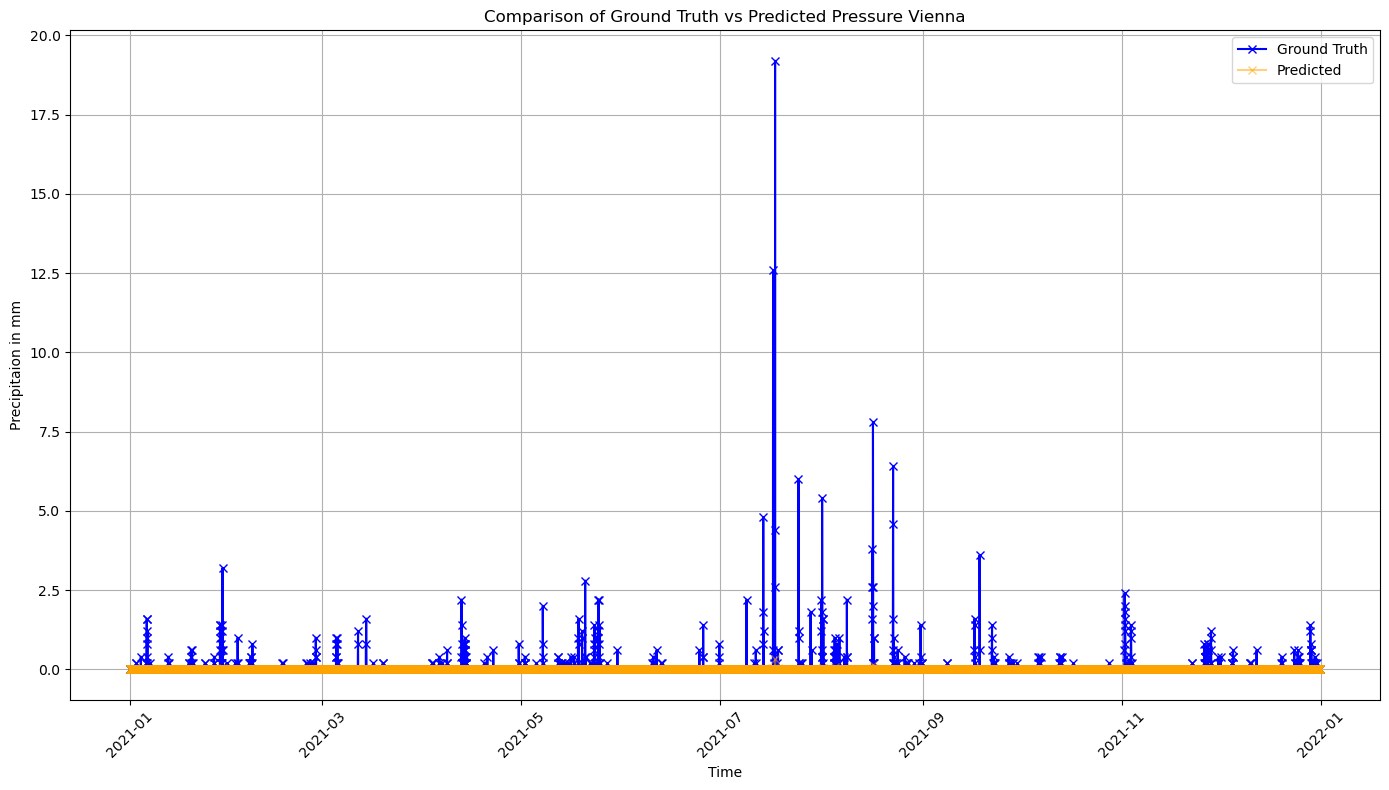

In [65]:

# Usage
improved_plot_datasets(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp )


In [66]:
# Load the ERA5 dataset

# Define the target latitude and longitude
station_lat = 48.2303
station_lon =  16.3609   # Example: Vienna longitude

# Select the nearest grid point
nearest_grid_point = era5_vienna.sel(lat=station_lat, lon=station_lon, method="nearest")


# Access a specific variable if needed
variable_nearest_grid = nearest_grid_point["tp"] 
variable_nearest_grid

<xarray.DataArray 'tp' (time: 66456)>
[66456 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2024-07-31T23:00:00
    lon      float64 16.36
    lat      float64 48.23
Attributes:
    table:    128

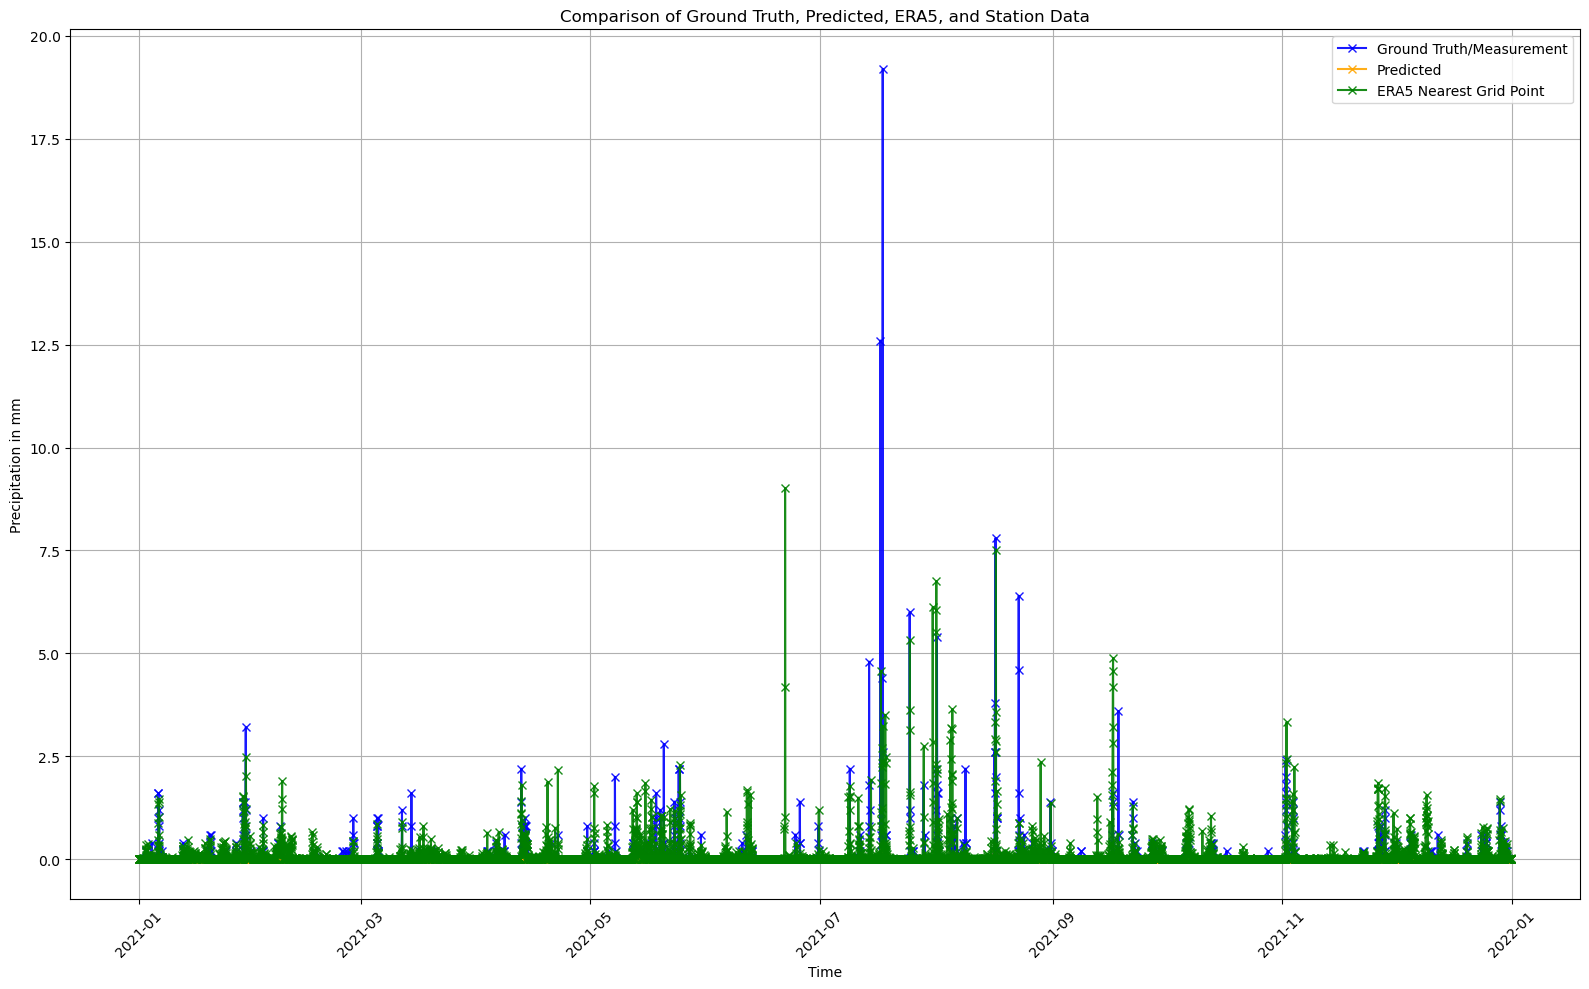

In [67]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-01-01", end_date = "2021-12-31")


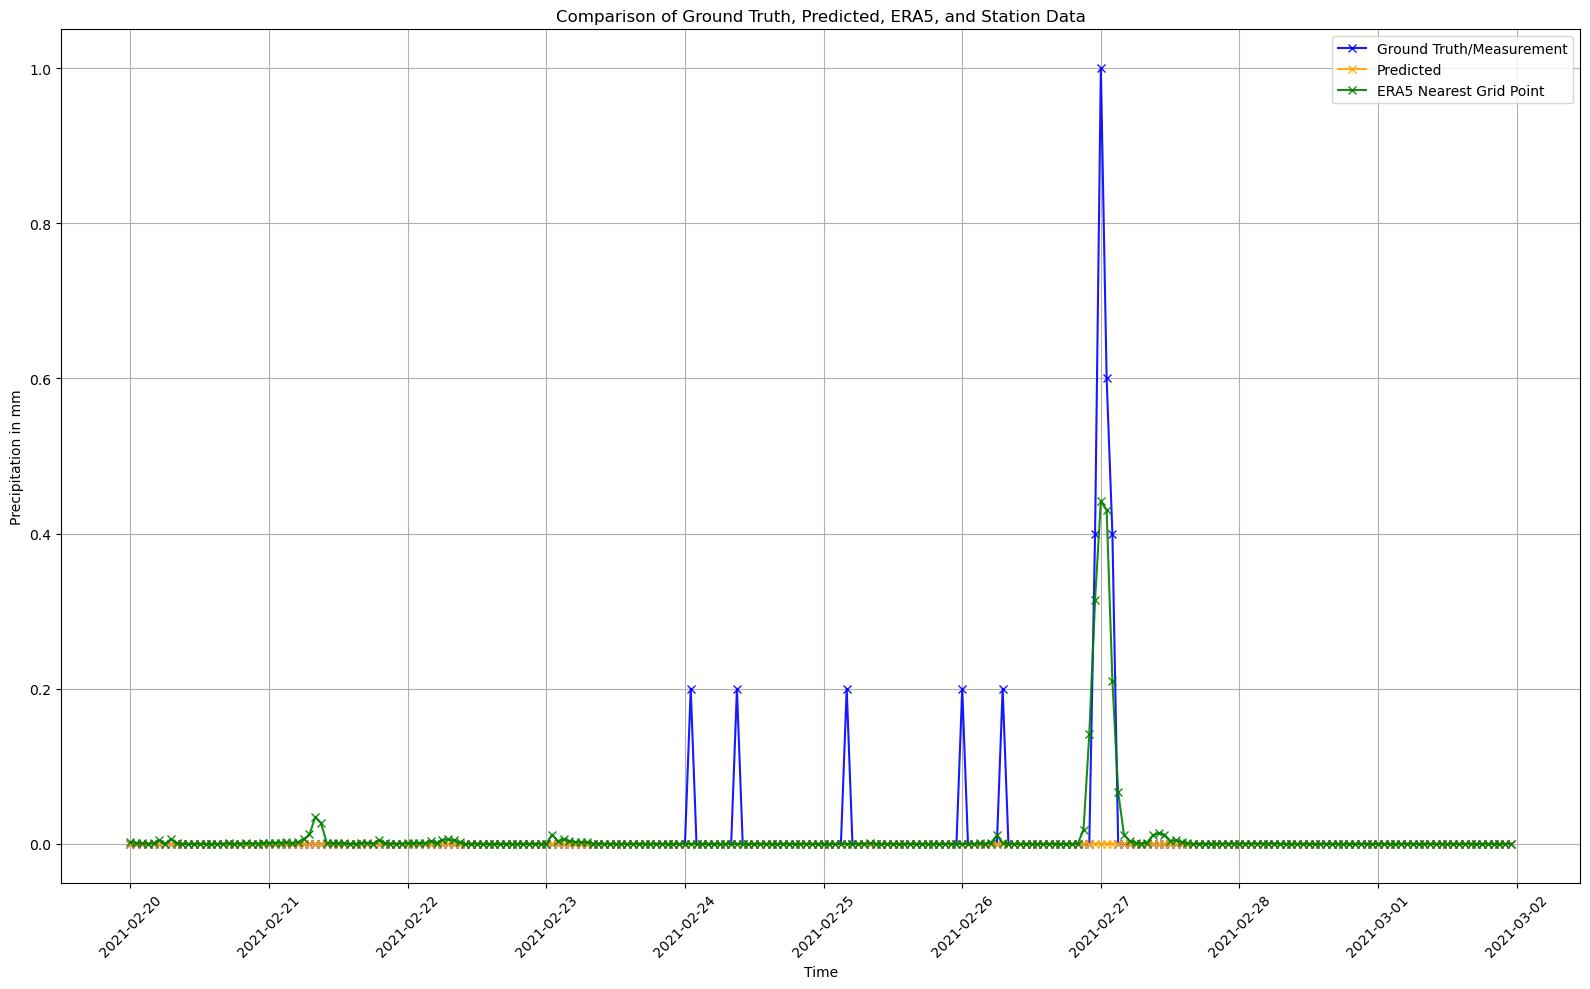

In [70]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-02-20", end_date = "2021-03-01")


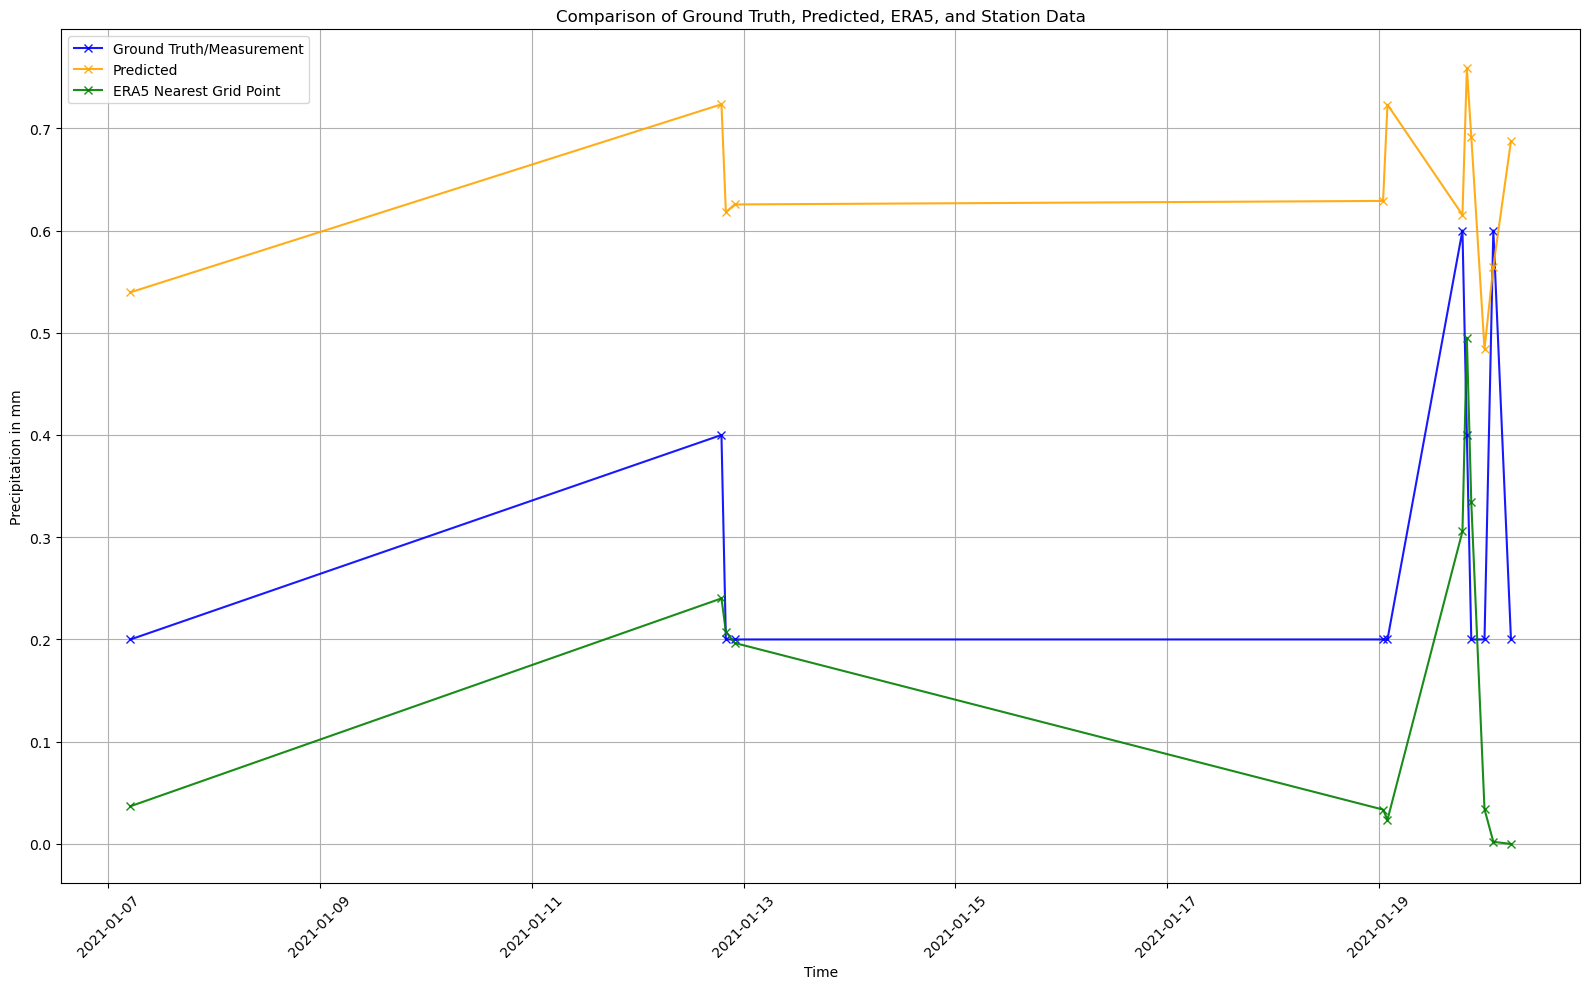

In [51]:

# Usage
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-01-07", end_date = "2021-01-21")


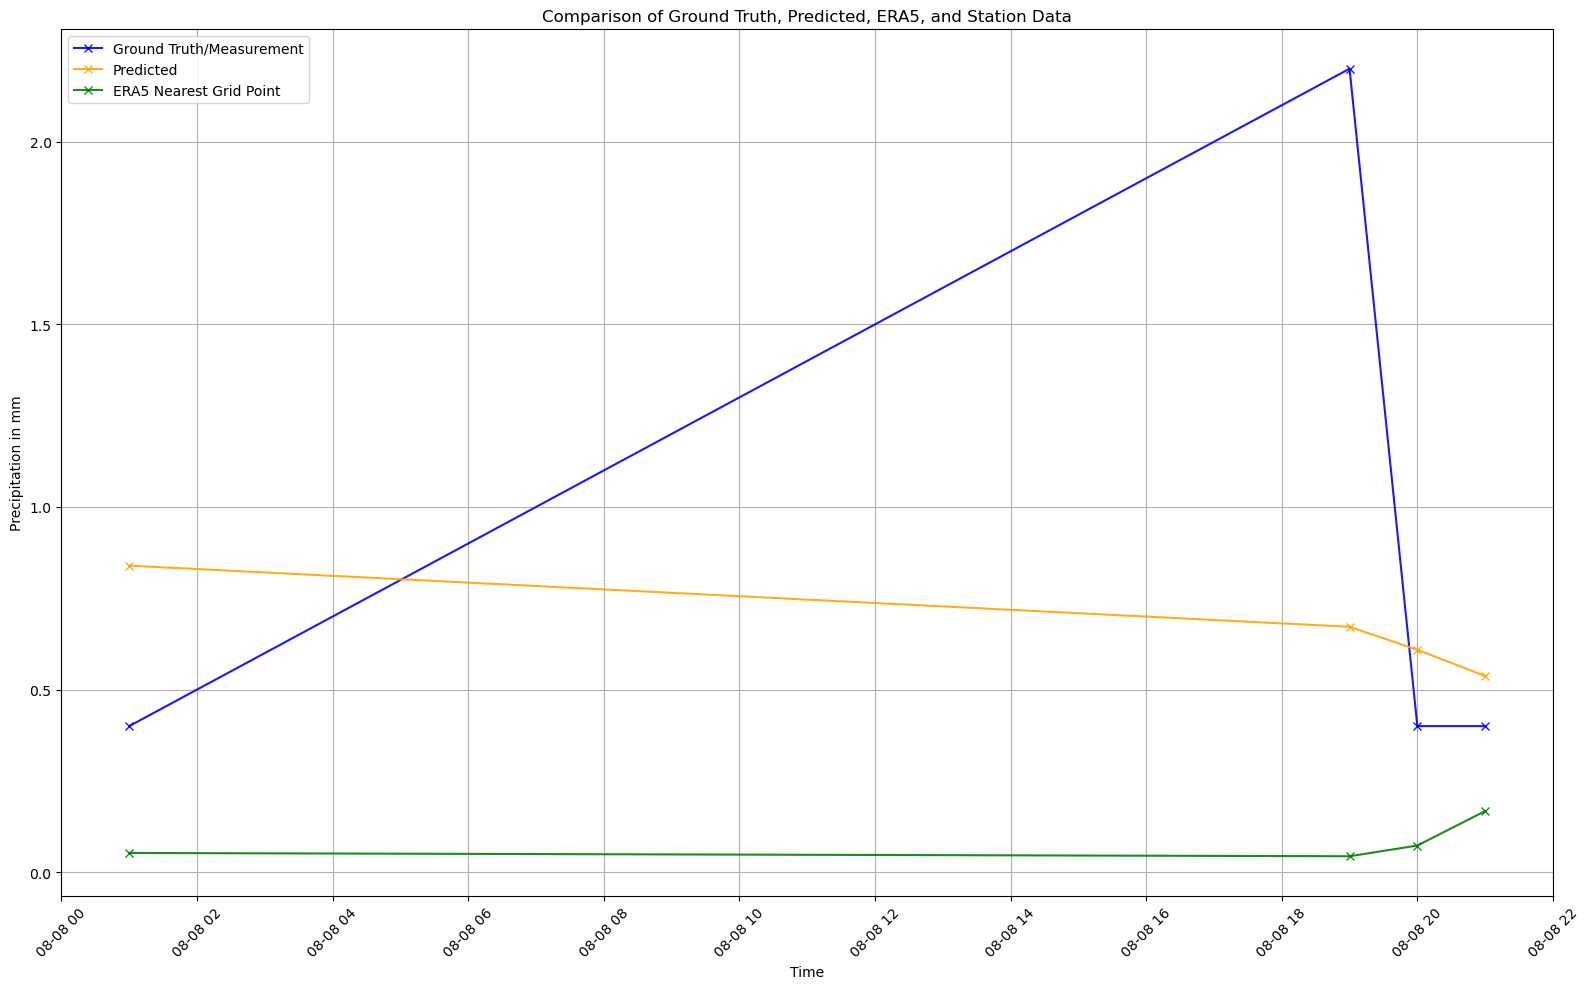

In [52]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid, start_date = "2021-08-08", end_date = "2021-08-08")


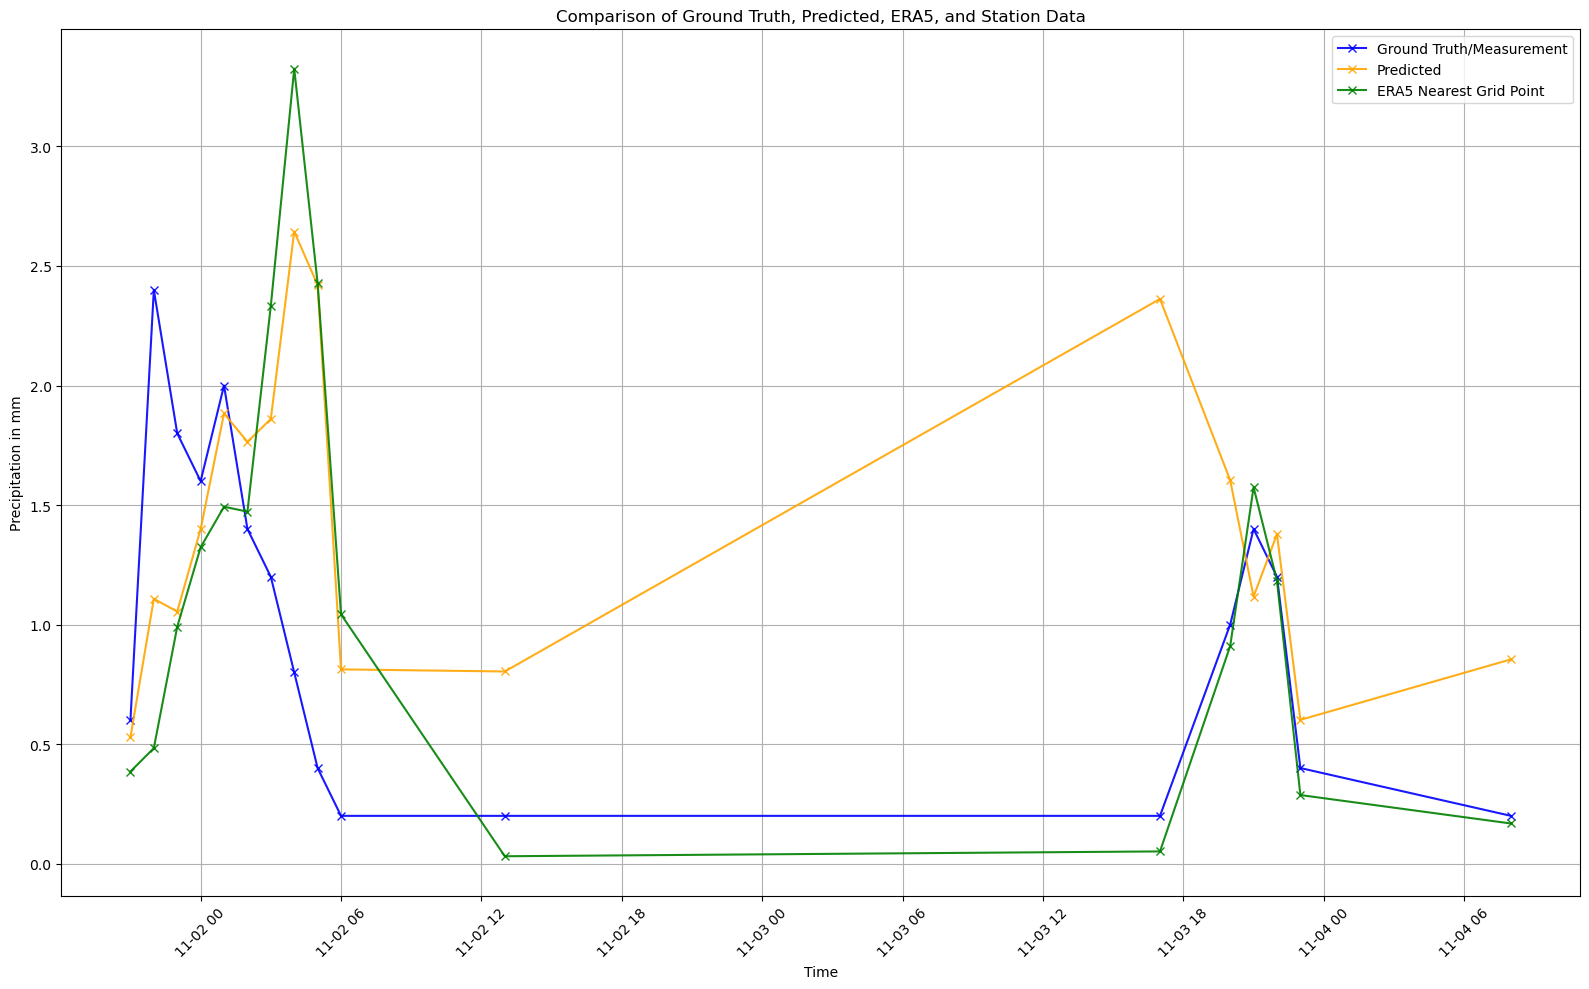

In [53]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid, start_date = "2021-11-01", end_date = "2021-11-05")


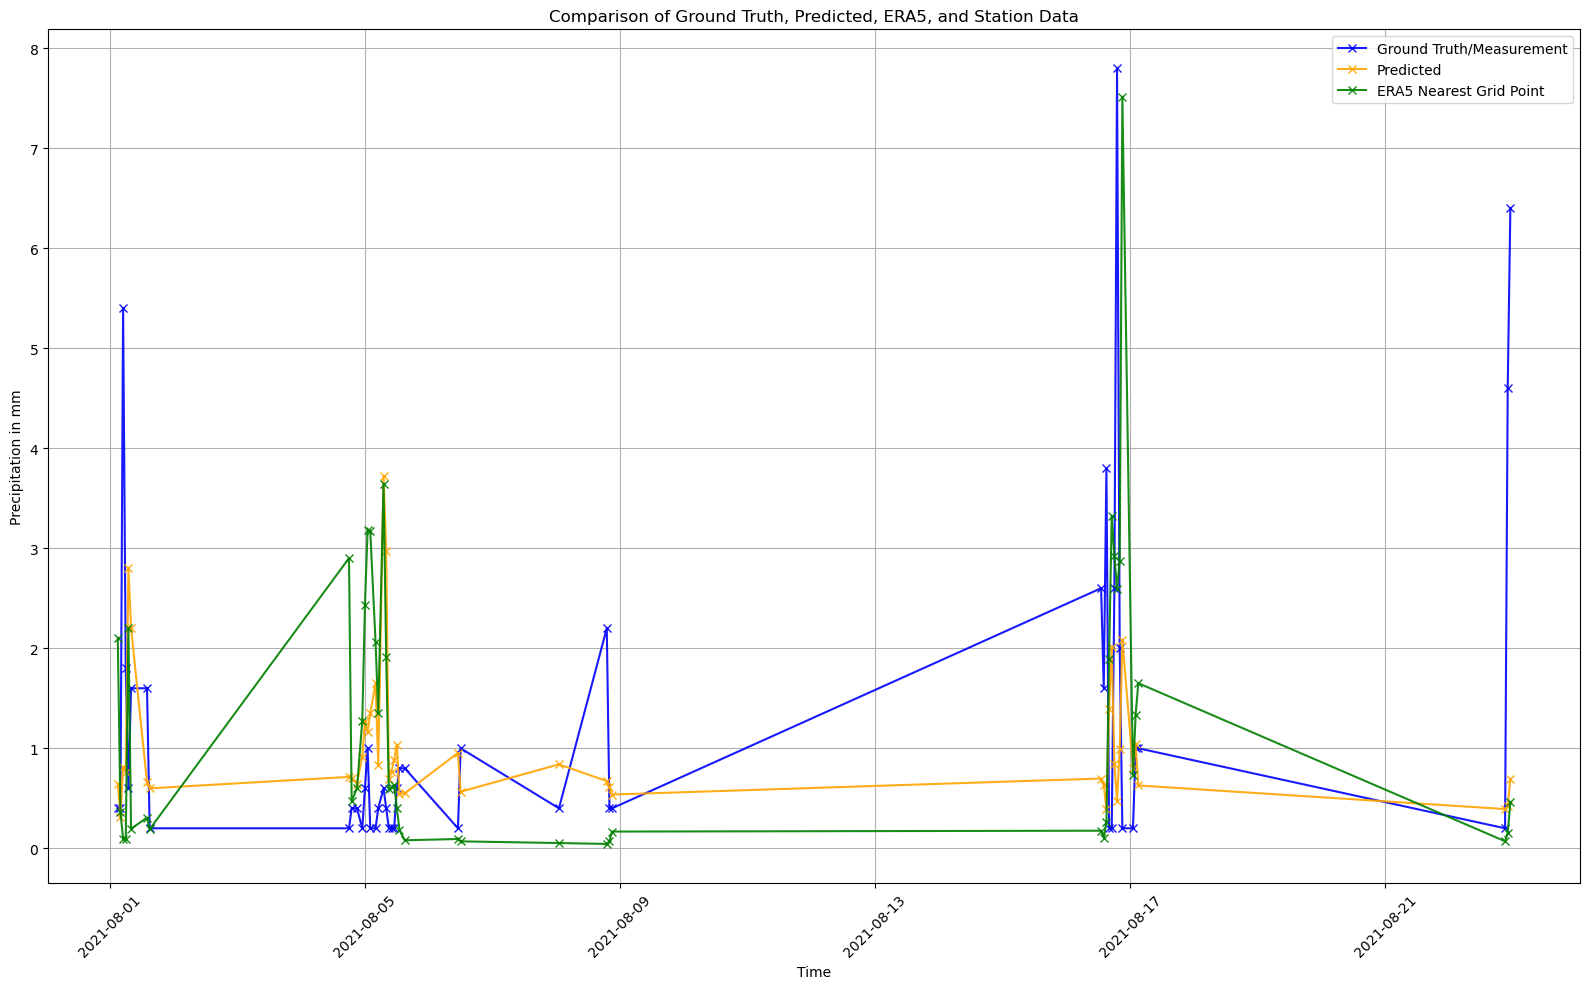

In [54]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-08-01", end_date = "2021-08-22")


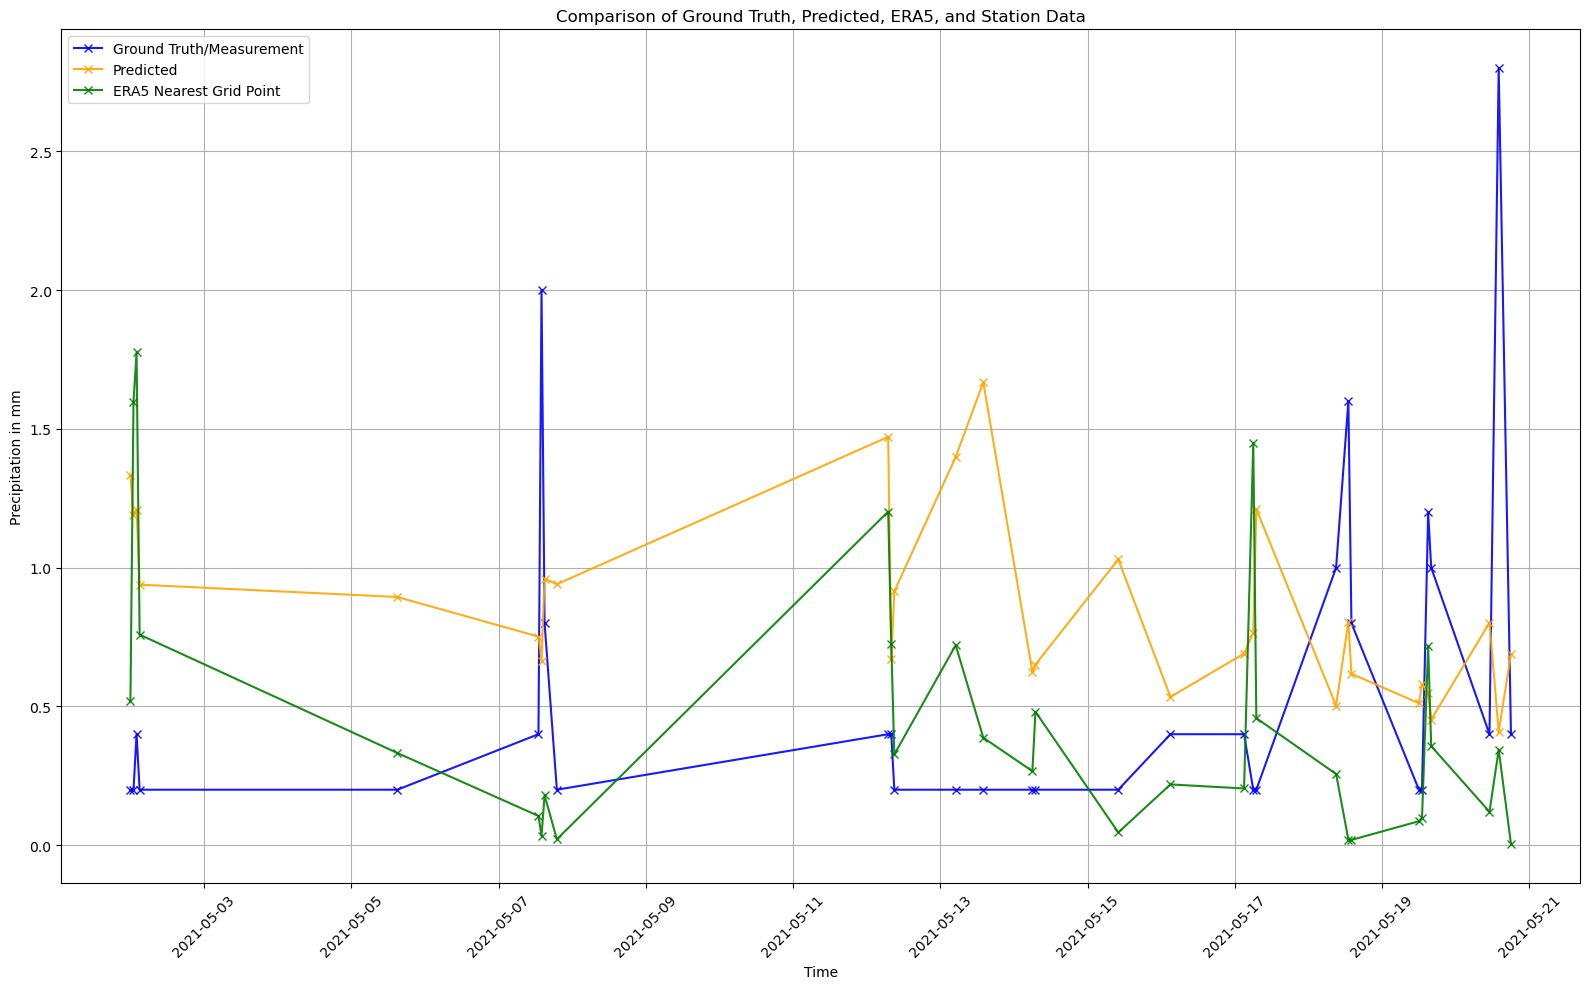

In [55]:
improved_plot_datasets_3(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid,  start_date = "2021-05-01", end_date = "2021-05-21")


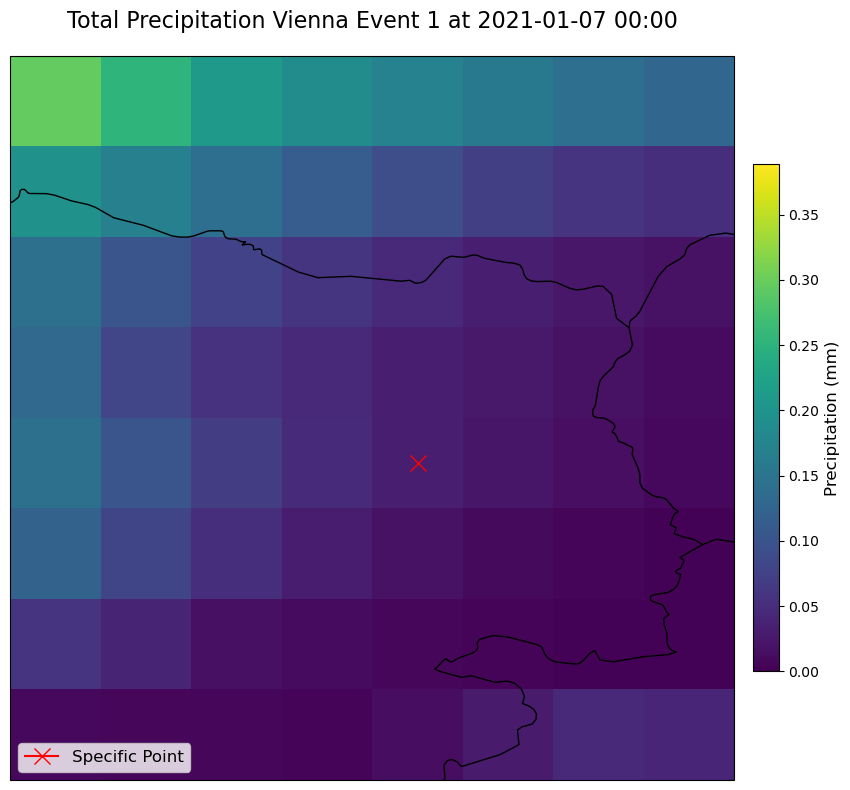

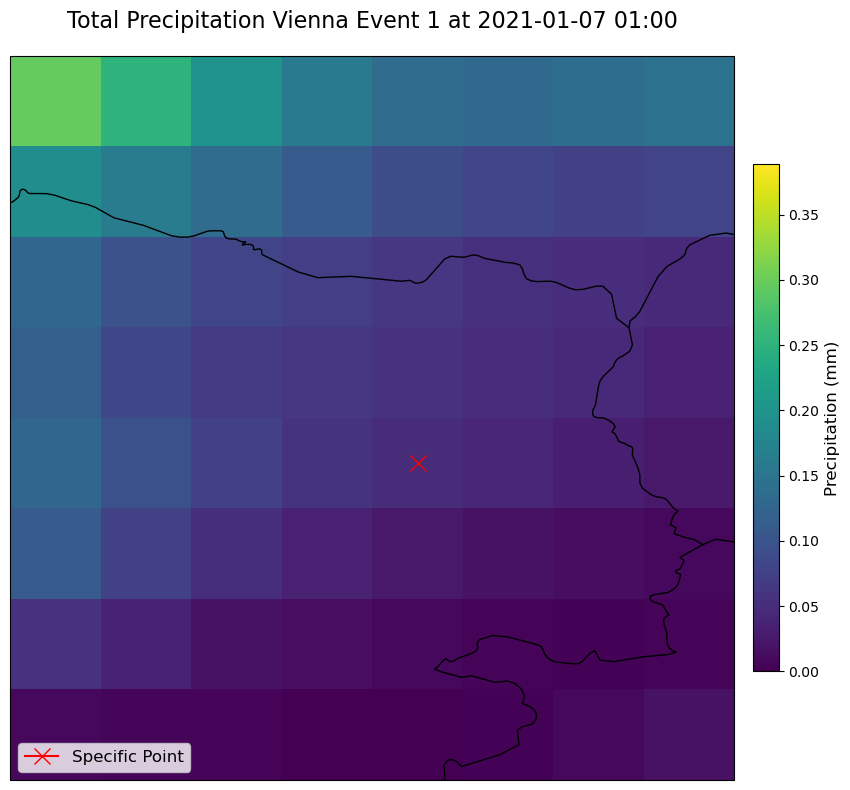

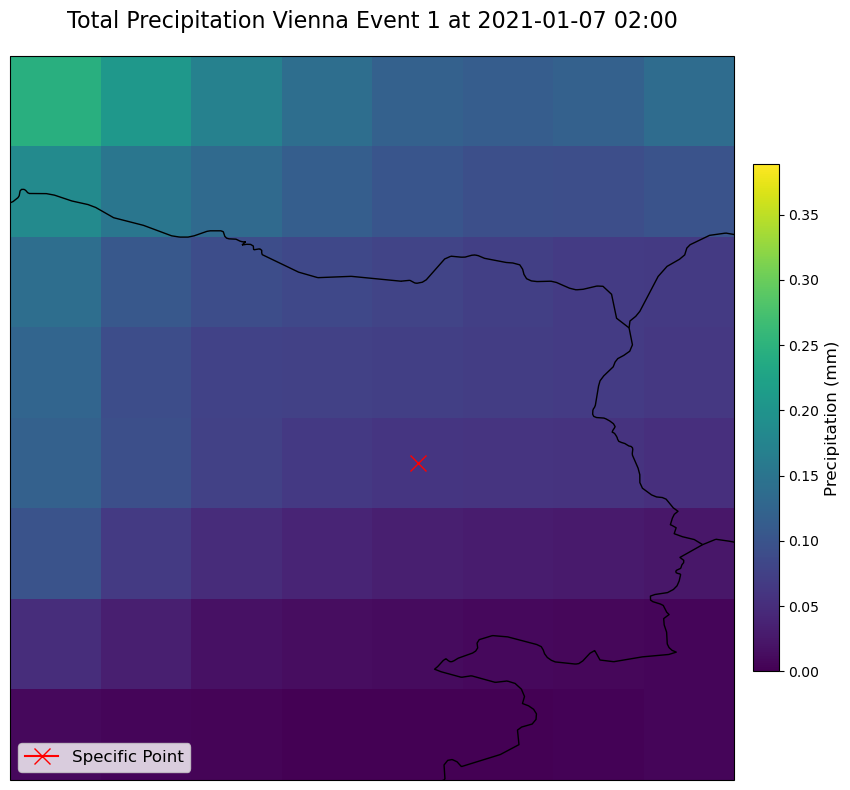

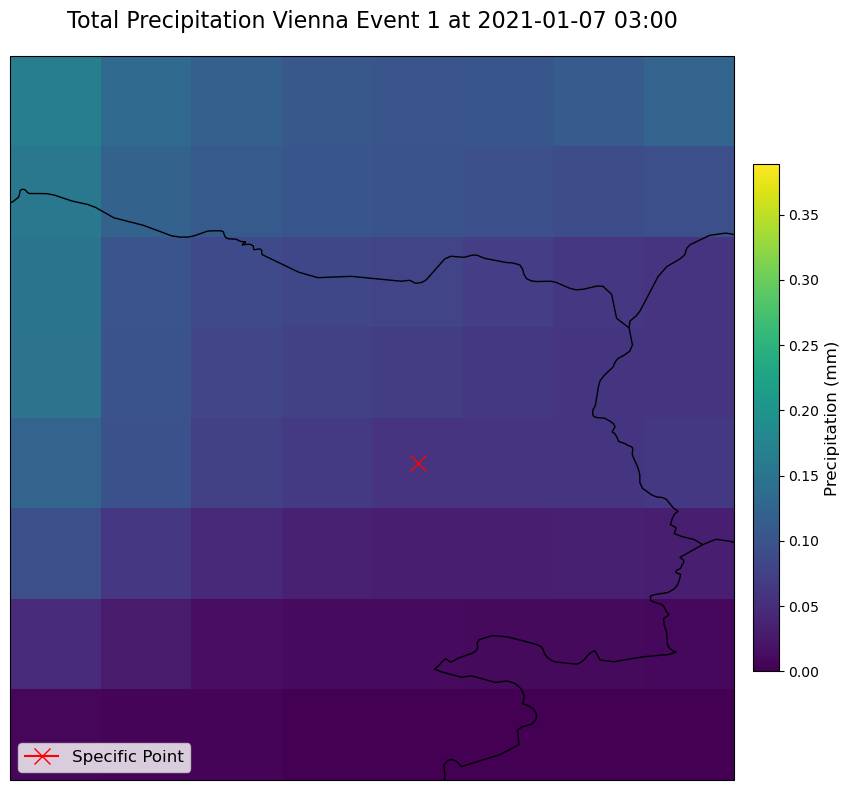

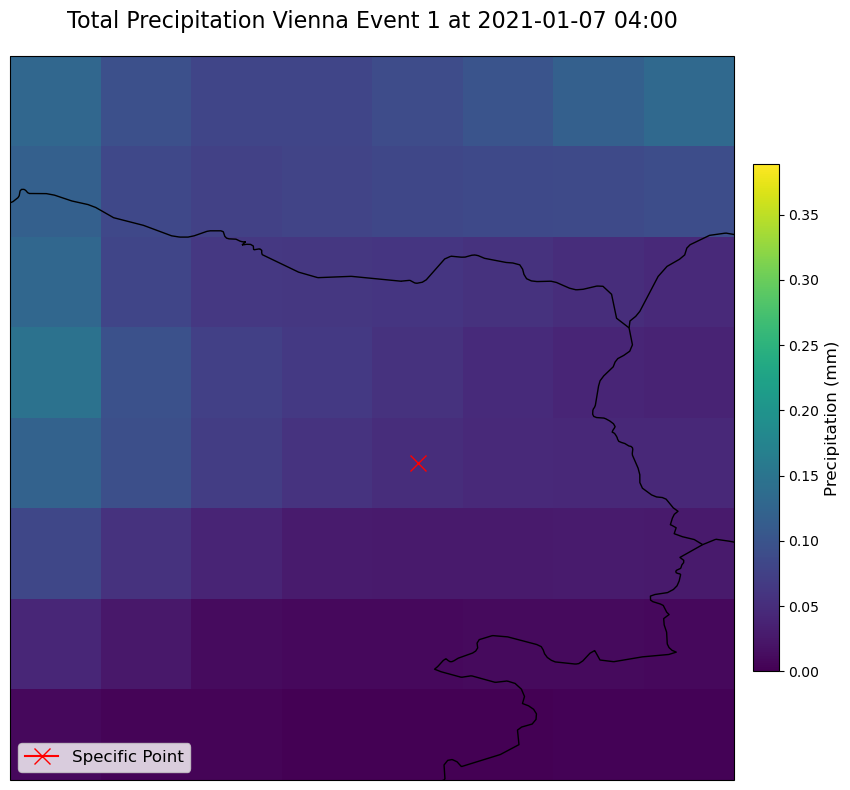

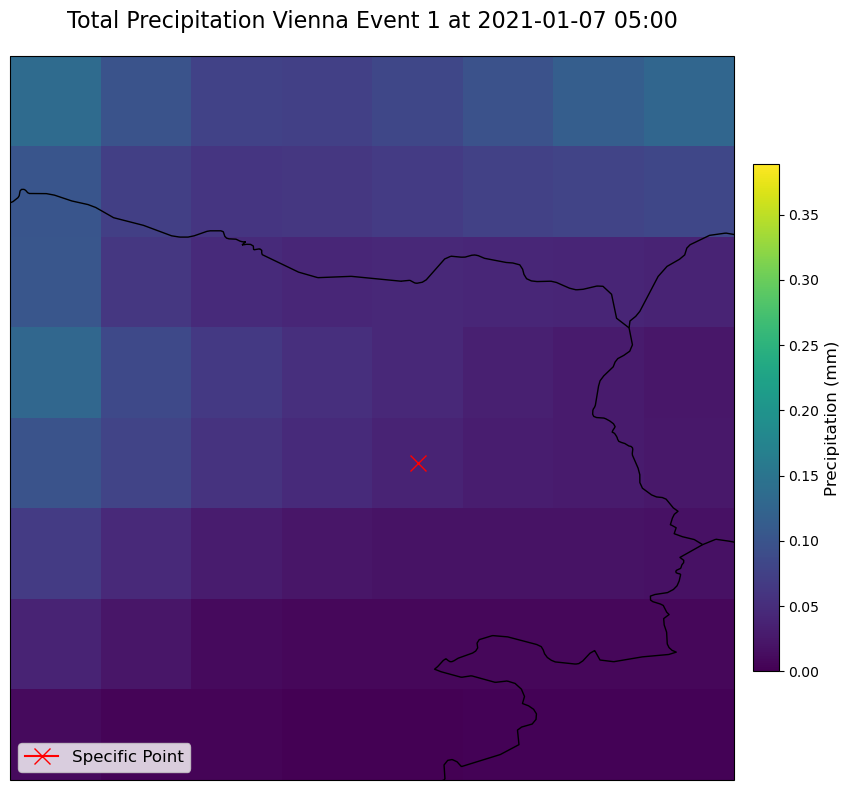

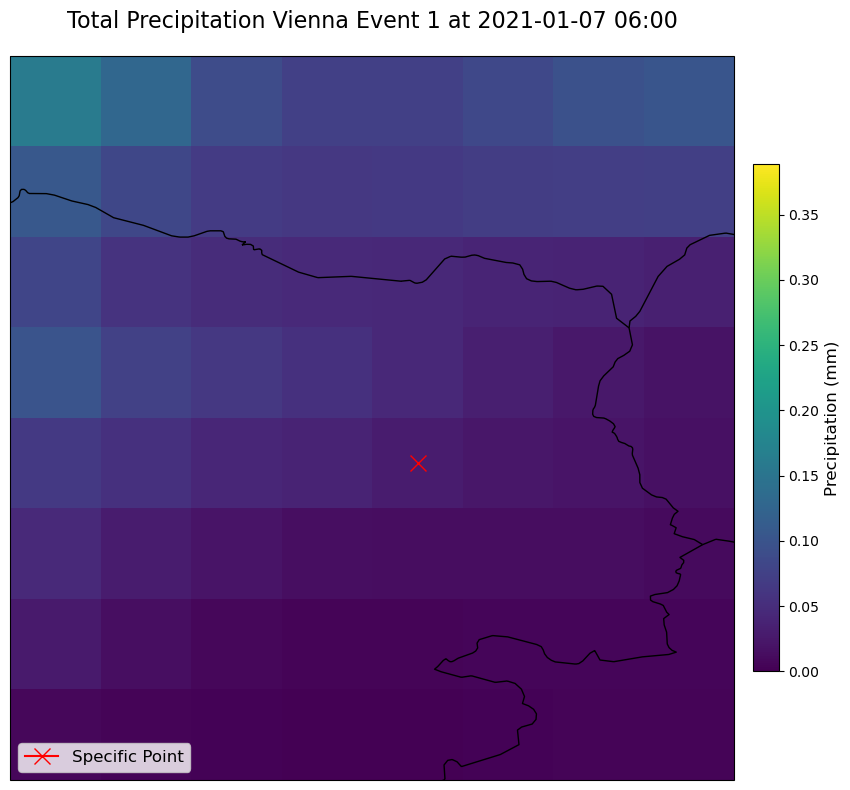

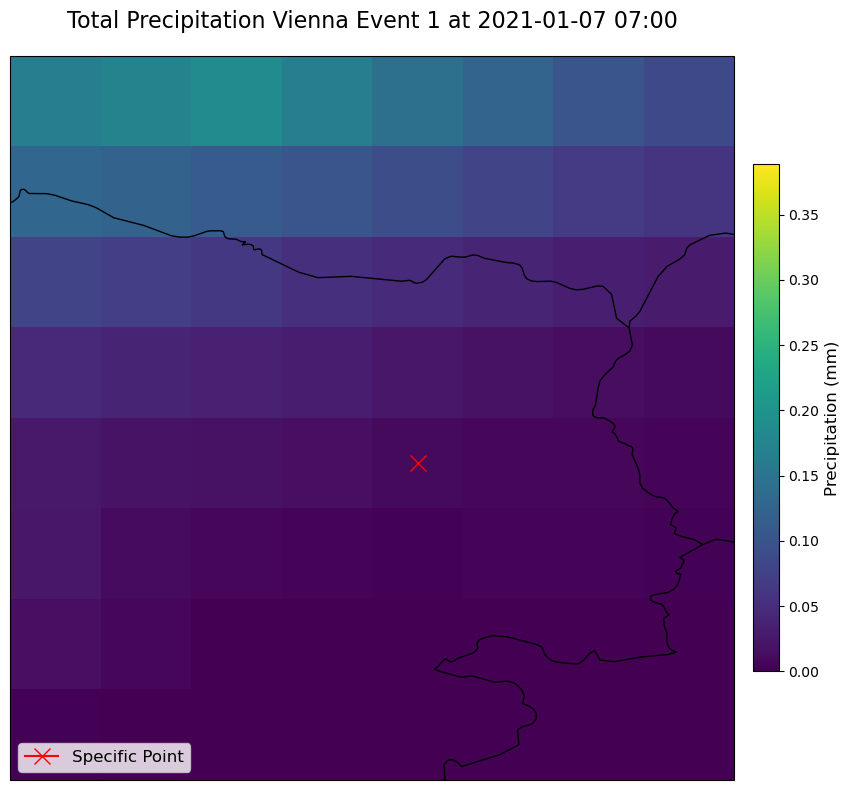

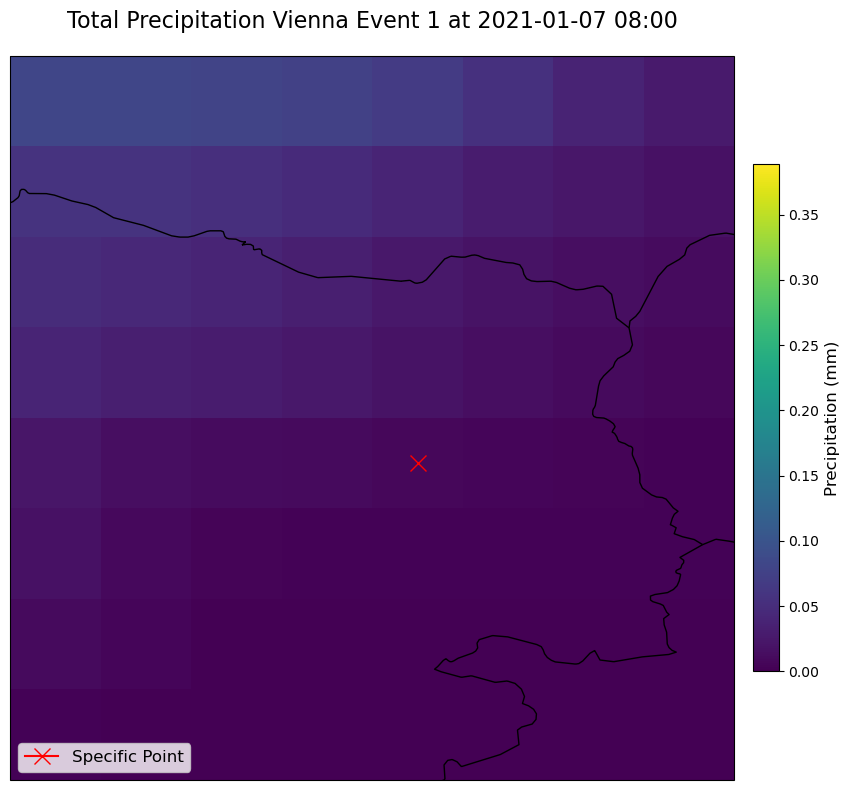

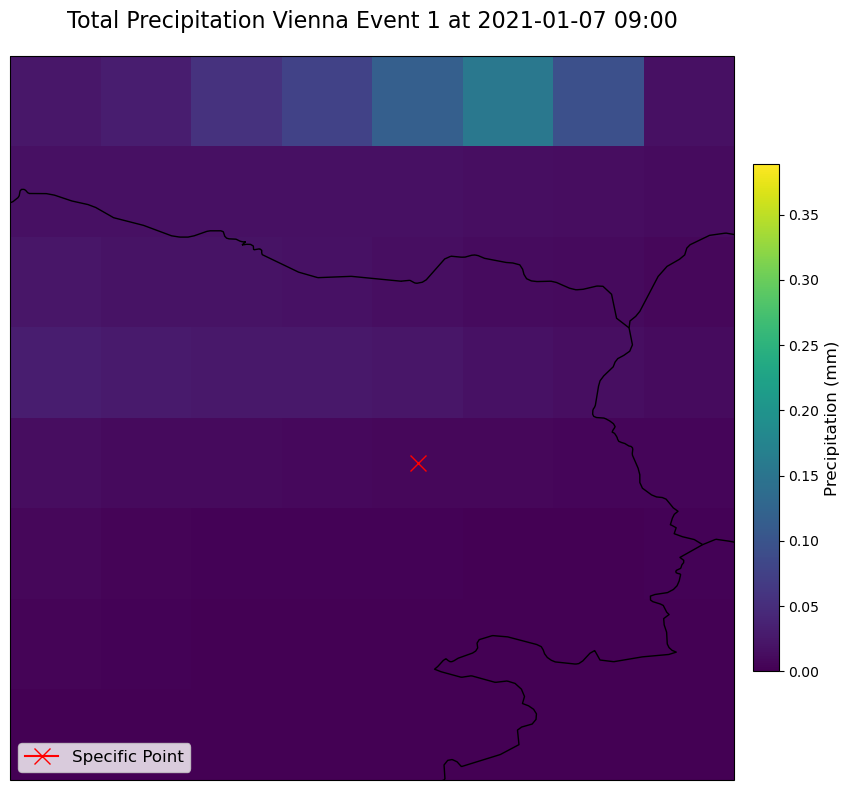

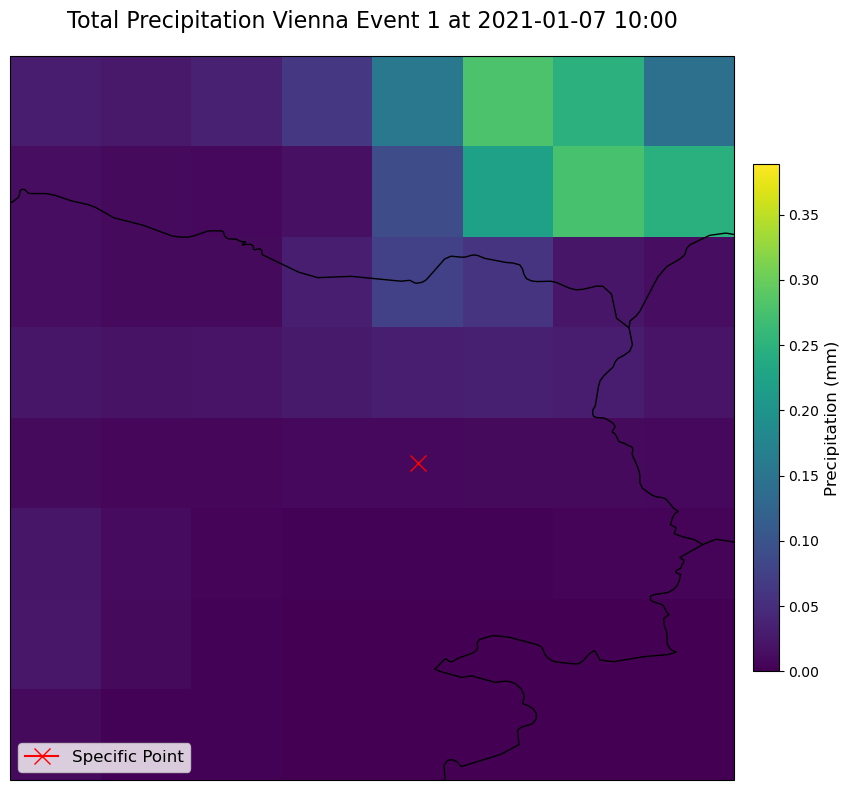

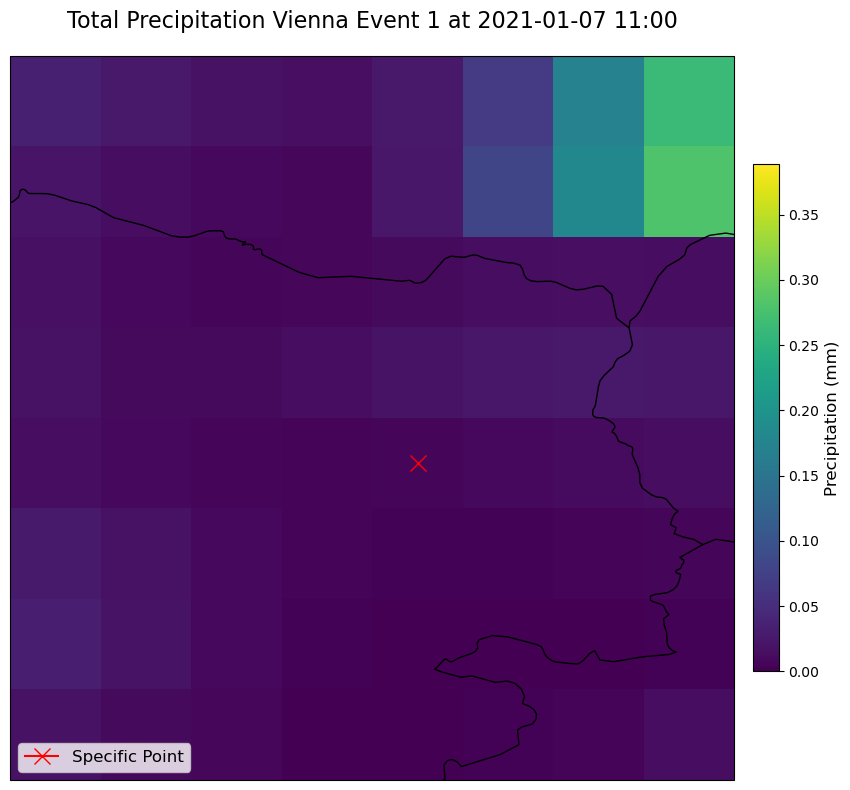

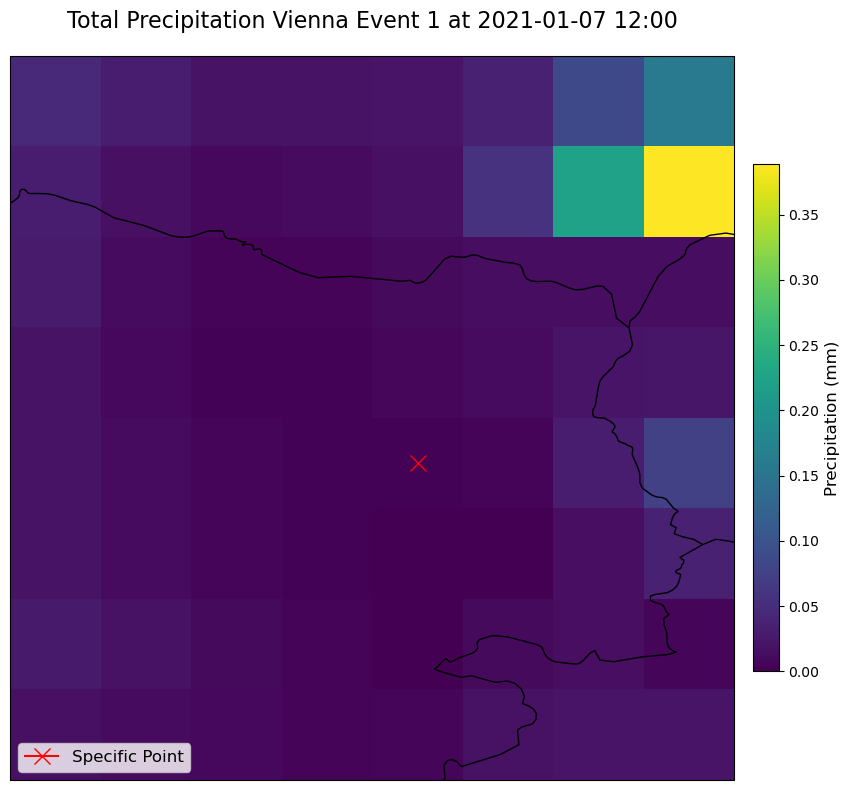

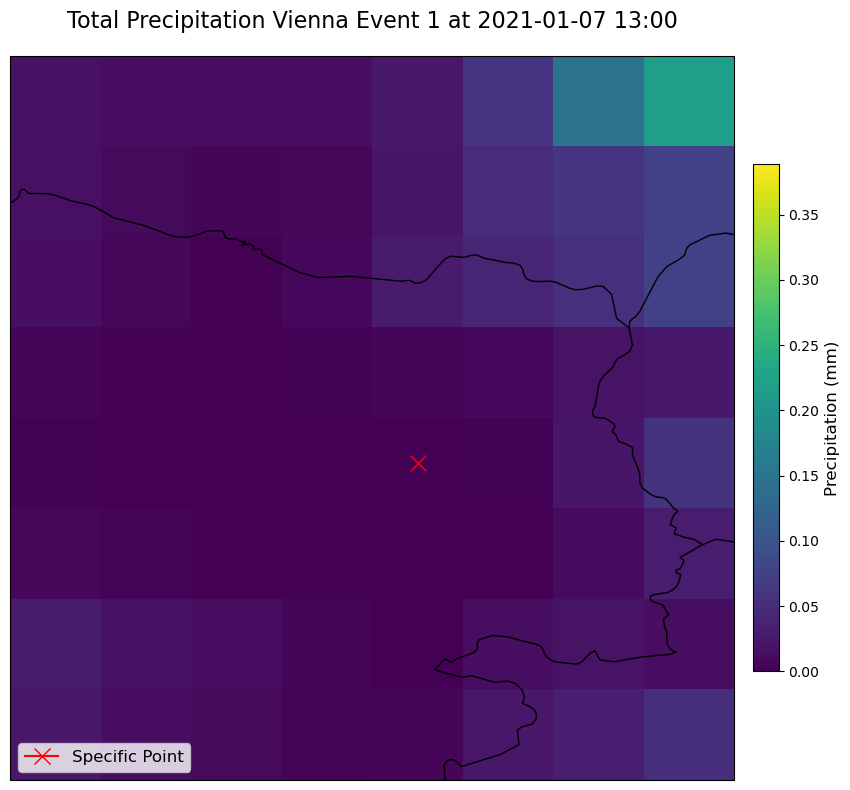

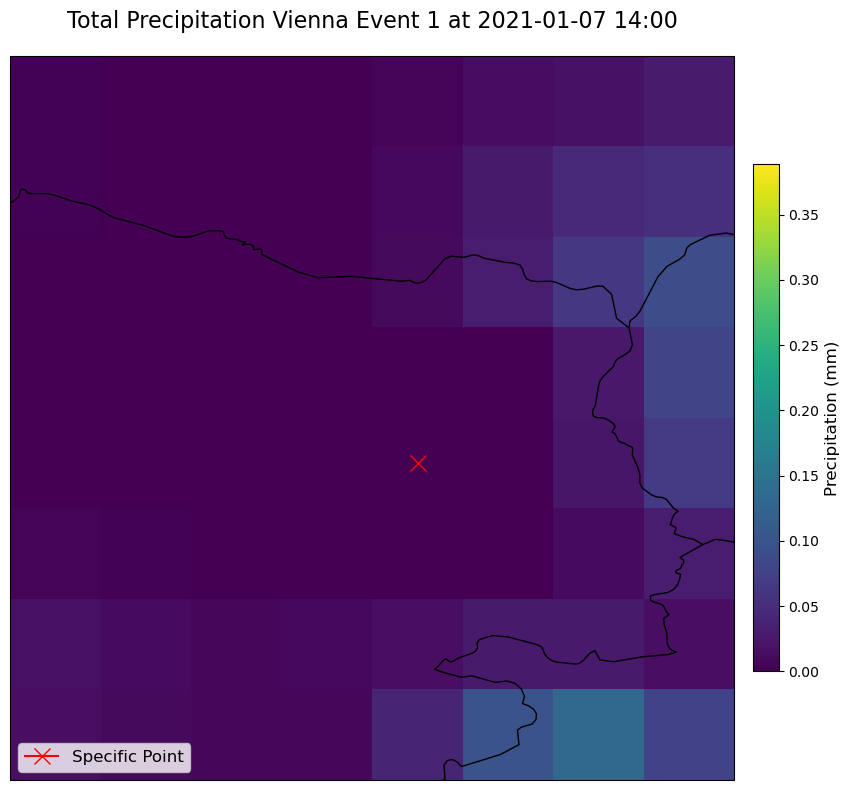

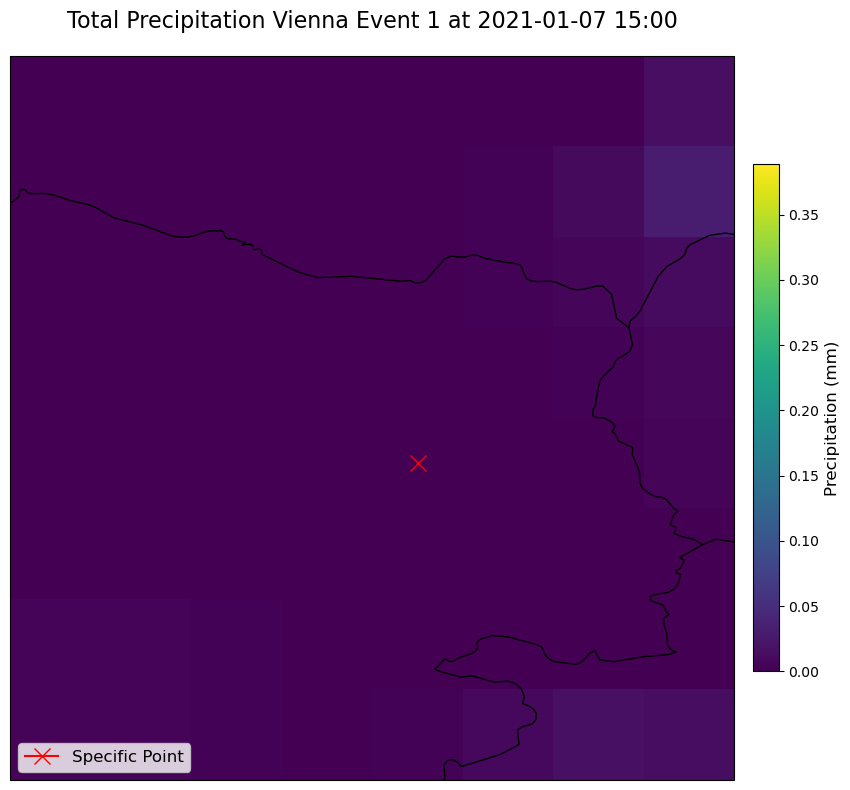

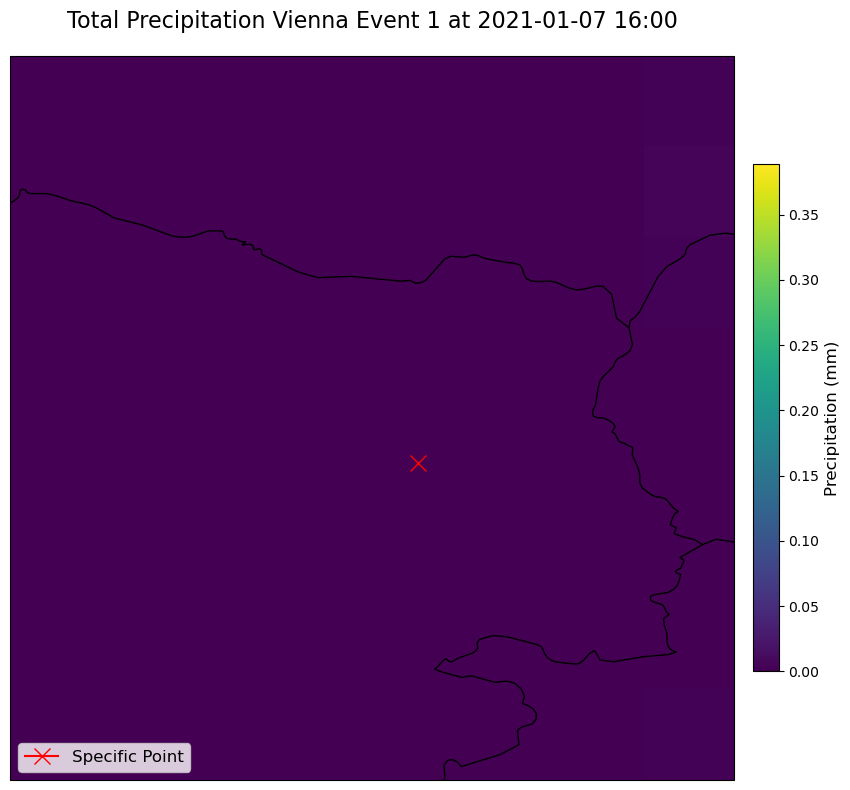

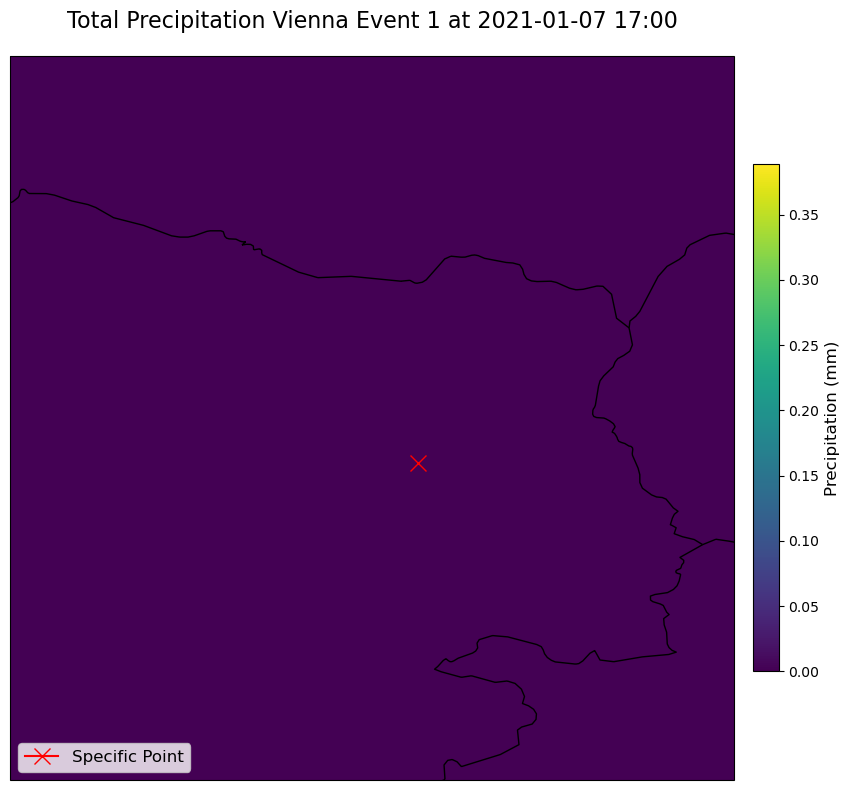

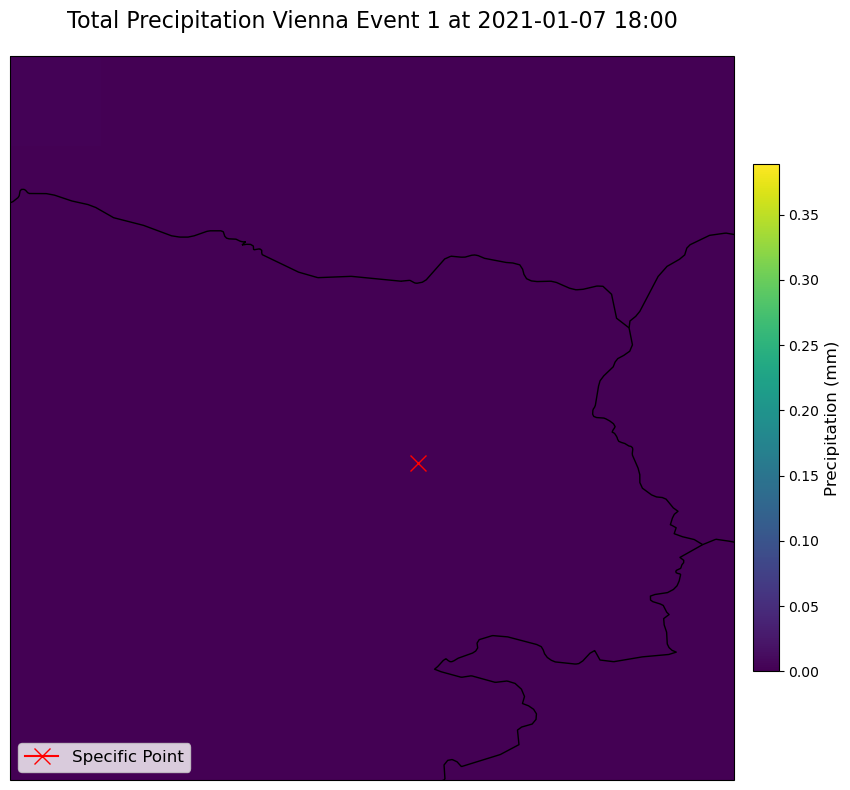

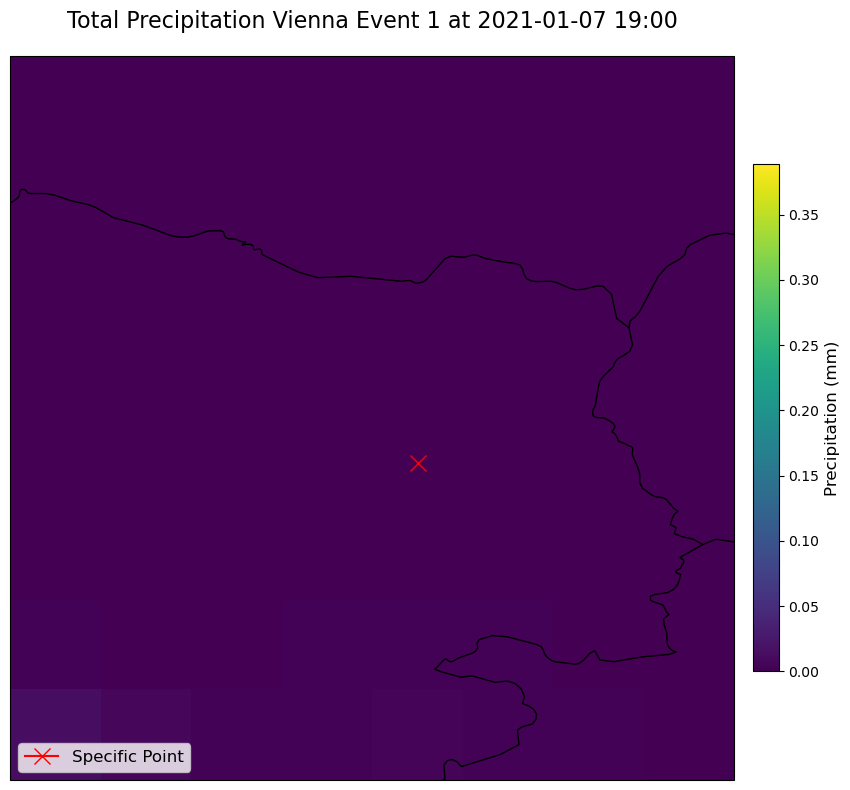

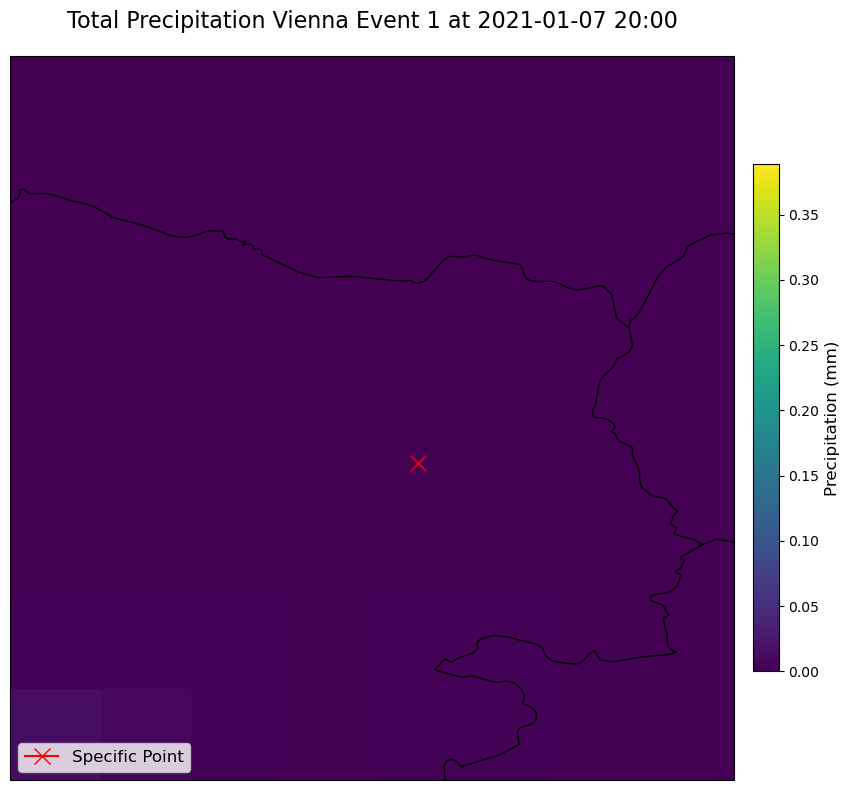

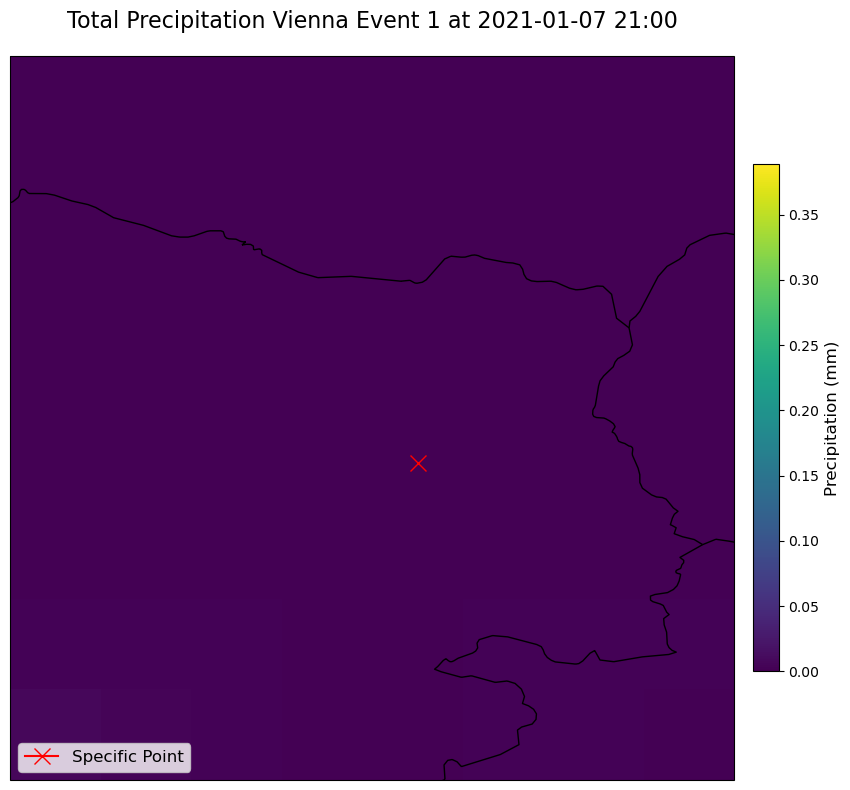

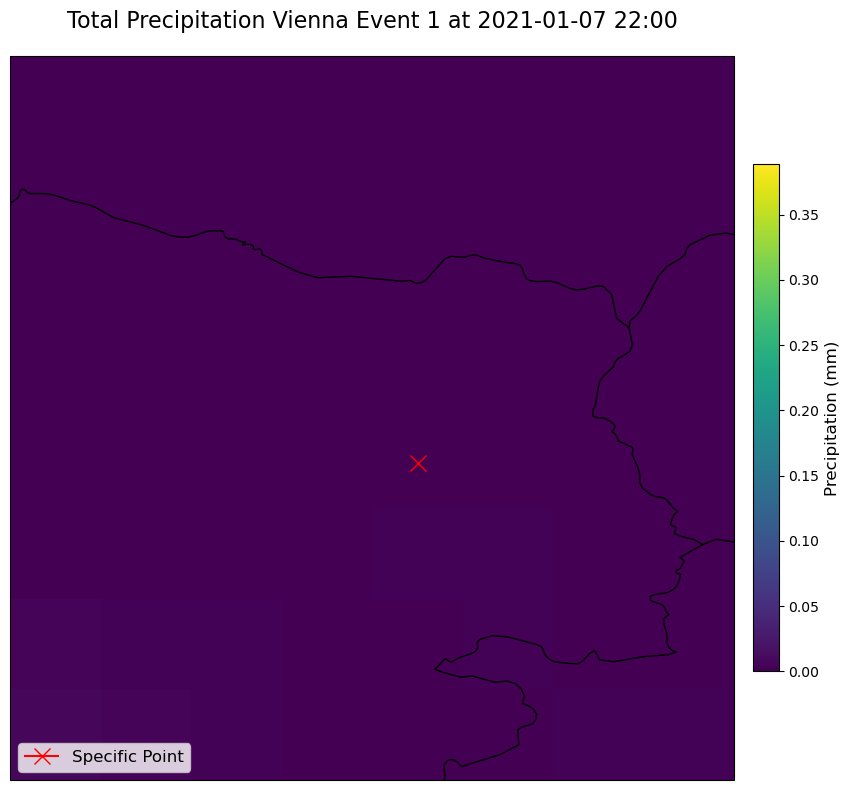

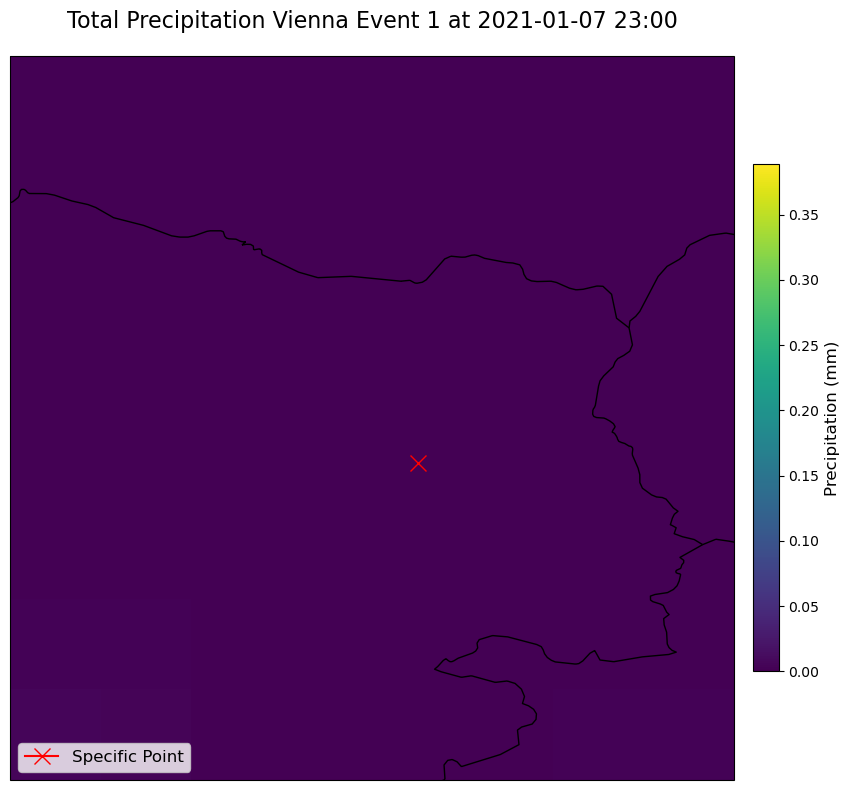

In [39]:
plot_era5_precipitation(
    dataset_path="Training_Vienna/new_2021train/tp/era5_cropped_tipping.nc",
    variable='tp',
    point_coords=(16.3609 , 48.2303),
    time_range=("2021-01-07 00:00", "2021-01-07 23:00"),
    title_base='Total Precipitation Vienna Event 1',
    cmap='viridis'
)



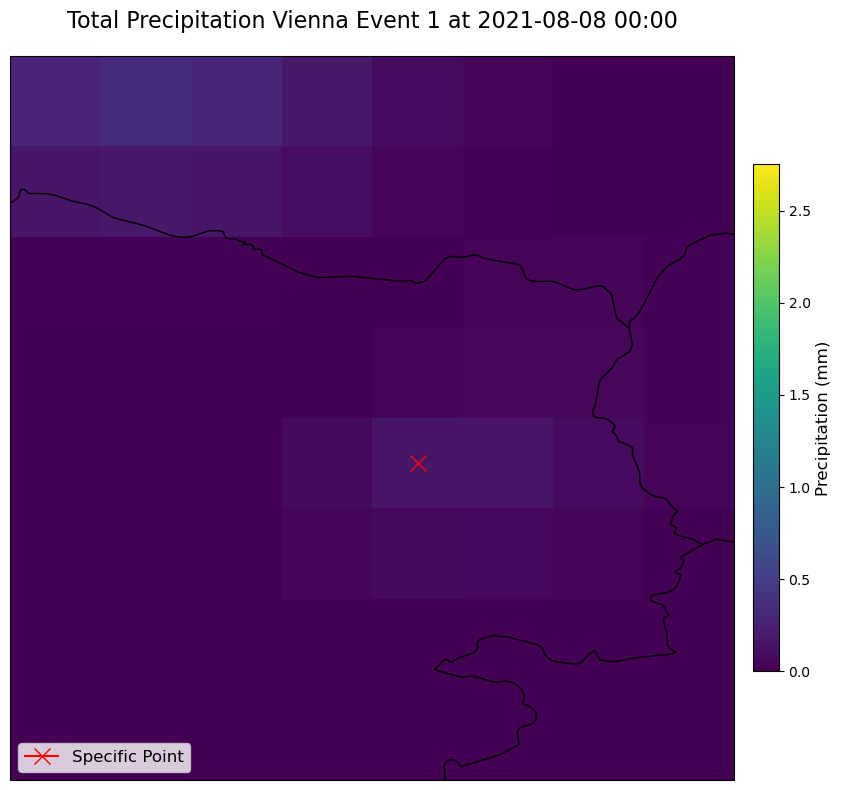

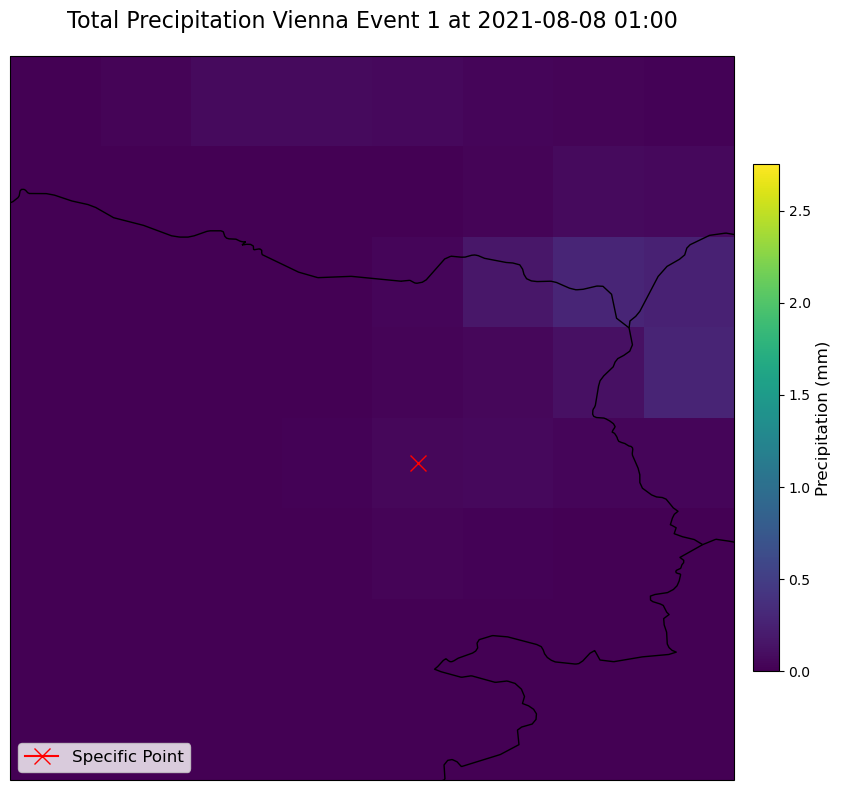

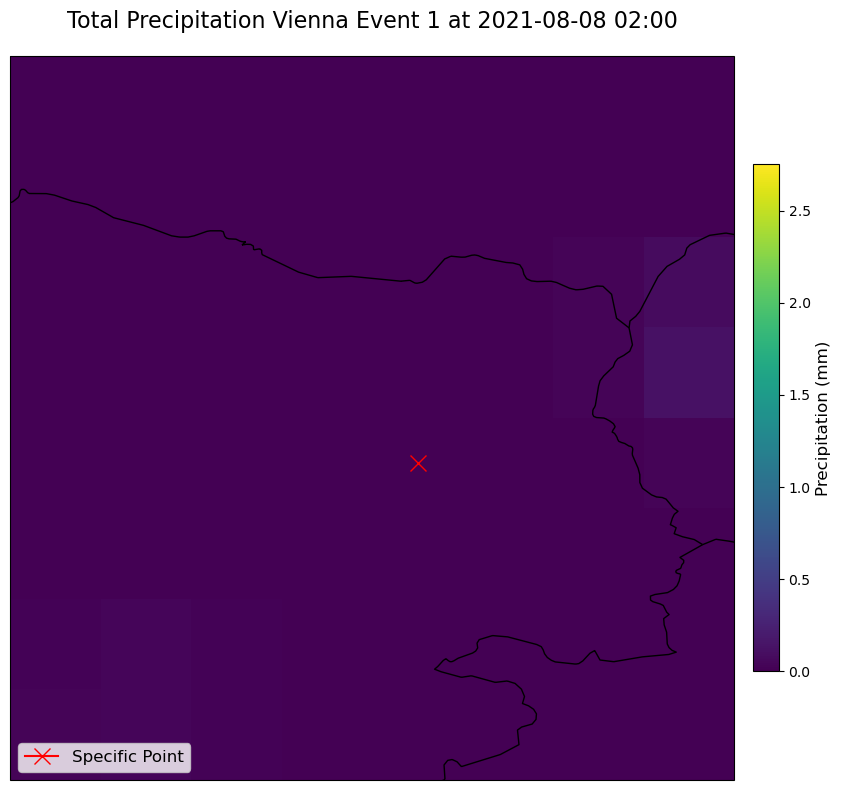

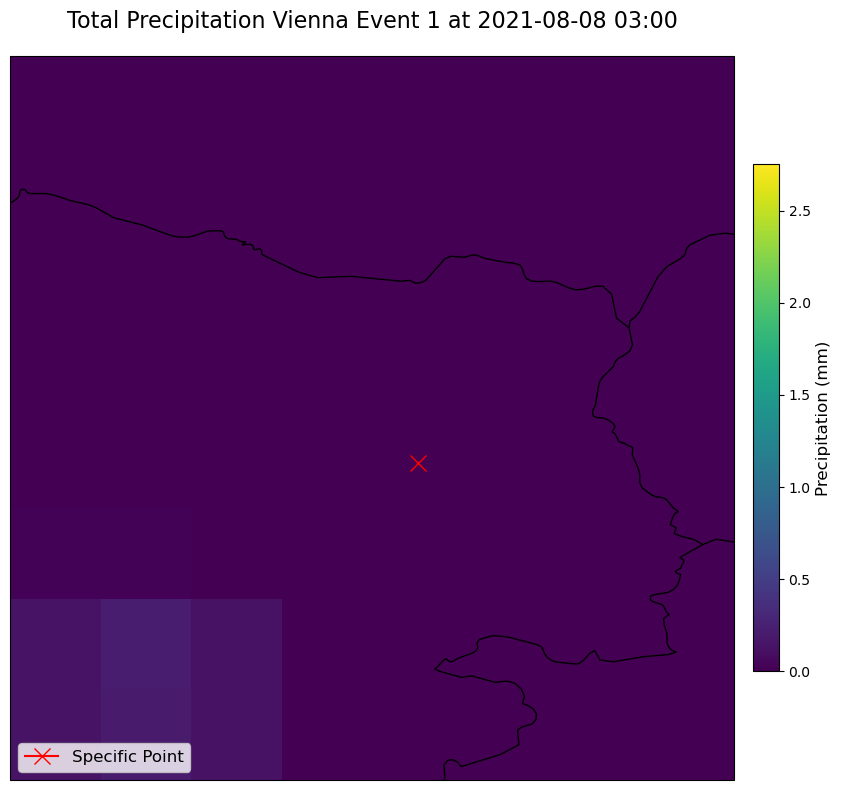

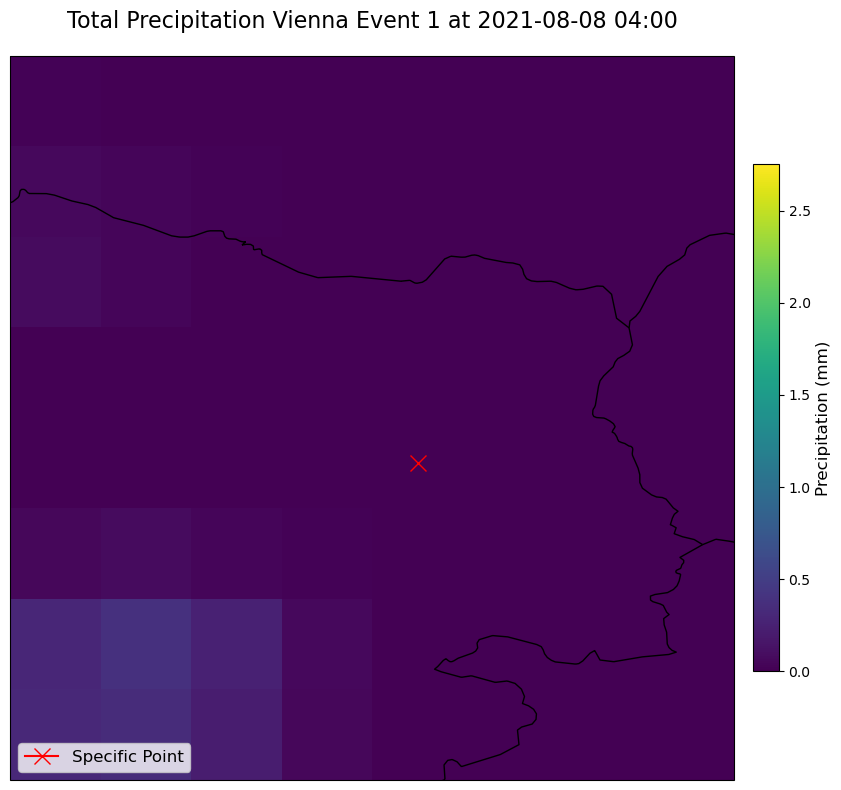

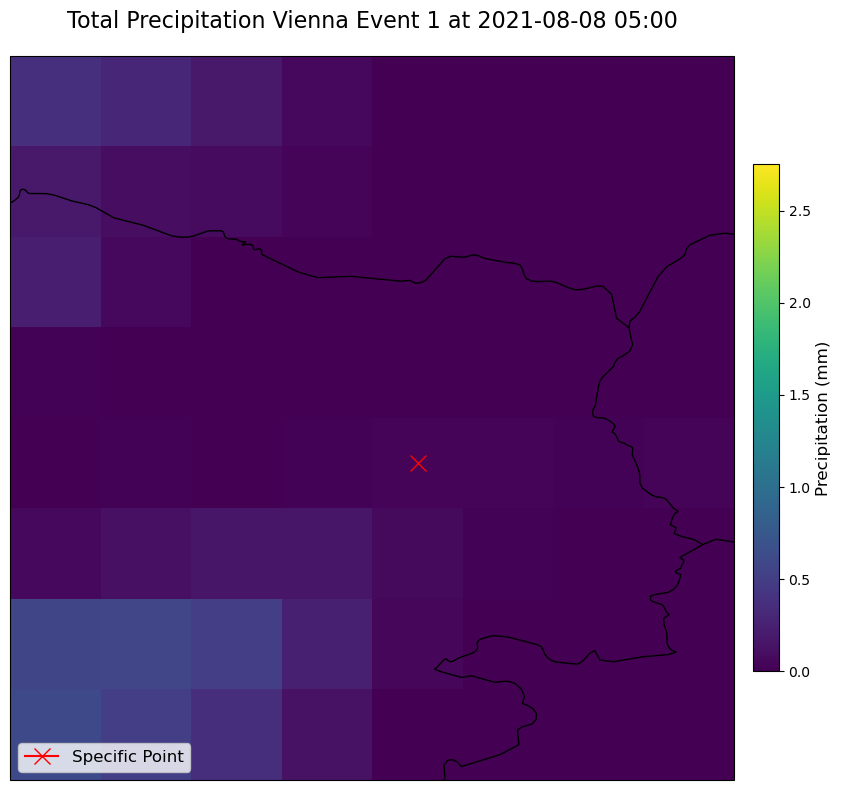

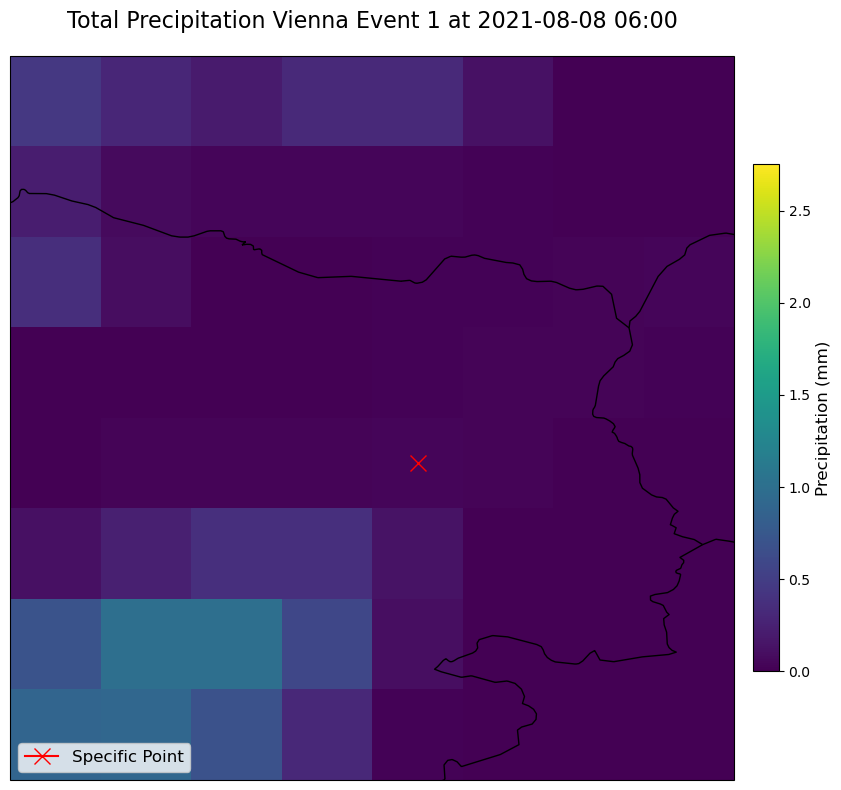

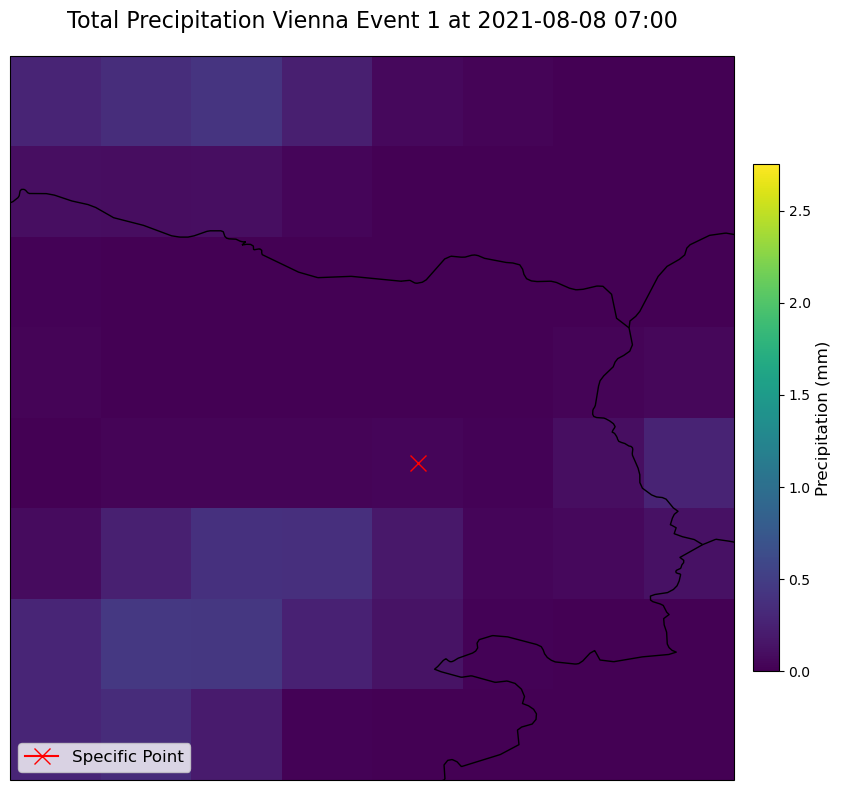

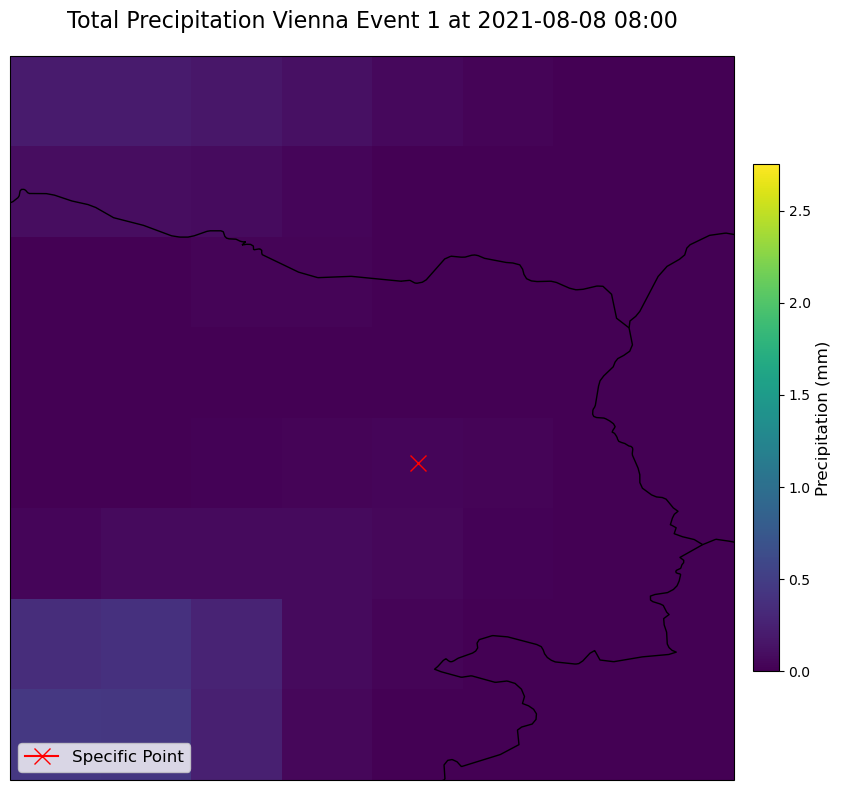

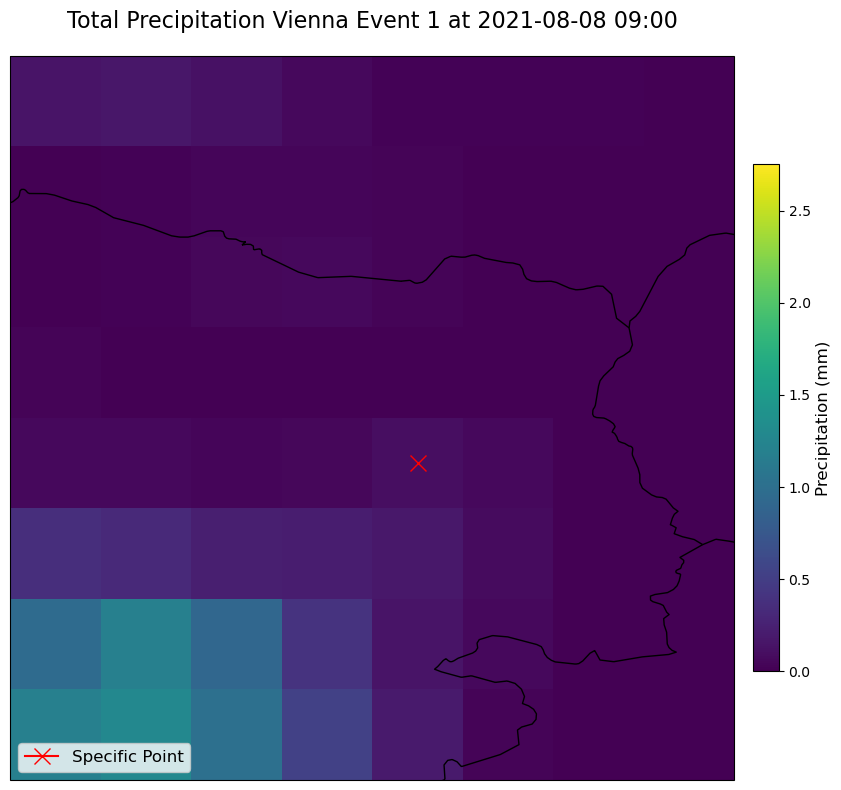

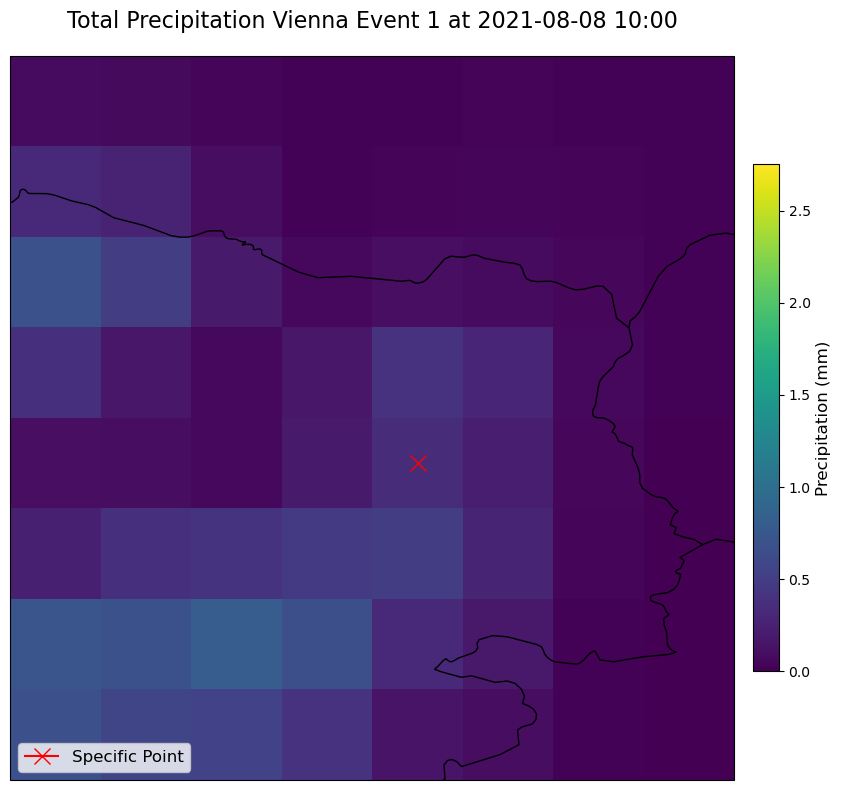

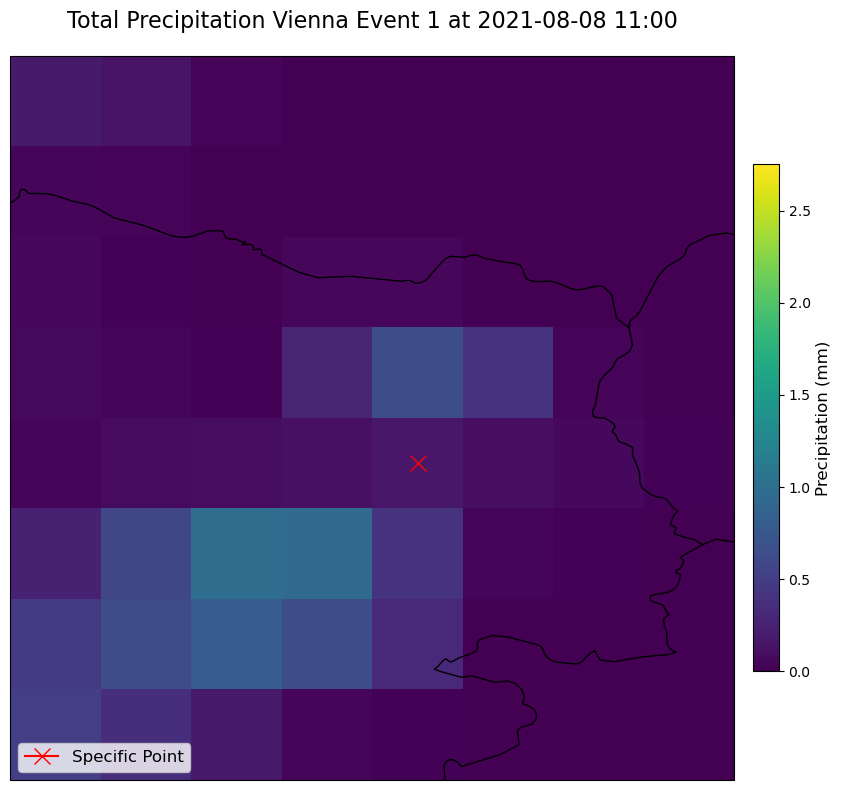

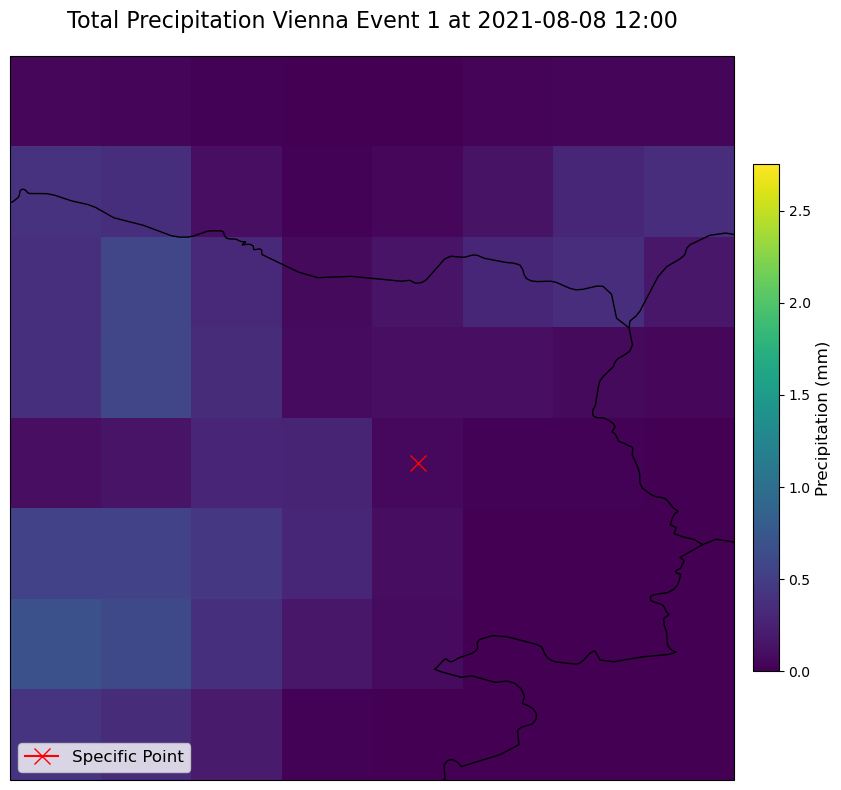

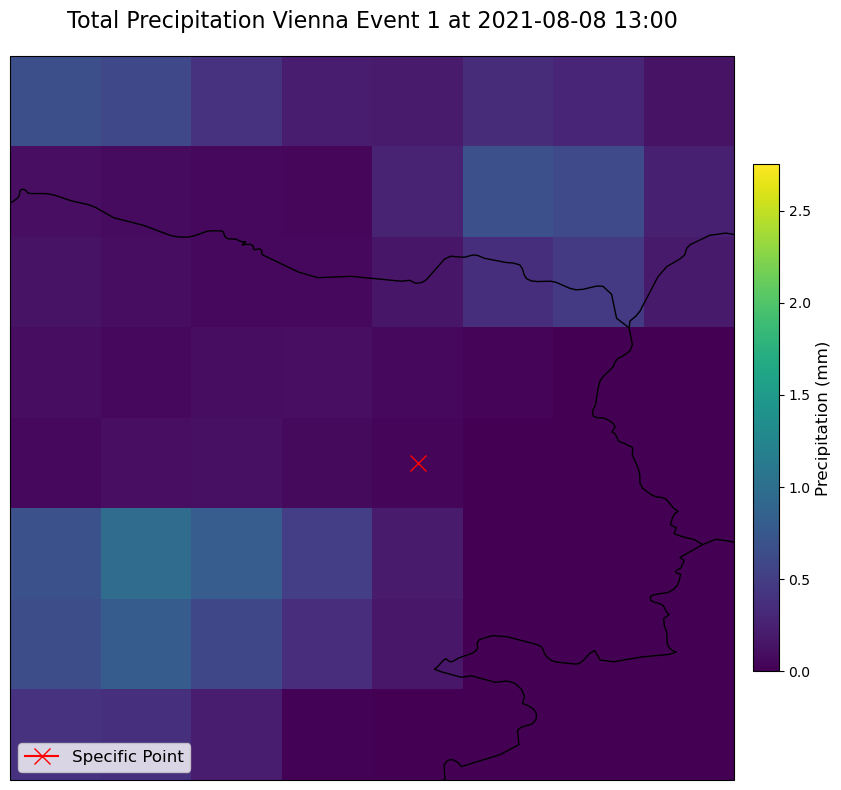

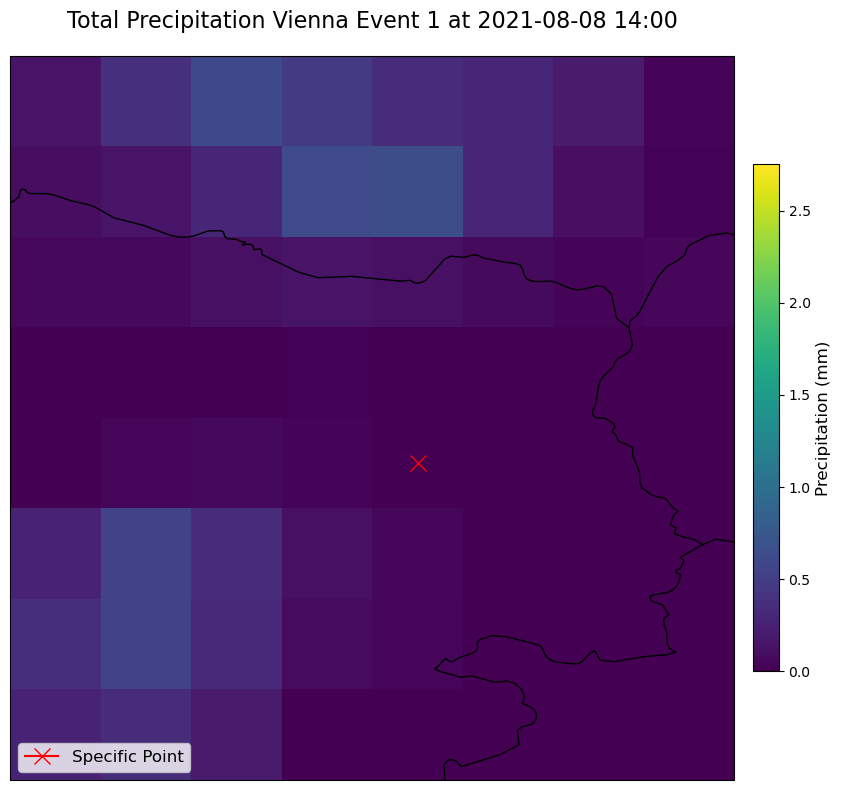

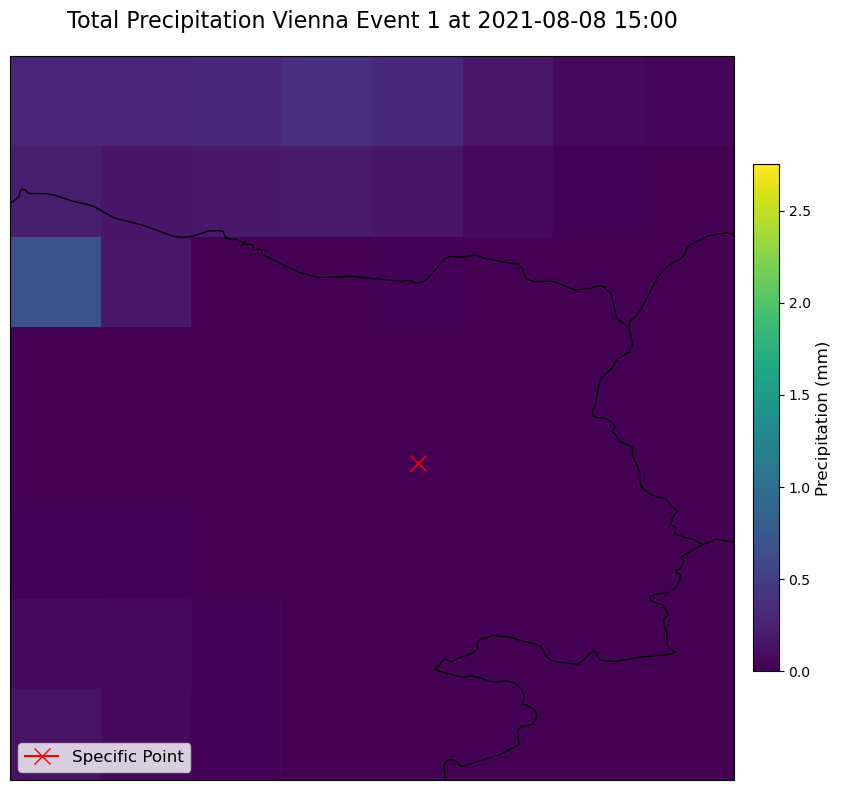

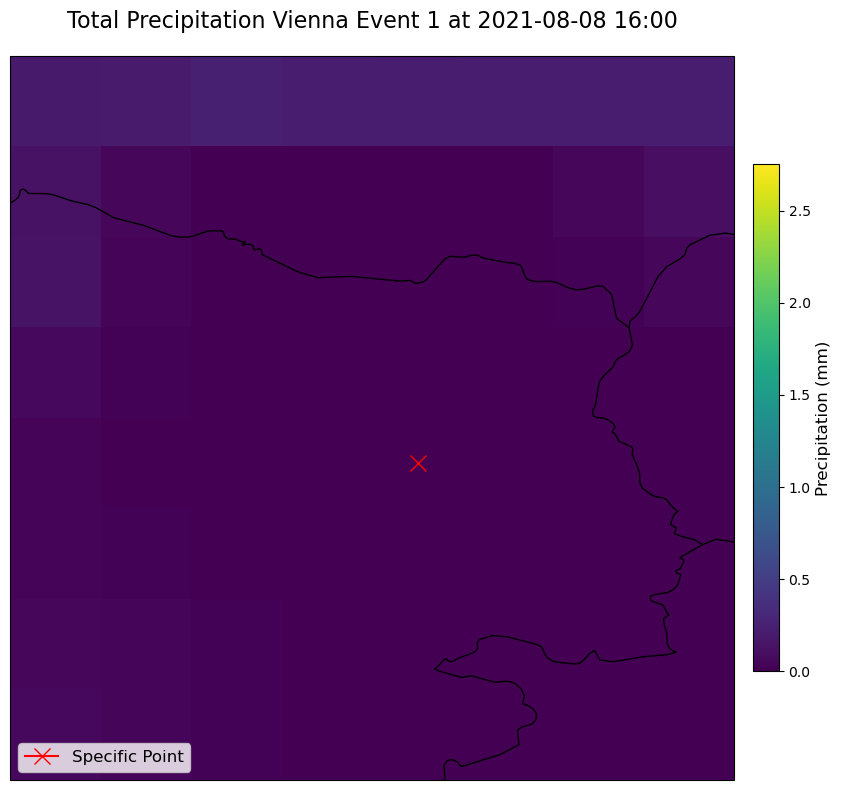

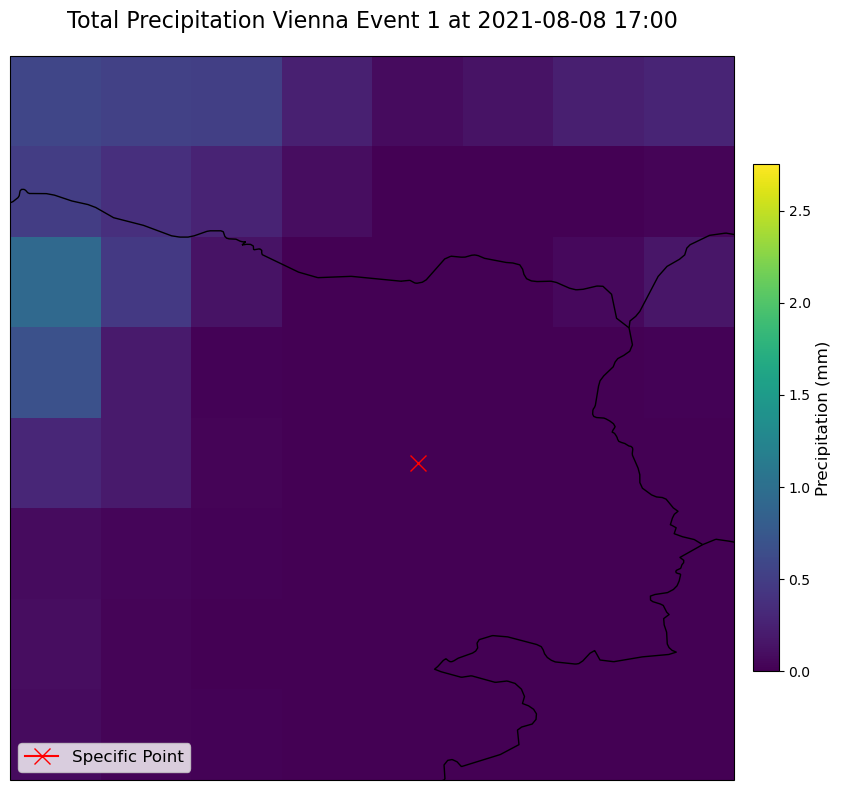

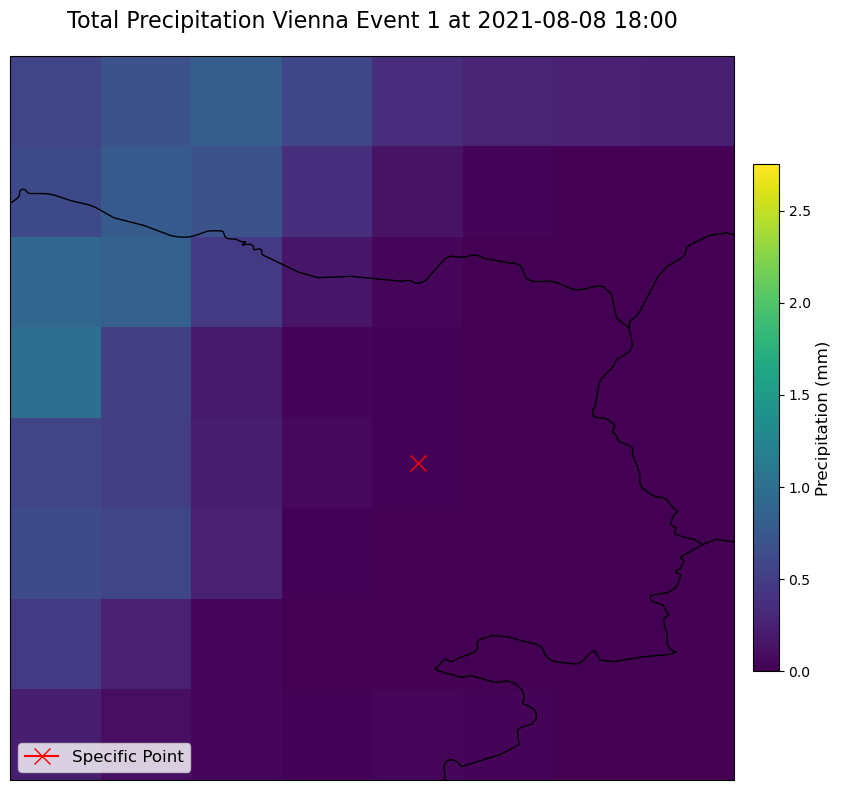

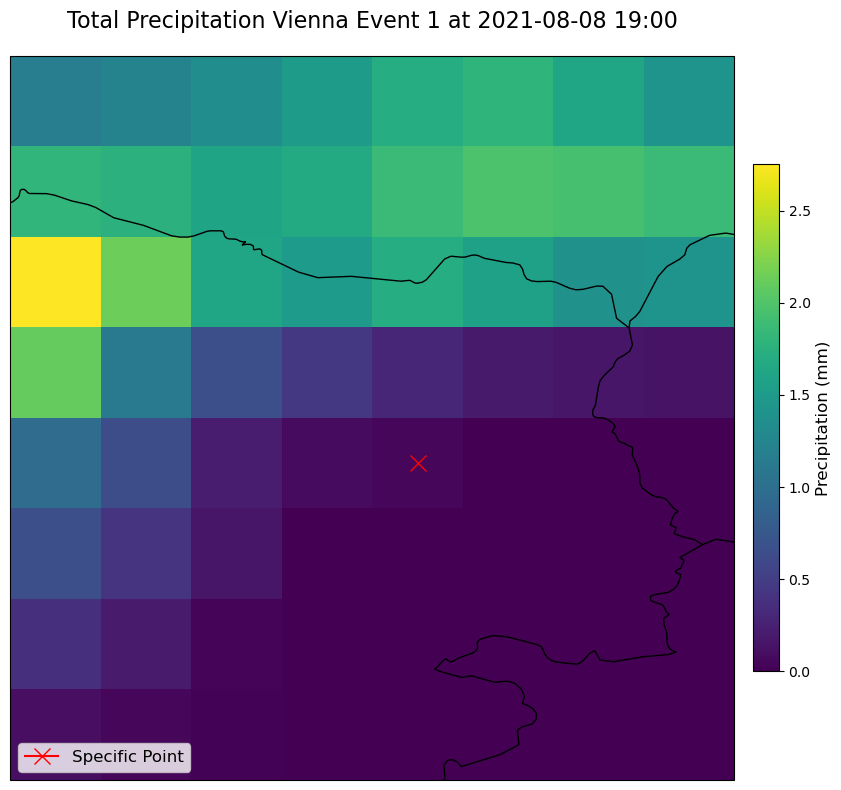

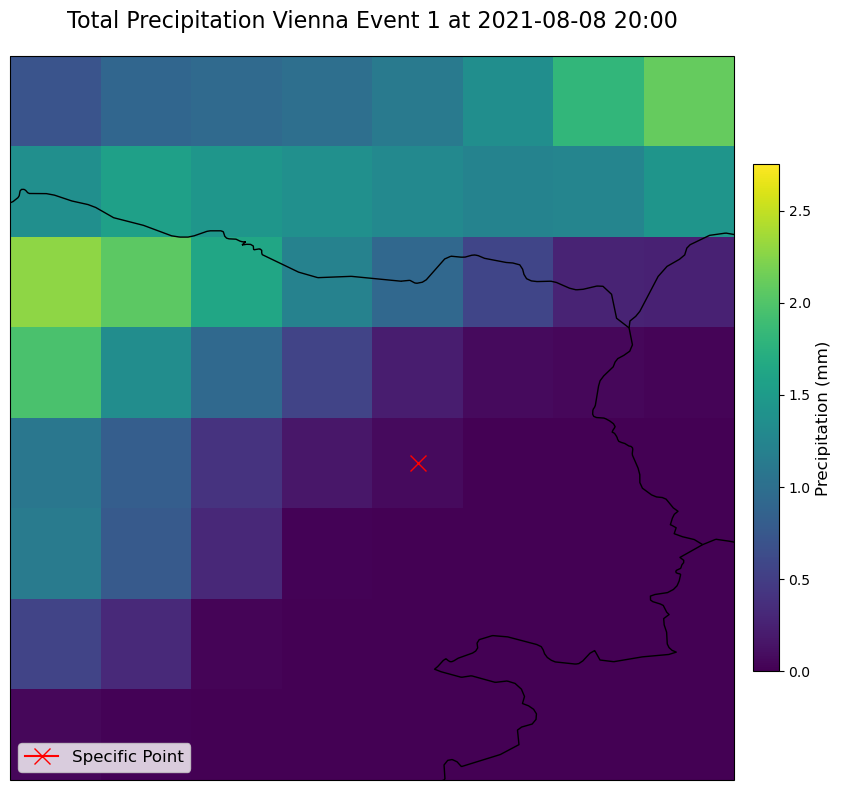

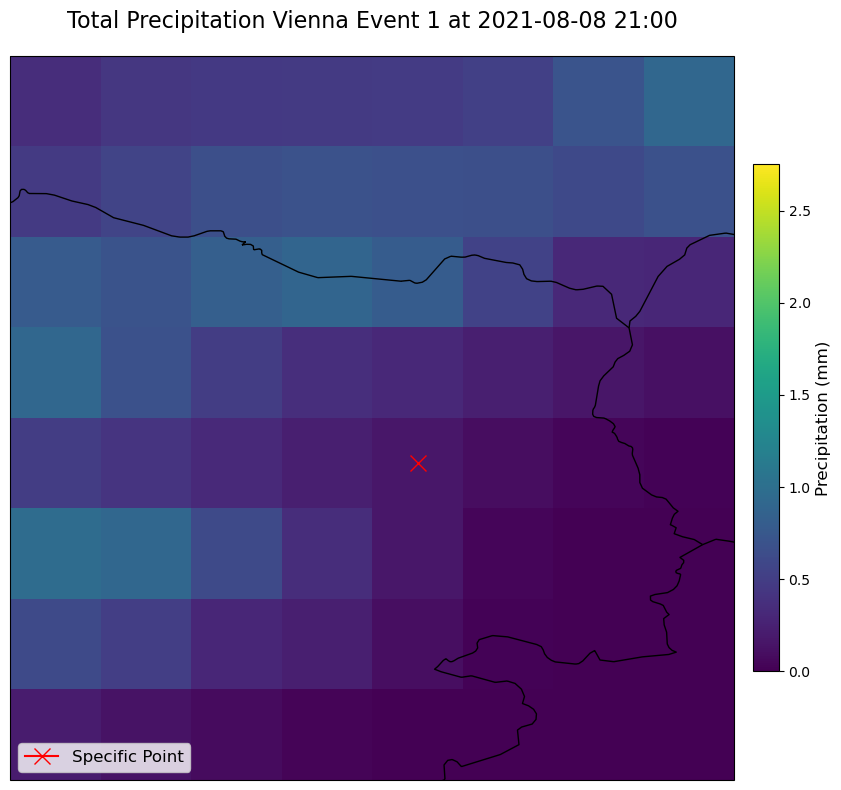

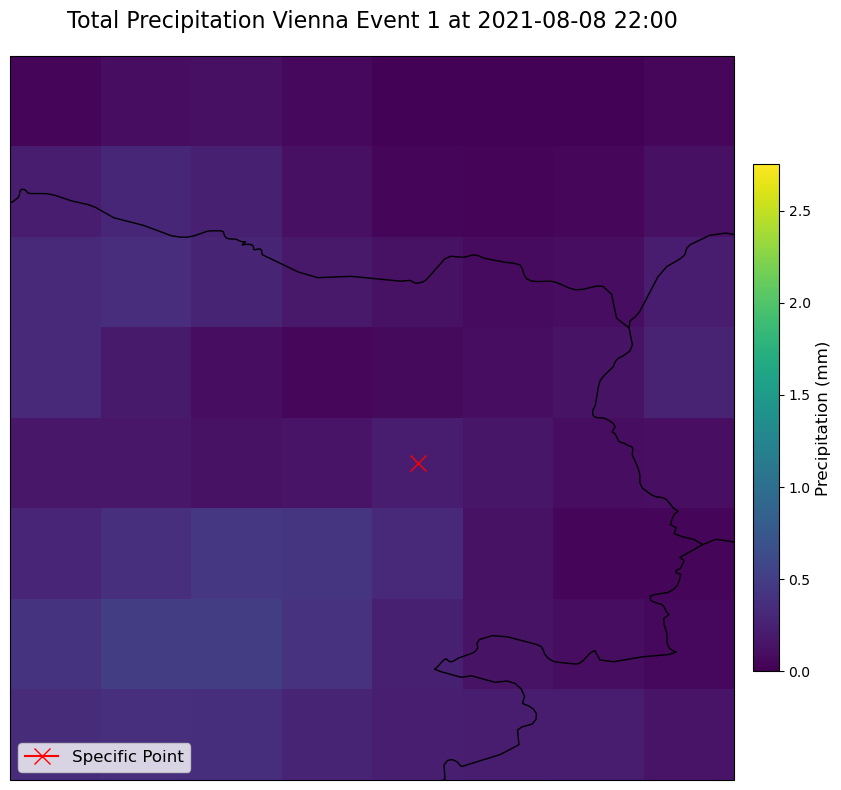

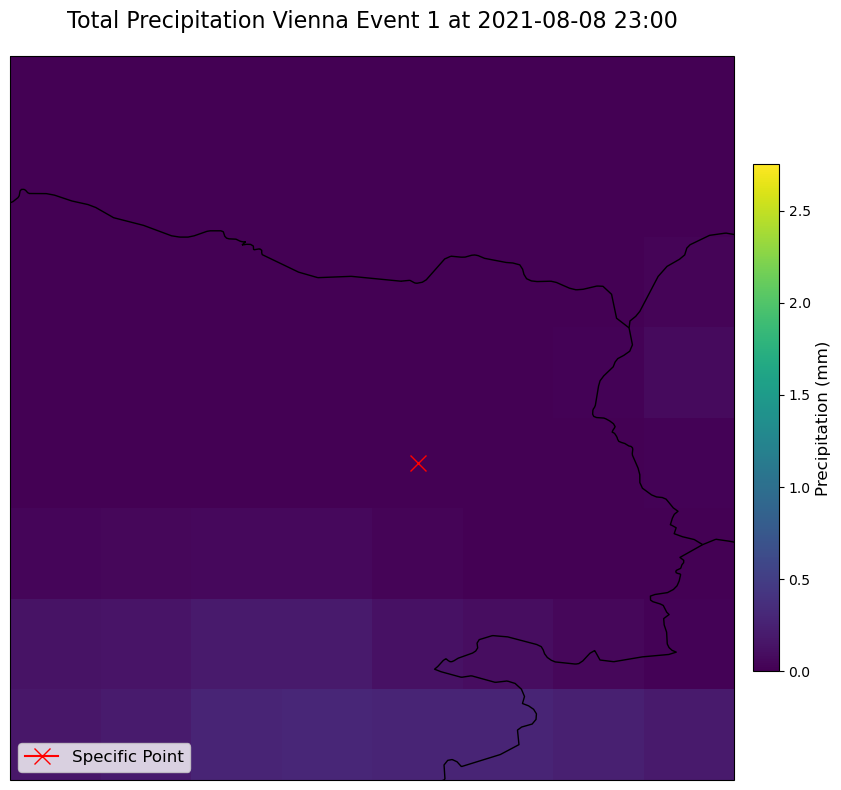

In [40]:


plot_era5_precipitation(
    dataset_path="Training_Vienna/new_2021train/tp/era5_cropped_tipping.nc",
    variable='tp',
    point_coords=(16.3609 , 48.2303),
    time_range=("2021-08-08 00:00", "2021-08-08 23:00"),
    title_base='Total Precipitation Vienna Event 1',
    cmap='viridis'
)



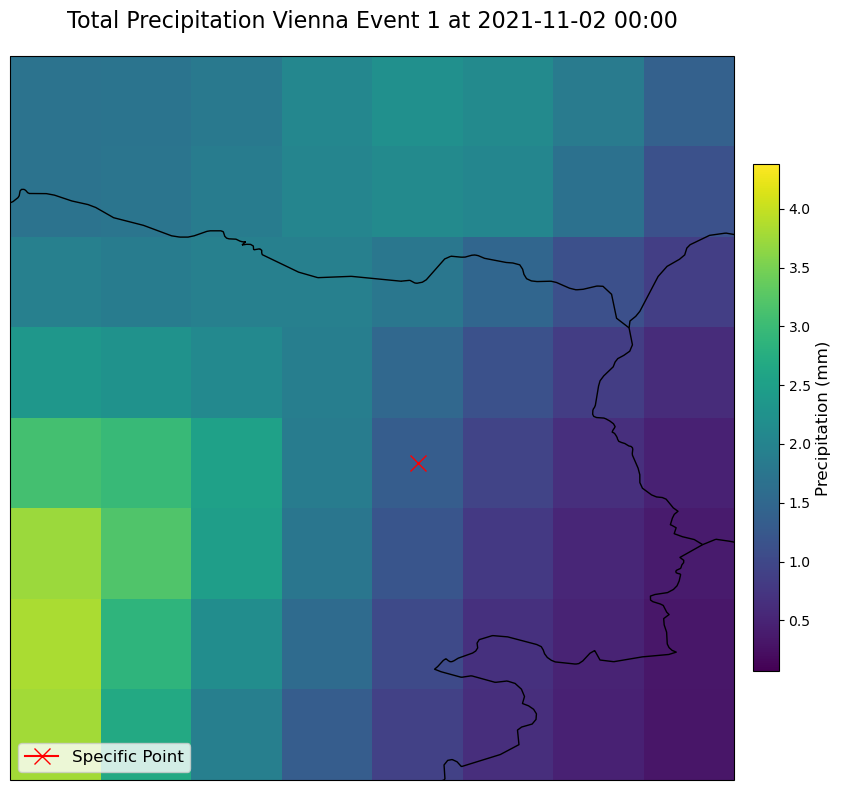

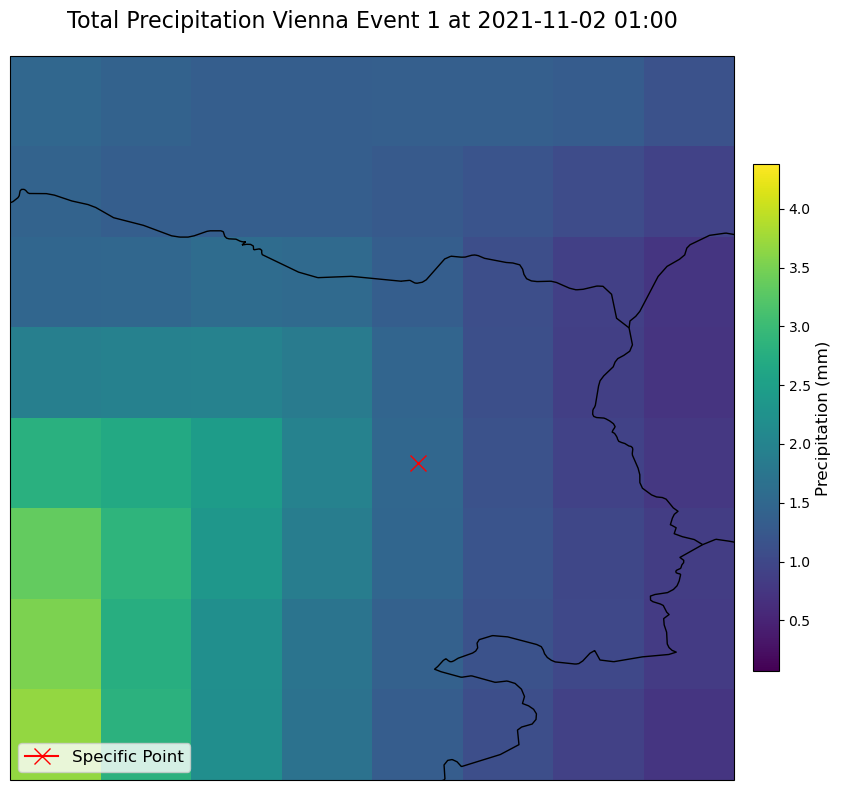

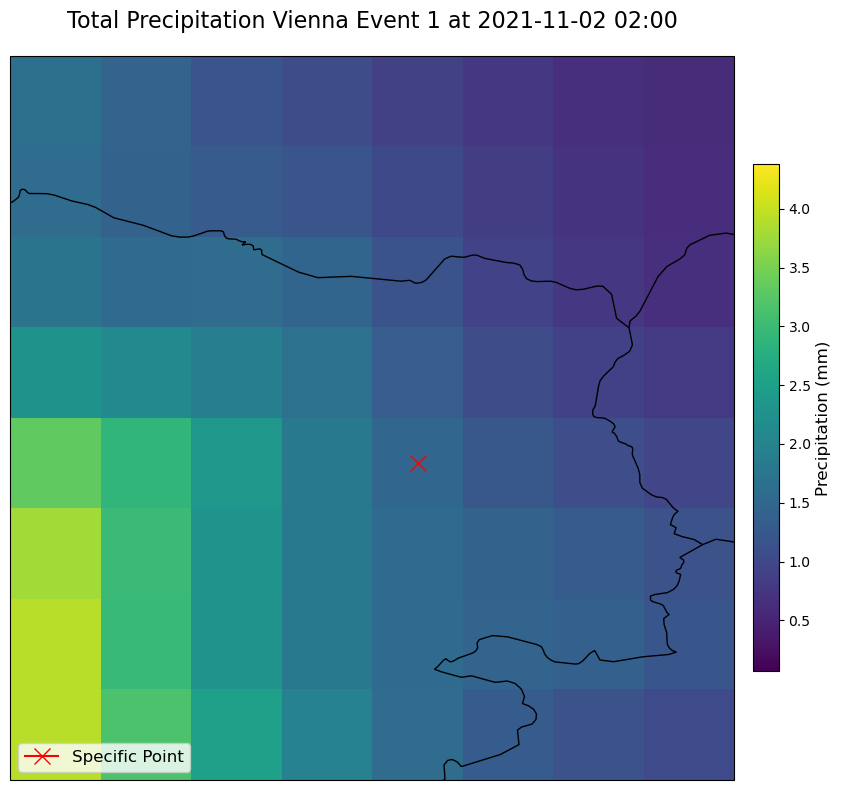

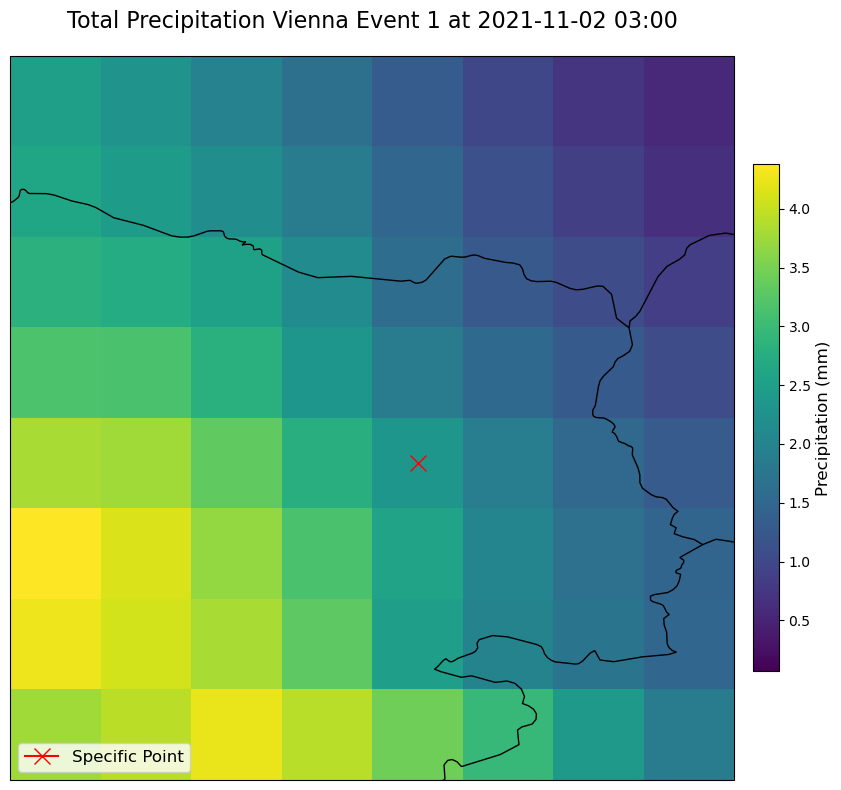

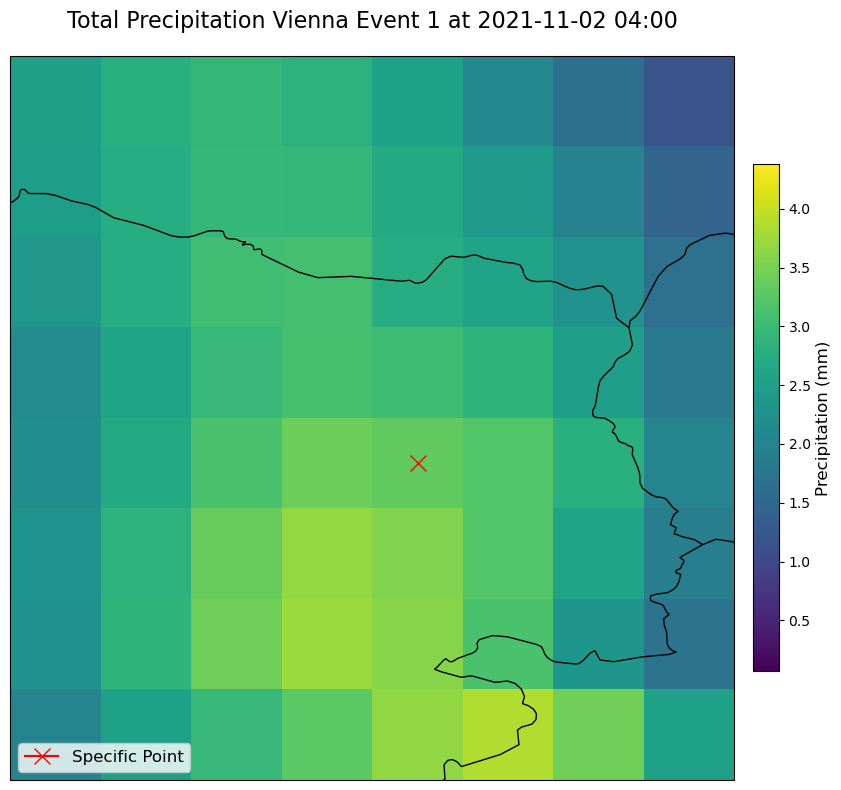

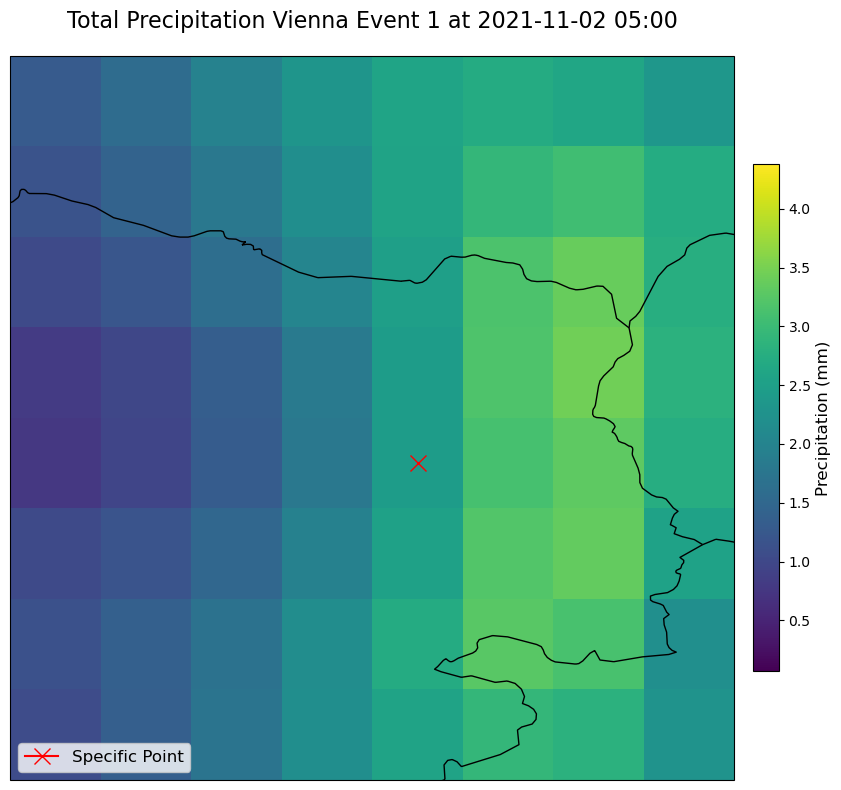

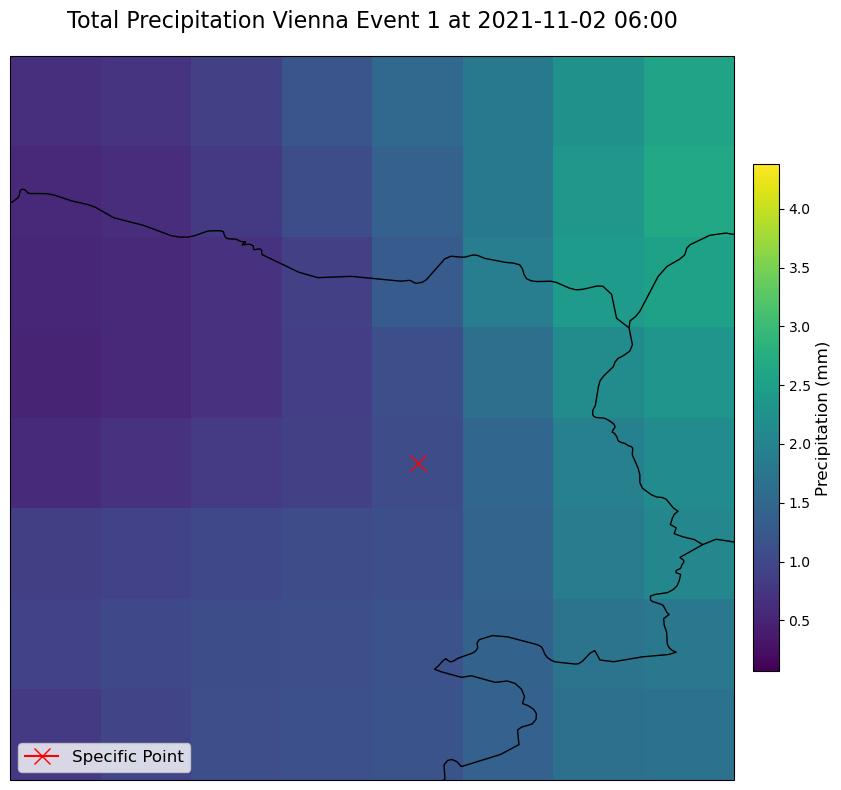

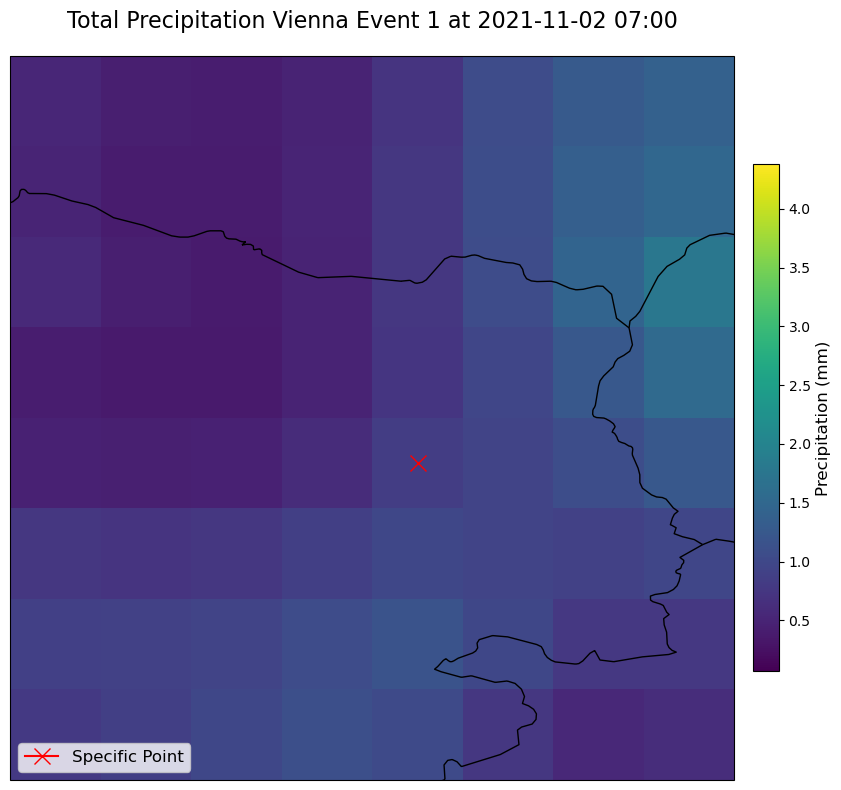

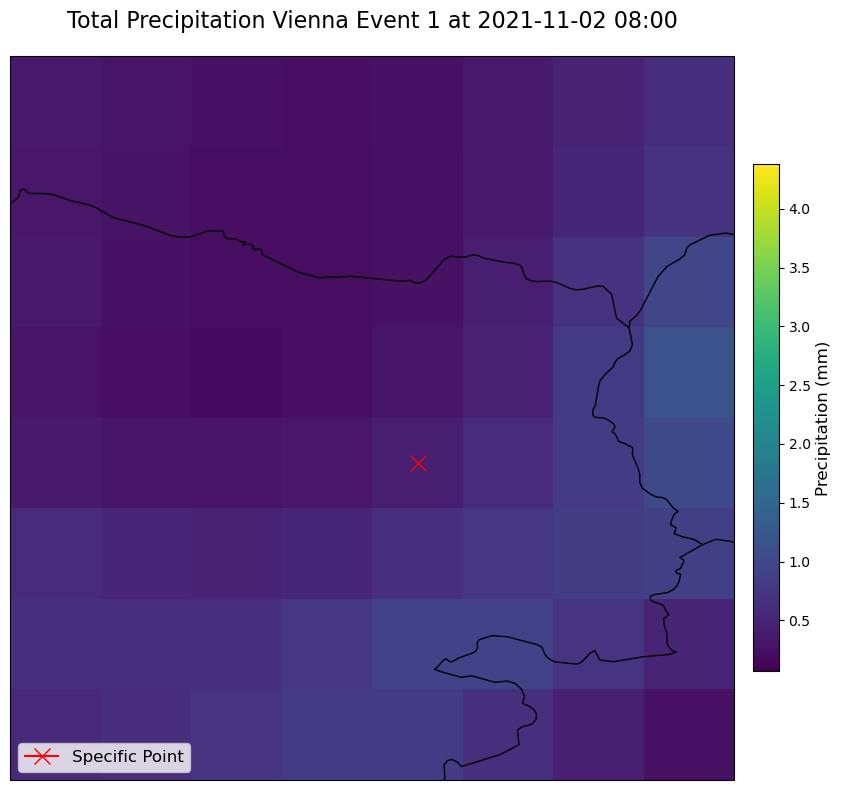

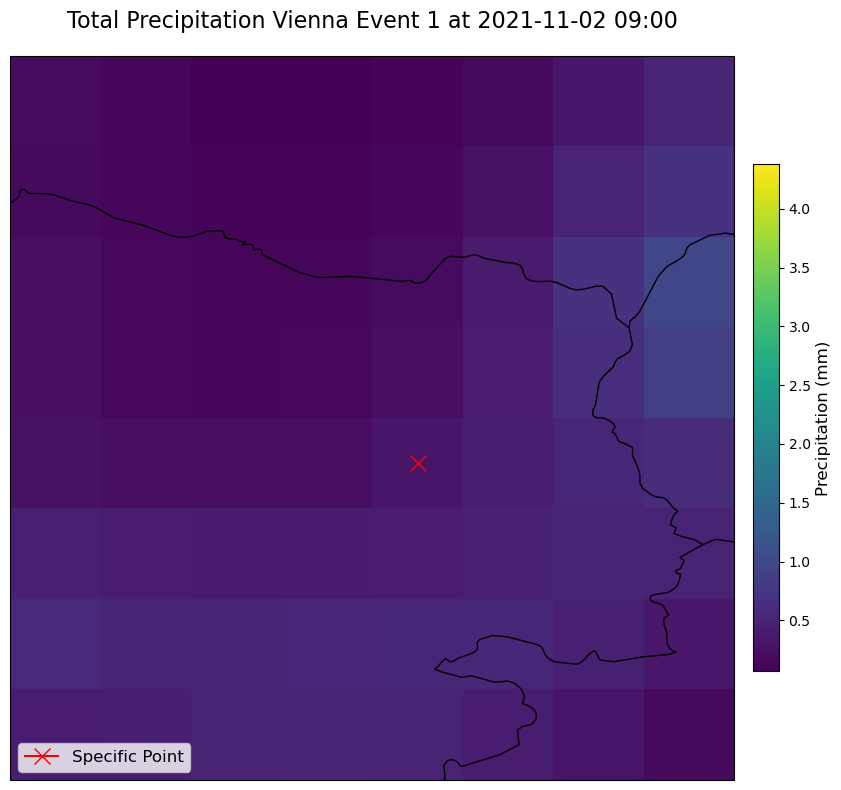

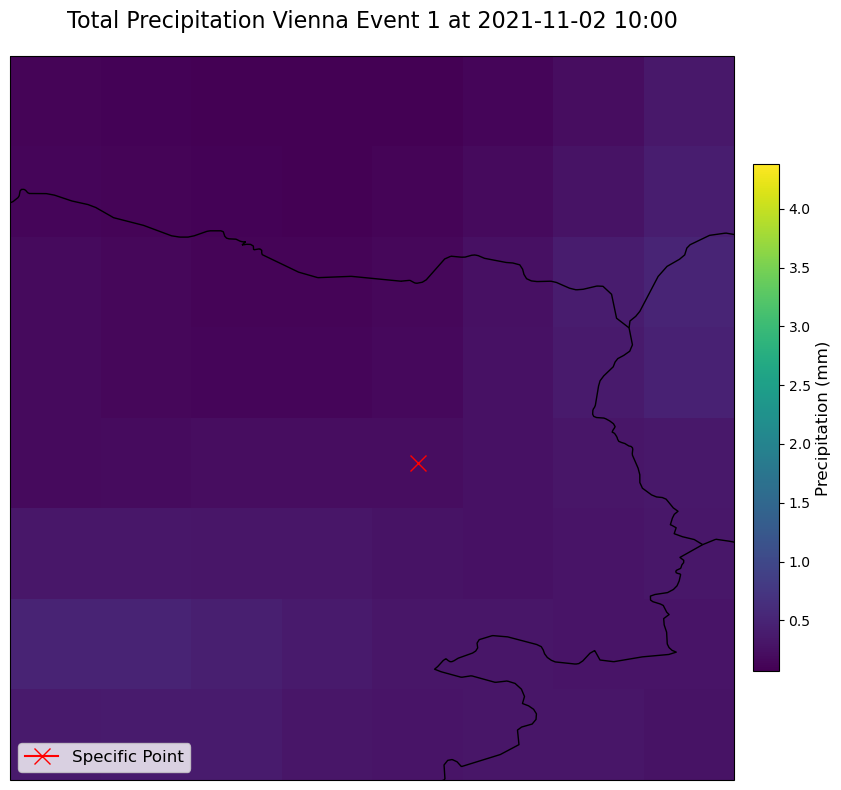

In [60]:


plot_era5_precipitation(
    dataset_path="Training_Vienna/new_2021train/tp/era5_cropped_tipping.nc",
    variable='tp',
    point_coords=(16.3609 , 48.2303),
    time_range=("2021-11-02 00:00", "2021-11-02 10:00"),
    title_base='Total Precipitation Vienna Event 1',
    cmap='viridis'
)

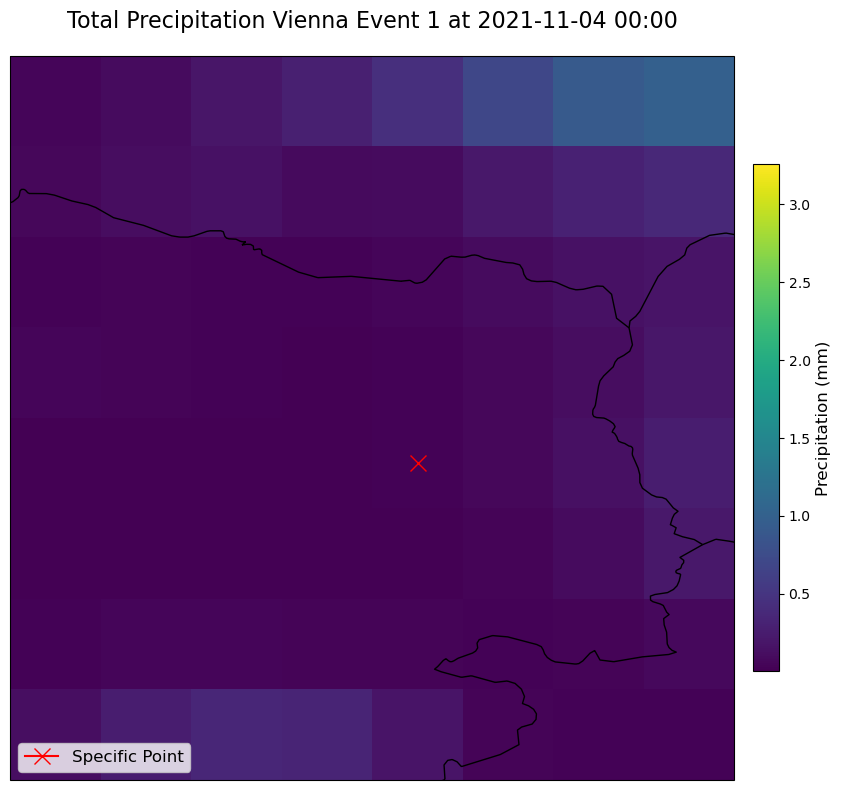

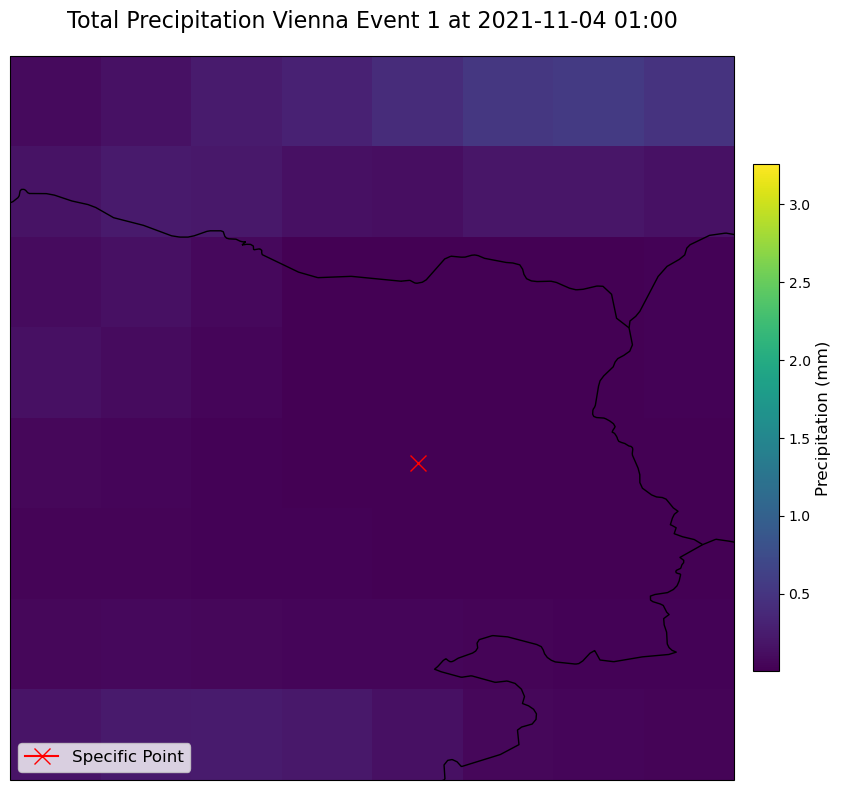

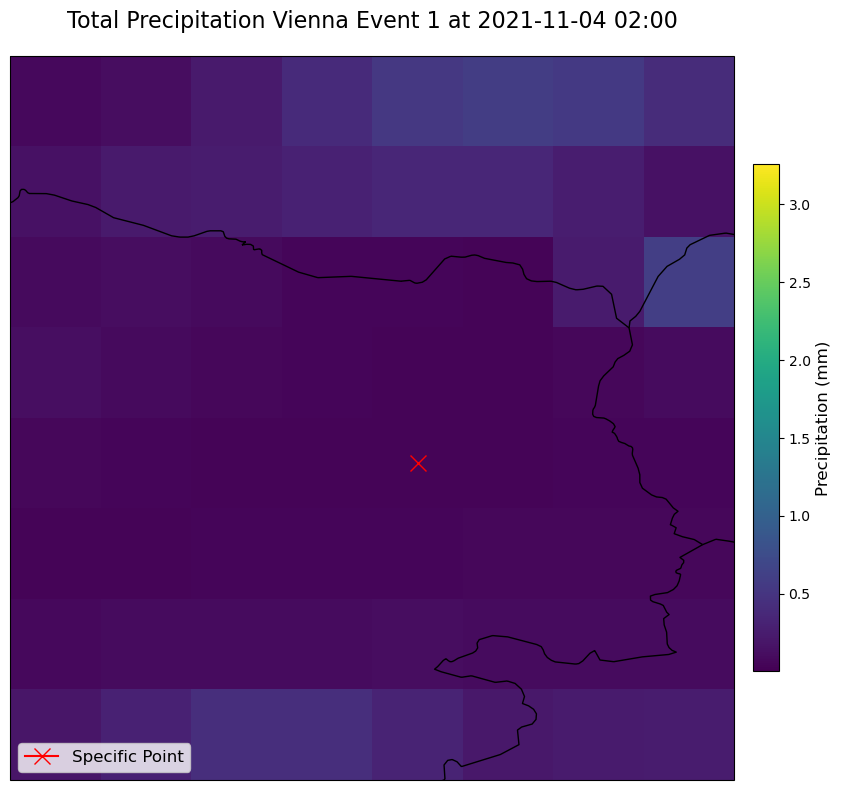

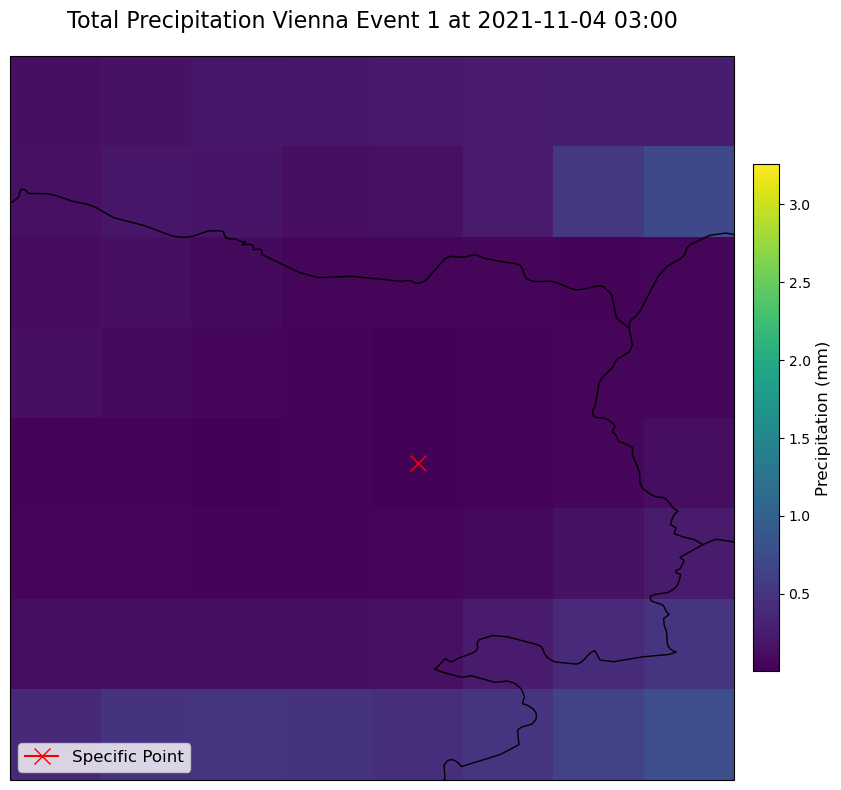

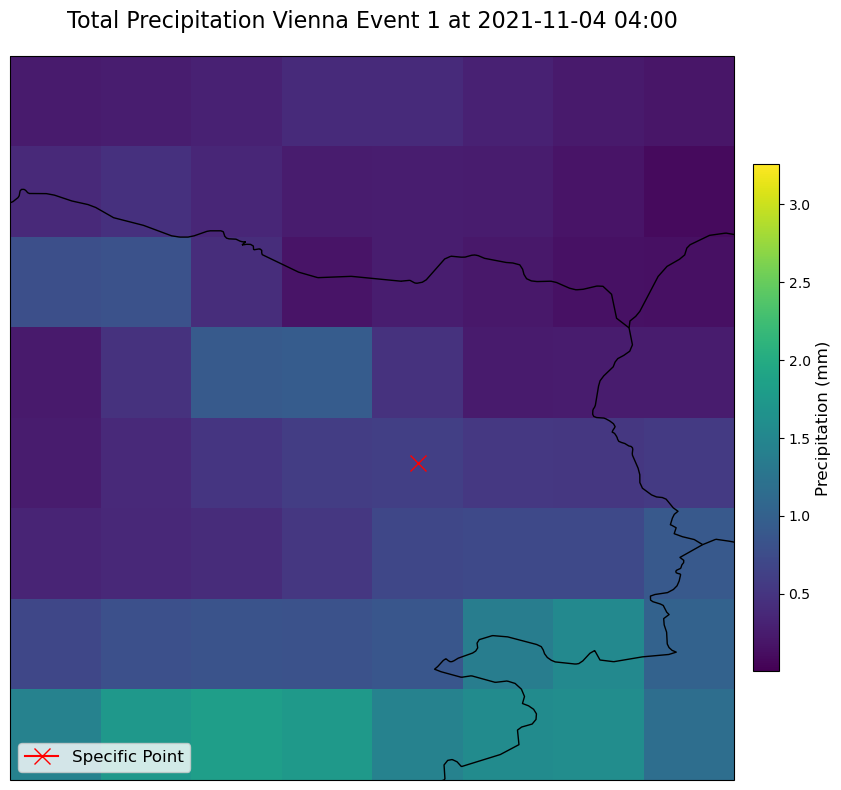

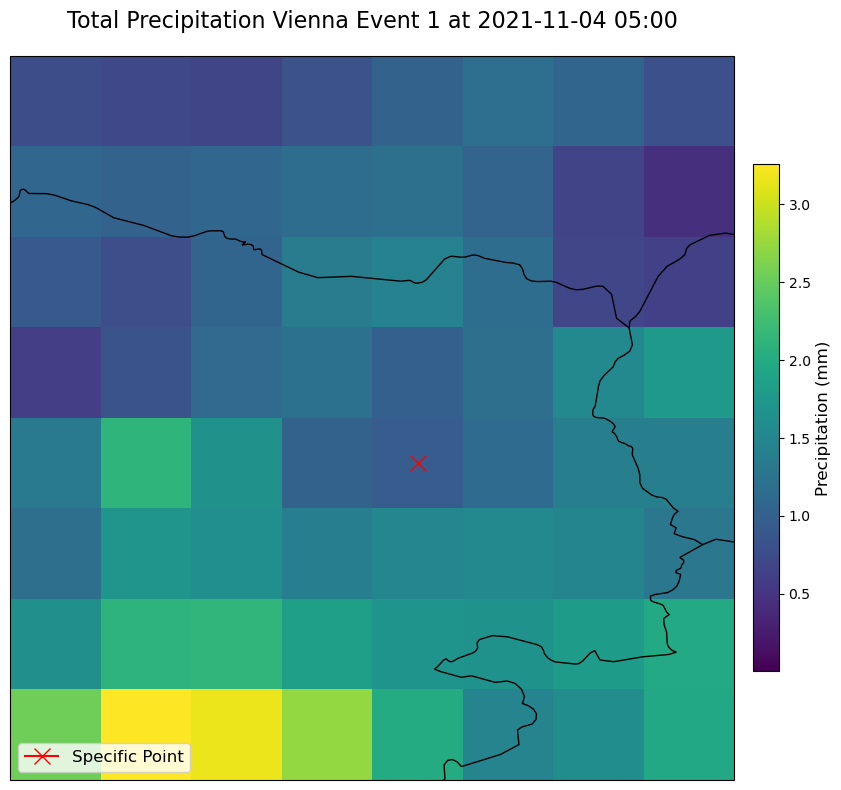

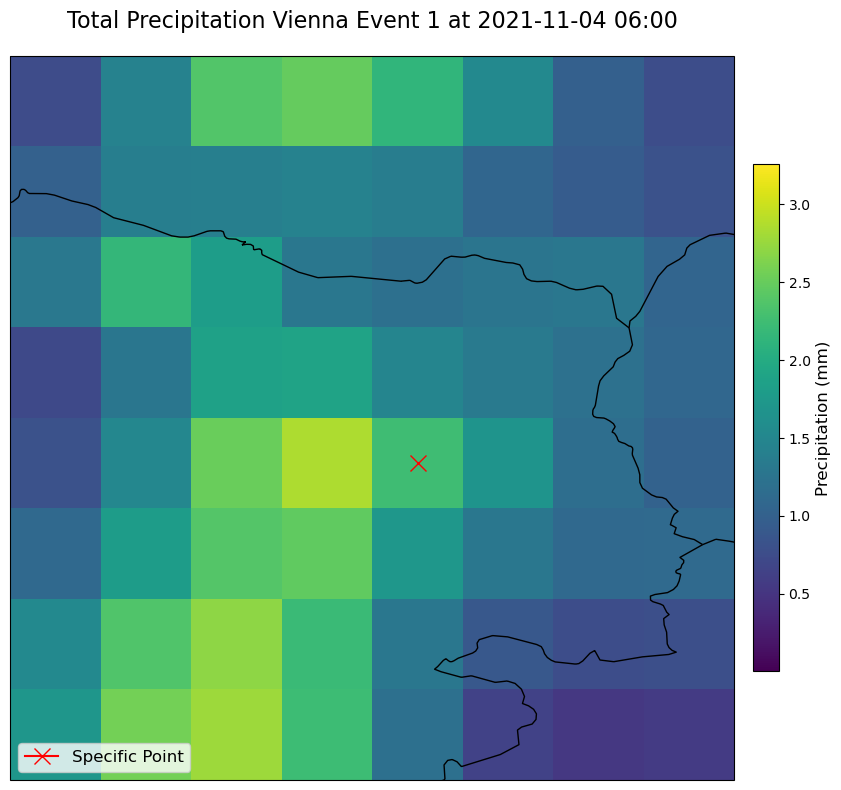

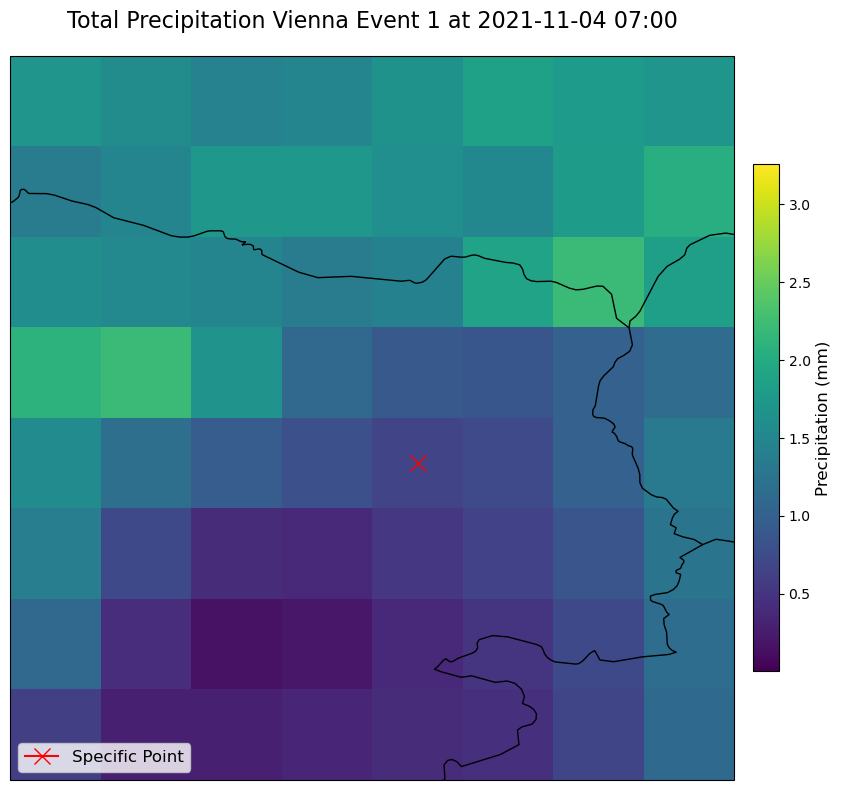

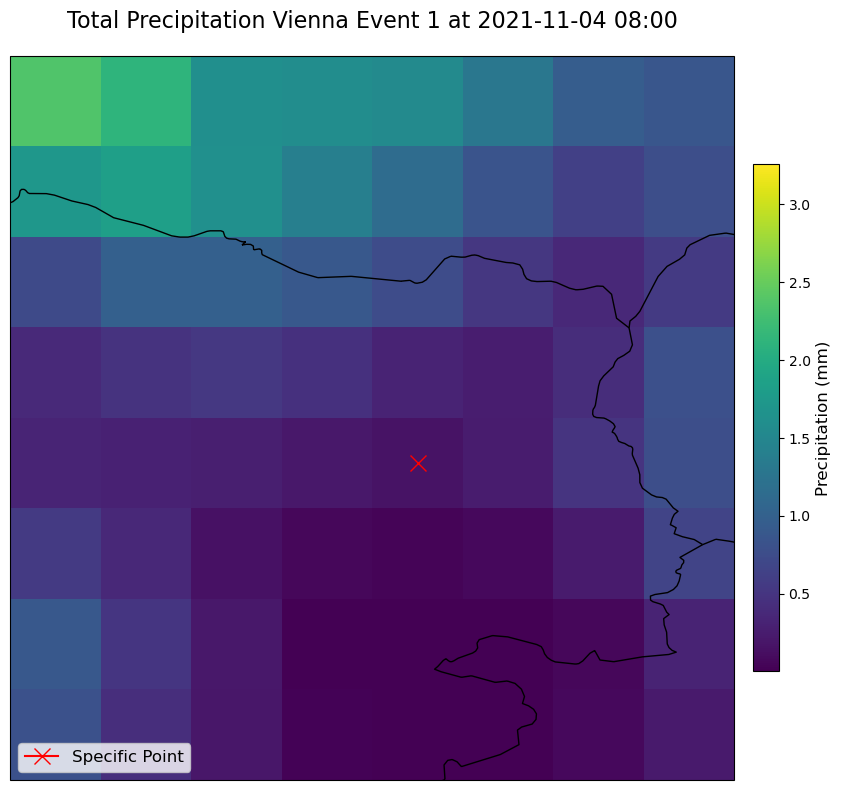

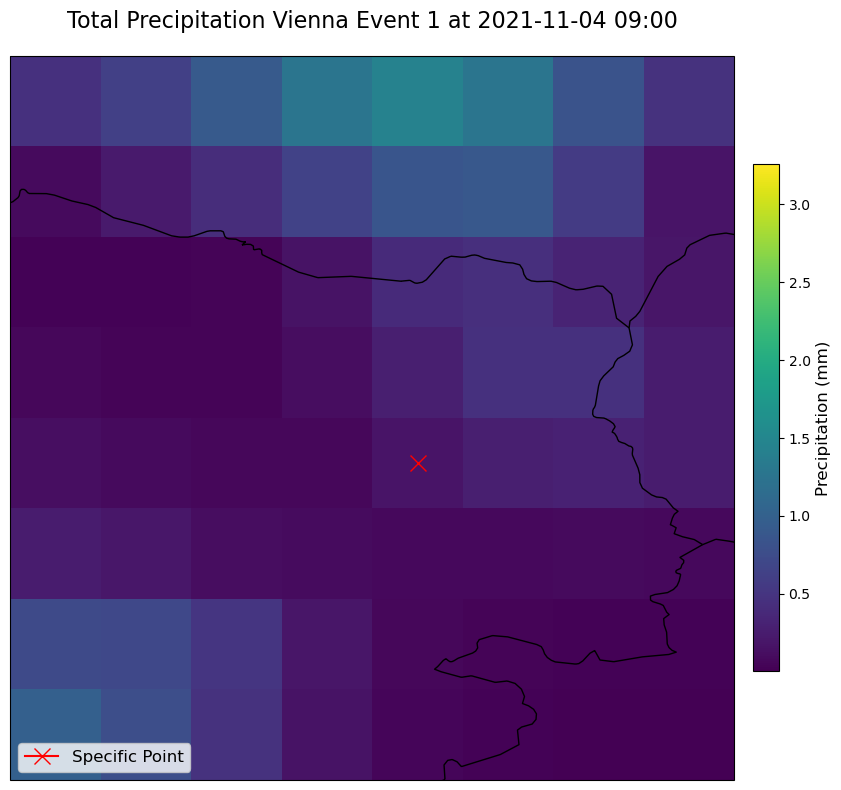

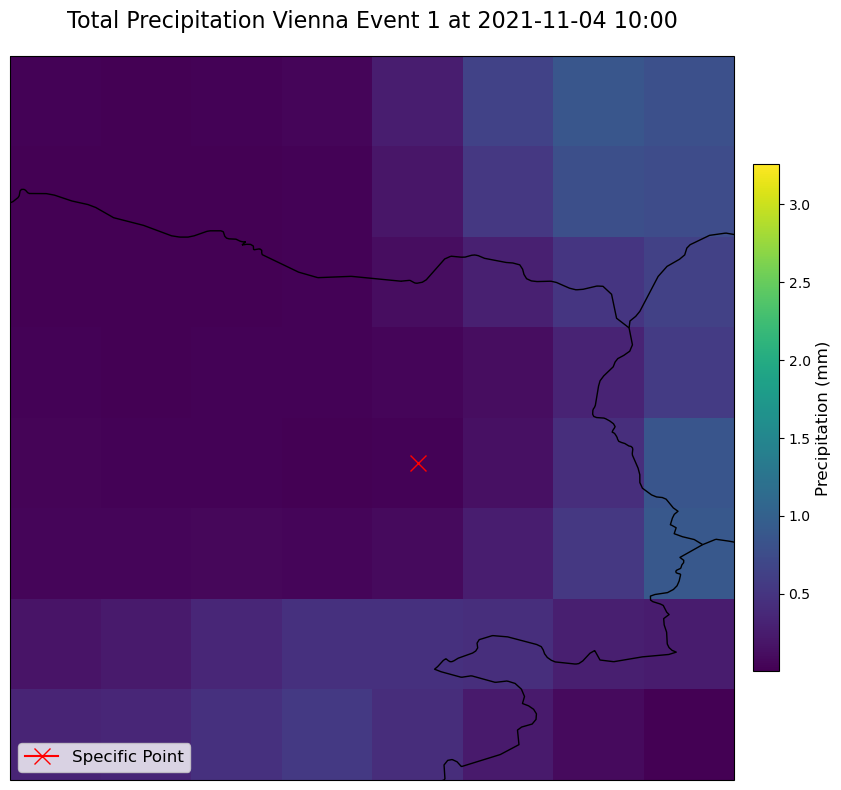

In [61]:
plot_era5_precipitation(
    dataset_path="Training_Vienna/new_2021train/tp/era5_cropped_tipping.nc",
    variable='tp',
    point_coords=(16.3609 , 48.2303),
    time_range=("2021-11-04 00:00", "2021-11-04 10:00"),
    title_base='Total Precipitation Vienna Event 1',
    cmap='viridis'
)

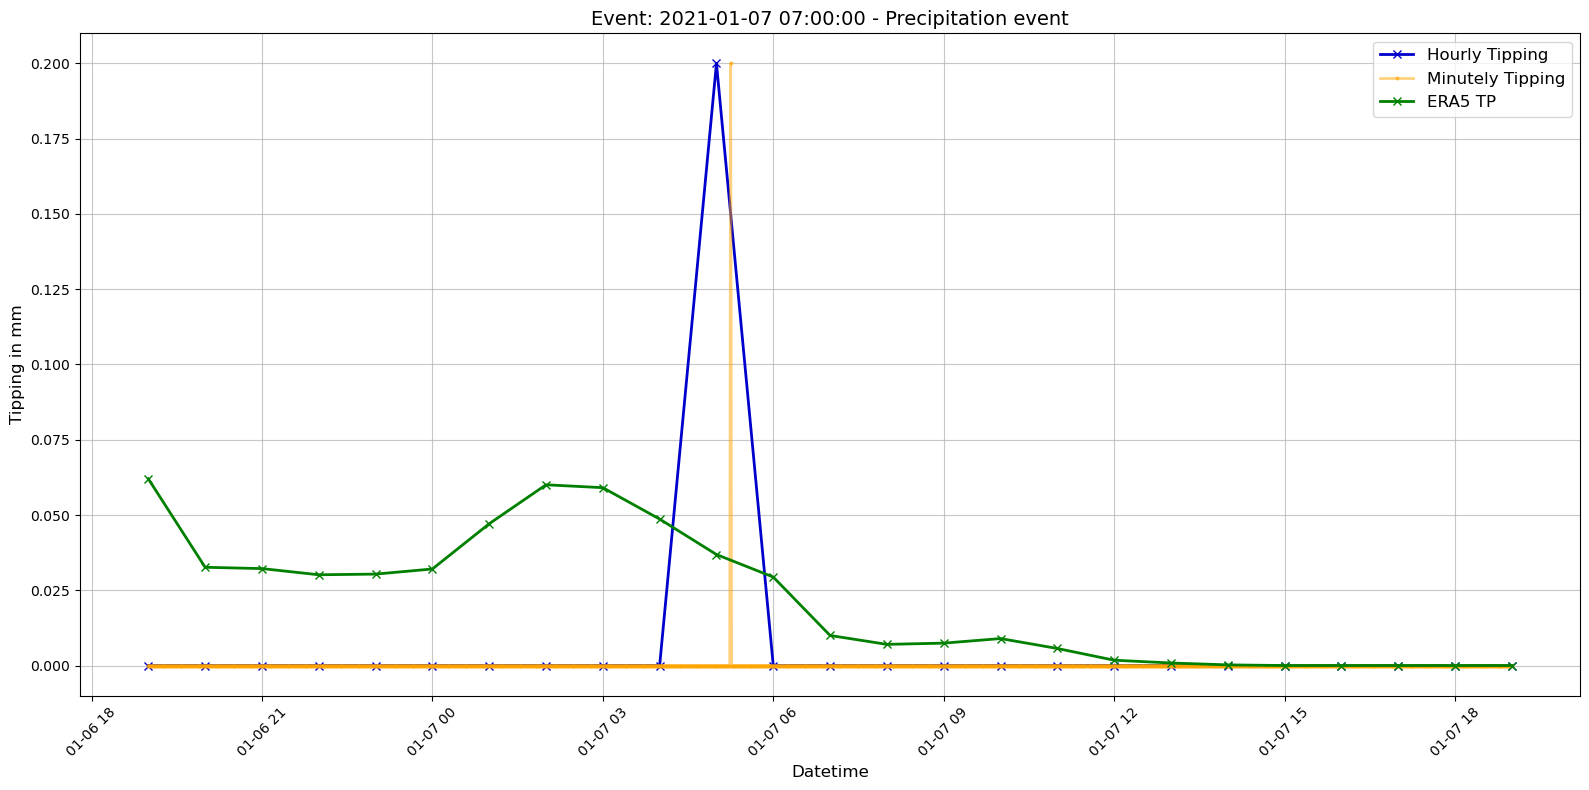

In [42]:
event_3 = pd.Timestamp("2021-01-07 07:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_df,
    era5_ds=era5_vienna,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303  ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


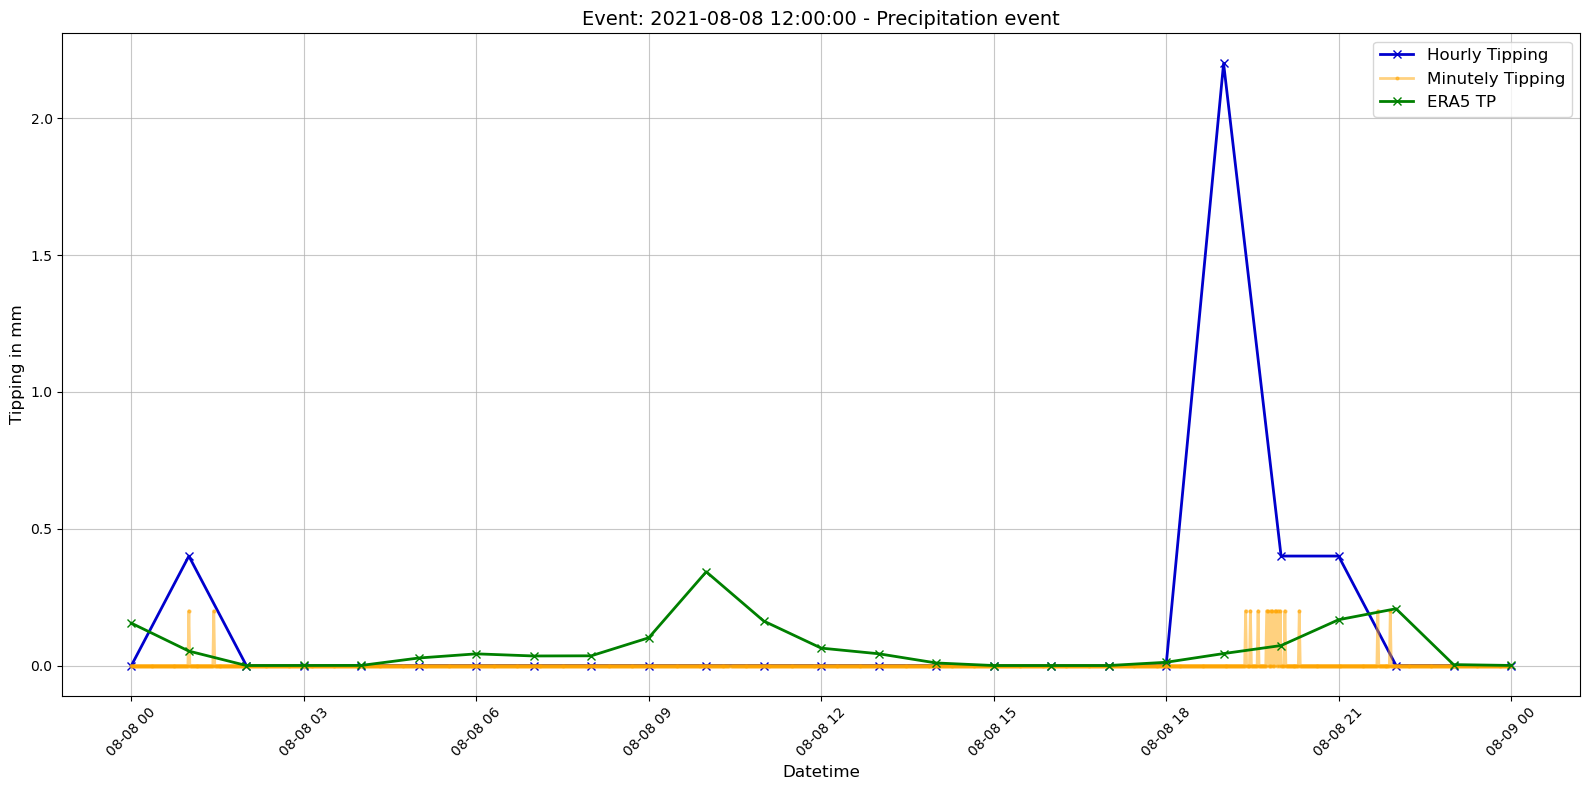

In [43]:
event_3 = pd.Timestamp("2021-08-08 12:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_df,
    era5_ds=era5_vienna,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303  ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


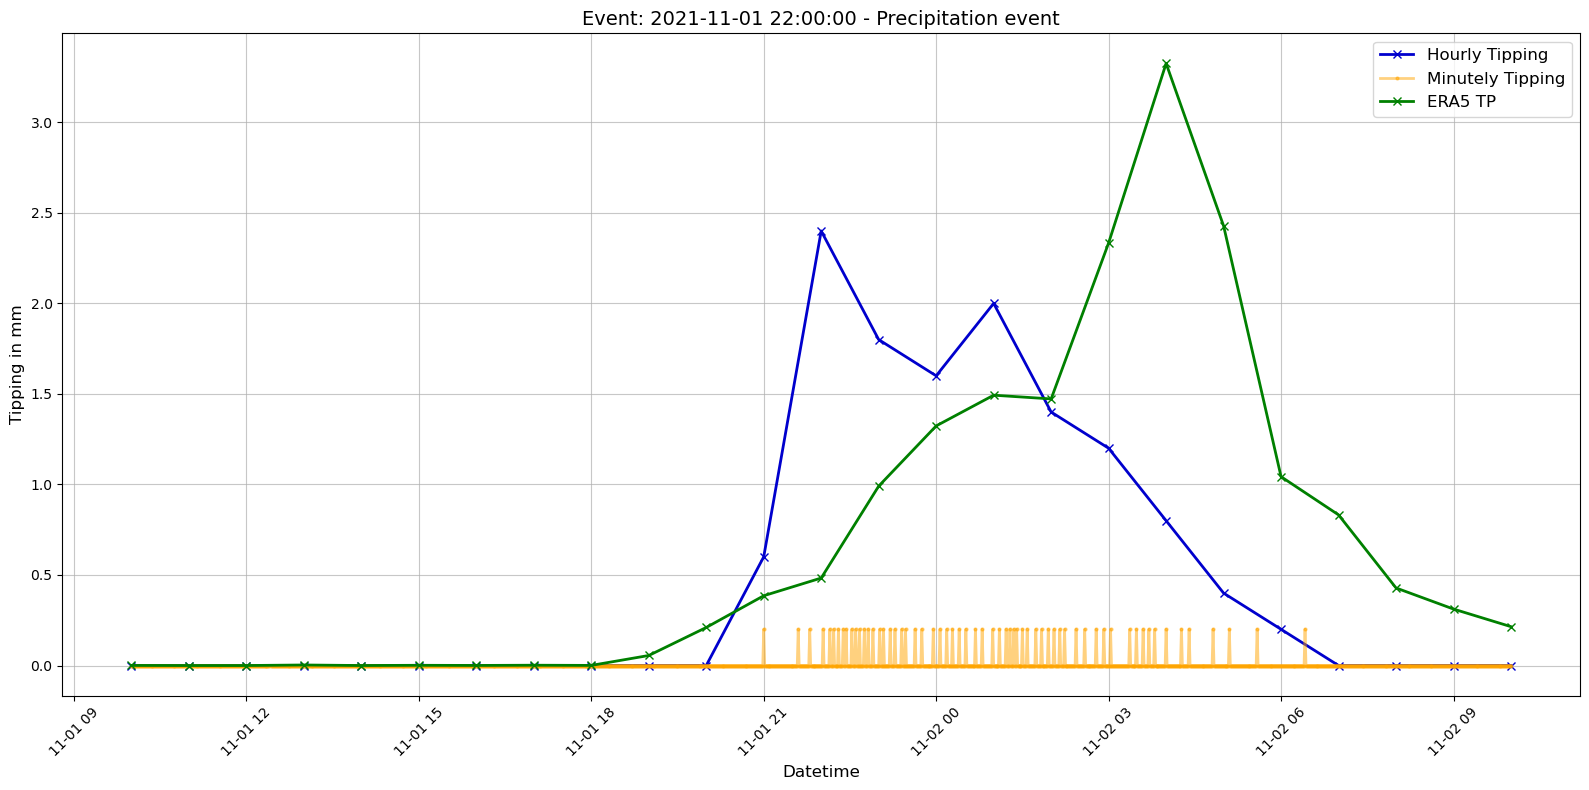

In [45]:
event_3 = pd.Timestamp("2021-11-01 22:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_df,
    era5_ds=era5_vienna,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303  ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


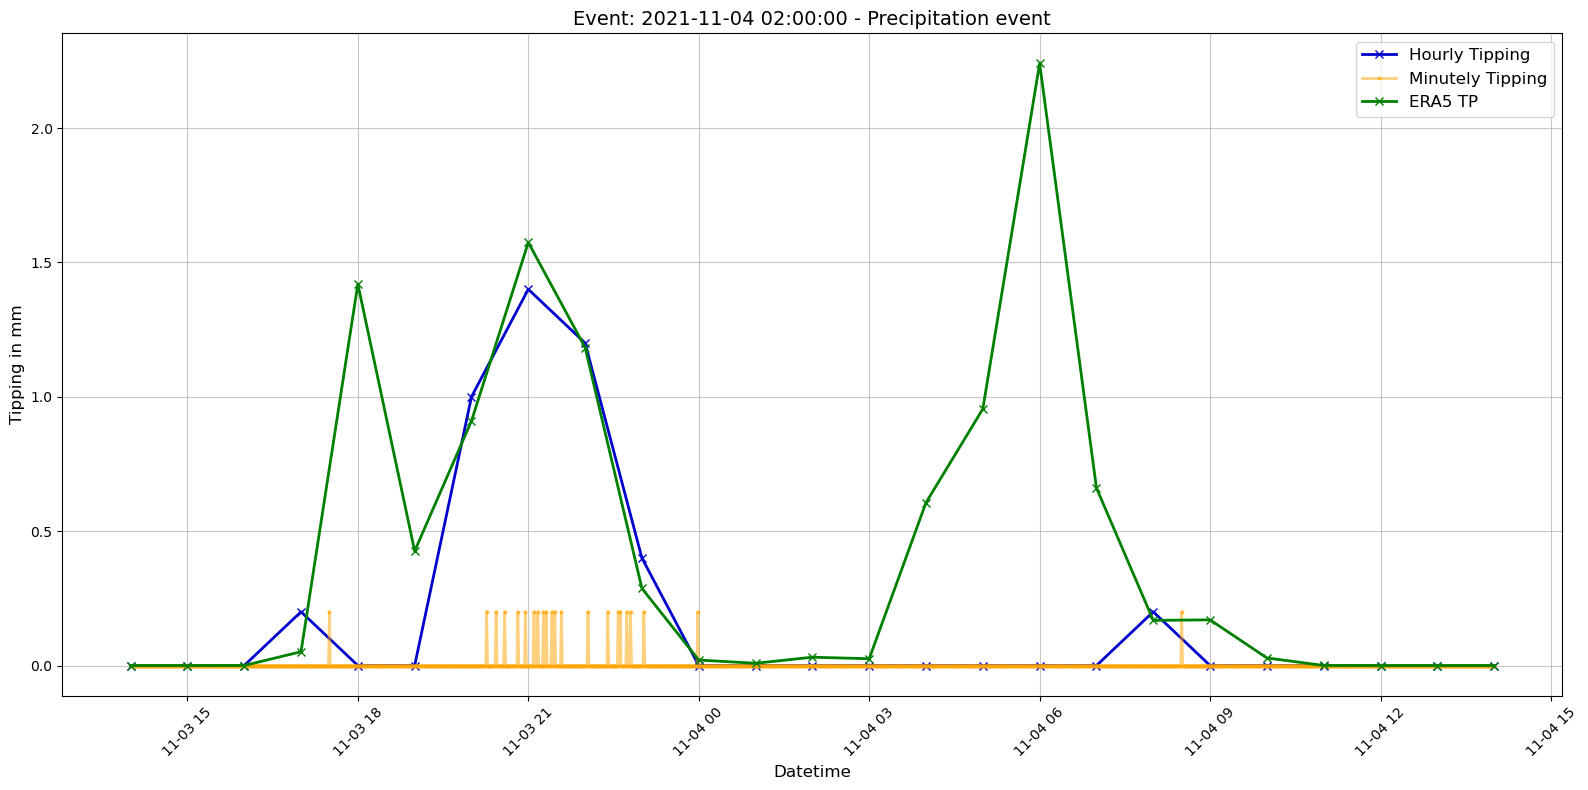

In [62]:
event_3 = pd.Timestamp("2021-11-04 02:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_df,
    era5_ds=era5_vienna,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303  ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)


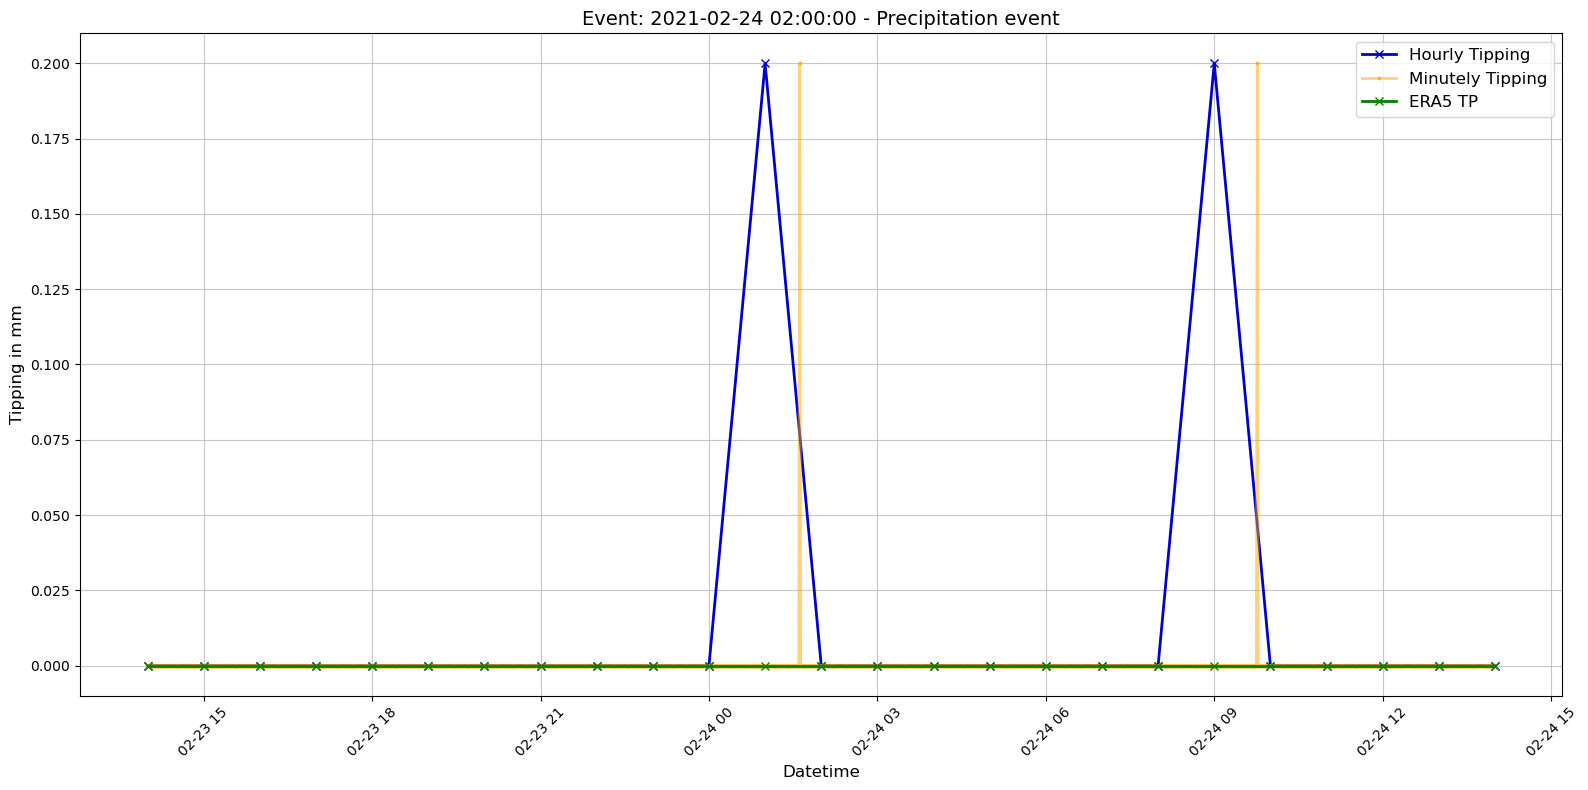

In [72]:
event_3 = pd.Timestamp("2021-02-24 02:00")

# Plot Event 1: Temperature Comparison
plot_event_comparison(
    event_time=event_3,
    hourly_df=vienna_hourly_df,
    minutely_df=vienna_df,
    era5_ds=era5_vienna,
    variable_hourly="tipping",       # Hourly temperature
    variable_minute="tipping",       # Minutely temperature
    era5_variable="tp",              # ERA5 2-meter temperature
    lat=48.2303  ,
    lon=16.3609,
    time_window=pd.Timedelta(hours=12),
    same_y_axis=True,
    title_suffix="Precipitation event",
    save_fig=False
)
